<a href="https://colab.research.google.com/github/Lookieman/home_projects/blob/main/ThinkOnwardsComp/Phase2b_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phase 2B intends to look at the following:

a.  why there are statistically significant differences in geological complexity between Fold 0 and Fold 3

b. Does Fold 0 experience training instabilities which Fold 3 does not?

c. Are there outlier samples in Fold 0 that makes training more difficult?

d. What geological characteristics correlate with poor model performance?

In [ ]:
#Phase2a
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time
from tqdm import tqdm
import gc
from scipy import ndimage
from math import e

#phase 2b
import pandas as pd
import seaborn as sns
from math import e

In [ ]:
# Configuration
USE_ADAPTIVE_MODEL = True  # Set to True for adaptive model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
ENSEMBLE_SIZE = 3
K_FOLDS = 5
DEBUG_ACTIVE = False
FAST_TRAINING = True  # Set to True for speed, False for detailed analysis

from google.colab import drive
drive.mount('/content/drive')

data_dir = Path('/content/drive/MyDrive/ThinkOnward/Data/Train')
result_dir = Path('/content/drive/MyDrive/ThinkOnward/Result/Phase2b')

print(f"Using device: {DEVICE}")
#print(f"Model type: {'Adaptive' if USE_ADAPTIVE_MODEL else 'Resize'}")

Mounted at /content/drive
Using device: cuda


In [ ]:
class SeismicDataset(Dataset):
    def __init__(self, data_dir, sample_indices, use_adaptive=False):
        self.data_dir = data_dir
        self.sample_indices = sample_indices
        self.use_adaptive = use_adaptive
        self.receiver_files = [
            'receiver_data_src_1.npy',
            'receiver_data_src_75.npy',
            'receiver_data_src_150.npy',
            'receiver_data_src_225.npy',
            'receiver_data_src_300.npy'
        ]

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        sample_idx = self.sample_indices[idx]
        sample_dir = os.path.join(self.data_dir, f'TrainingData_{sample_idx}')

        # Load receiver data (5 files)
        receiver_data = []
        for file_name in self.receiver_files:
            file_path = os.path.join(sample_dir, file_name)
            data = np.load(file_path).astype(np.float32)  # (10001, 31)
            receiver_data.append(data)

        # Load target velocity model
        target_path = os.path.join(sample_dir, 'vp_model.npy')
        target = np.load(target_path).astype(np.float32)  # (300, 1259)

        if self.use_adaptive:
            # Process for adaptive model
            processed_inputs = []
            for data in receiver_data:
                # 1D conv + maxpool simulation using numpy
                # Downsample from 10001 to ~313 (factor of ~32)
                downsampled = data[::32, :]  # (313, 31)

                # Zero pad from 31 to 32 channels
                if downsampled.shape[1] == 31:
                    padded = np.pad(downsampled, ((0, 0), (0, 1)), mode='constant')  # (313, 32)
                else:
                    padded = downsampled

                # Reshape to make it more compact 2D
                # We'll treat this as (313, 32) for now and let the model handle it
                processed_inputs.append(padded.T)  # (32, 313) for easier processing

            # Stack all 5 processed inputs
            input_tensor = np.stack(processed_inputs, axis=0)  # (5, 32, 313)
        else:
            # Process for resize model
            processed_inputs = []
            for data in receiver_data:
                # Resize (10001, 31) to (300, 1259)
                resized = ndimage.zoom(data, (300/10001, 1259/31), order=1)
                processed_inputs.append(resized)

            # Stack all 5 processed inputs
            input_tensor = np.stack(processed_inputs, axis=0)  # (5, 300, 1259)

        return torch.from_numpy(input_tensor), torch.from_numpy(target)


In [ ]:
# Helper function to match tensor sizes for skip connections
def match_tensor_size(tensor1, tensor2):
    """Match the spatial dimensions of tensor1 to tensor2 by cropping or padding."""
    _, _, h1, w1 = tensor1.shape
    _, _, h2, w2 = tensor2.shape

    # Calculate differences
    dh = h2 - h1
    dw = w2 - w1

    if dh > 0 or dw > 0:
        # Pad tensor1 if it's smaller
        pad_h = max(0, dh)
        pad_w = max(0, dw)
        tensor1 = F.pad(tensor1, (0, pad_w, 0, pad_h))
    elif dh < 0 or dw < 0:
        # Crop tensor1 if it's larger
        tensor1 = tensor1[:, :, :h2, :w2]

    return tensor1

# MAPE Loss Function
def mape_loss(predictions, targets, epsilon=1e-8):
    targets_safe = torch.clamp(torch.abs(targets), min=epsilon)
    return torch.mean(torch.abs((targets - predictions) / targets_safe)) * 100


In [ ]:
# Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv2 = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.conv1(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.conv2(x).view(batch_size, -1, width * height)
        value = self.conv3(x).view(batch_size, -1, width * height)

        attention = torch.bmm(query, key)
        attention = self.softmax(attention)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)

        return self.gamma * out + x

# Double Convolution Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1, use_adaptive=False):
        super(UNet, self).__init__()
        self.use_adaptive = use_adaptive

        if use_adaptive:
            # First process the irregular input
            self.input_processor = nn.Sequential(
                nn.Conv2d(5, 16, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
            # Input will be (5, 32, 313), output will be (32, 32, 313)
            in_channels = 32

        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with attention
        self.bottleneck = DoubleConv(512, 1024)
        self.attention = AttentionBlock(1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Final output
        self.final_conv = nn.Conv2d(64, out_channels, 1)

        if use_adaptive:
            # Final upsampling to reach (300, 1259)
            self.final_upsample = nn.Sequential(
                nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        if self.use_adaptive:
            # Process irregular input first
            x = self.input_processor(x)  # (batch, 32, 32, 313)

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))
        b = self.attention(b)

        # Decoder with skip connections
        d4 = self.up4(b)
        d4 = match_tensor_size(d4, e4)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = match_tensor_size(d3, e3)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = match_tensor_size(d2, e2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = match_tensor_size(d1, e1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final output
        output = self.final_conv(d1)

        if self.use_adaptive:
            # Upsample to final target size (300, 1259)
            output = F.interpolate(output, size=(300, 1259), mode='bilinear', align_corners=False)

        return output

In [ ]:
#Enhance Training with logging

class EnhancedKFoldValidator:
    def __init__(self, data_dir, result_dir, k_folds=5):
        self.data_dir = Path(data_dir)
        self.result_dir = Path(result_dir)
        self.k_folds = k_folds
        self.fold_results = []
        self.detailed_logs = {}

        # Create results directory
        self.result_dir.mkdir(parents=True, exist_ok=True)

        # Enhanced logging directory
        self.log_dir = self.result_dir / 'detailed_logs'
        self.log_dir.mkdir(parents=True, exist_ok=True)

    def create_data_splits(self, dataset_size=2000):
        indices = np.arange(1, dataset_size + 1)
        kfold = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)

        splits = []
        for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
            train_samples = indices[train_idx]
            val_samples = indices[val_idx]

            splits.append({
                'fold': fold,
                'train_indices': train_samples,
                'val_indices': val_samples,
                'train_size': len(train_samples),
                'val_size': len(val_samples)
            })
            print(f"Fold {fold}: Train={len(train_samples)}, Val={len(val_samples)}")

        return splits

    def enhanced_train_single_fold(self, fold_info, batch_size=16, num_epochs=30, learning_rate=1e-4):
        fold_num = fold_info['fold']
        print(f"\n=== Enhanced Training Fold {fold_num} ===")

        # Initialize detailed logging for this fold
        fold_log = {
            'fold': fold_num,
            'epoch_logs': [],
            'batch_logs': [],
            'memory_usage': [],
            'lr_schedule': [],
            'loss_curves': {'train': [], 'val': []},
            'gradient_norms': [],
            'training_stability': {}
        }

        # Create fresh model
        model = UNet(in_channels=5, out_channels=1, use_adaptive=USE_ADAPTIVE_MODEL)
        model.to(DEVICE)

        # Model complexity analysis
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        fold_log['model_info'] = {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': total_params * 4 / (1024 * 1024)  # Assuming float32
        }

        print(f"Model Parameters: {total_params:,} ({trainable_params:,} trainable)")

        # Create datasets with enhanced monitoring
        train_dataset = SeismicDataset(self.data_dir, fold_info['train_indices'], use_adaptive=USE_ADAPTIVE_MODEL)
        val_dataset = SeismicDataset(self.data_dir, fold_info['val_indices'], use_adaptive=USE_ADAPTIVE_MODEL)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

        # Enhanced optimizer with monitoring
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

        # Training tracking
        best_val_loss = float('inf')
        best_model_path = self.result_dir / f'enhanced_model_fold_{fold_num}.pth'
        patience_counter = 0

        # Enhanced training loop
        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            # Training phase with detailed logging
            model.train()
            train_loss = 0.0
            batch_losses = []
            gradient_norms = []

            train_progress = tqdm(train_loader, desc=f'Fold {fold_num} Epoch {epoch+1}/{num_epochs} [Train]', disable=False, mininterval=10.0)


            for batch_idx, (inputs, targets) in enumerate(train_progress):
                batch_start_time = time.time()
                # Memory monitoring (conditional on FAST_TRAINING)
                if batch_idx % 10 and torch.cuda.is_available():
                  memory_before = torch.cuda.memory_allocated() / 1e9
                  memory_reserved = torch.cuda.memory_reserved() / 1e9

                try:
                  # NORMAL PROCESSING with FAST_TRAINING optimizations
                  inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                  targets = targets.unsqueeze(1)

                  optimizer.zero_grad()
                  outputs = model(inputs)
                  loss = mape_loss(outputs, targets)
                  loss.backward()

                  total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float('inf'))
                  gradient_norms.append(total_norm.item())

                  optimizer.step()

                  batch_loss = loss.item()
                  train_loss += batch_loss
                  if not FAST_TRAINING or batch_idx % 20 == 0:  # Conditional collection based on FAST_TRAINING
                      batch_losses.append(batch_loss)

                  # Memory monitoring after computation (conditional on FAST_TRAINING)
                  if batch_idx % 10 and torch.cuda.is_available():
                      memory_after = torch.cuda.memory_allocated() / 1e9
                      memory_peak = torch.cuda.max_memory_allocated() / 1e9

                  # Progress bar (conditional on FAST_TRAINING)
                  # if FAST_TRAINING:
                  #     train_progress.set_postfix({'Loss': f'{batch_loss:.4f}'})
                  # else:
                  #     train_progress.set_postfix({'Loss': f'{batch_loss:.4f}', 'GradNorm': f'{total_norm:.3f}'})

                  # Memory cleanup (conditional frequency based on FAST_TRAINING)
                  cleanup_freq = 50 if FAST_TRAINING else 10
                  if batch_idx % cleanup_freq == 0:
                      torch.cuda.empty_cache()

                  if batch_idx % 10 == 0:
                    print(f"\nBatch {batch_idx}/100 - Loss: {batch_loss:.4f}")

                except Exception as e:
                    print(f"*** ERROR in Fold {fold_num}, Epoch {epoch}, Batch {batch_idx}: {str(e)} ***")
                    fold_log['training_stability'][f'epoch_{epoch}_batch_{batch_idx}'] = str(e)
                    raise e

            avg_train_loss = train_loss / len(train_loader)

            # Validation phase with detailed logging
            model.eval()
            val_loss = 0.0
            val_losses = []

            with torch.no_grad():
                val_progress = tqdm(val_loader, desc=f'Fold {fold_num} Epoch {epoch+1}/{num_epochs} [Val]', disable=False, mininterval=10.0 )

                for batch_idx, (inputs, targets) in enumerate(val_progress):

                    try:
                        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                        targets = targets.unsqueeze(1)

                        outputs = model(inputs)
                        loss = mape_loss(outputs, targets)

                        batch_val_loss = loss.item()
                        val_loss += batch_val_loss
                        val_losses.append(batch_val_loss)

                        # val_progress.set_postfix({'Loss': f'{batch_val_loss:.4f}'})

                        if batch_idx % 10 == 0:
                            torch.cuda.empty_cache()
                            print(f"\nBatch {batch_idx}/100 - Loss: {batch_val_loss:.4f}")

                    except Exception as e:
                        print(f"*** ERROR in Fold {fold_num} validation, Epoch {epoch}, Batch {batch_idx}: {str(e)} ***")
                        fold_log['training_stability'][f'val_epoch_{epoch}_batch_{batch_idx}'] = str(e)
                        raise e

            avg_val_loss = val_loss / len(val_loader)
            epoch_time = time.time() - epoch_start_time

            # Update learning rate with manual verbose logging
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(avg_val_loss)
            current_lr = optimizer.param_groups[0]['lr']

            # Manual learning rate change detection (replacing deprecated verbose)
            if current_lr != old_lr:
                print(f"  *** LEARNING RATE REDUCED: {old_lr:.2e} → {current_lr:.2e} ***")

            # Enhanced epoch logging
            epoch_log = {
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'epoch_time': epoch_time,
                'learning_rate': current_lr,
                'train_loss_std': np.std(batch_losses),
                'val_loss_std': np.std(val_losses),
                'gradient_norm_mean': np.mean(gradient_norms),
                'gradient_norm_std': np.std(gradient_norms),
                'memory_peak_gb': torch.cuda.max_memory_allocated() / 1e9 if torch.cuda.is_available() else 0
            }

            fold_log['epoch_logs'].append(epoch_log)
            fold_log['loss_curves']['train'].append(avg_train_loss)
            fold_log['loss_curves']['val'].append(avg_val_loss)
            fold_log['lr_schedule'].append(current_lr)
            fold_log['gradient_norms'].extend(gradient_norms)

            # Enhanced progress reporting
            print(f'\nFold {fold_num} Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train MAPE: {avg_train_loss:.4f}% (±{np.std(batch_losses):.4f}%)')
            print(f'  Val MAPE: {avg_val_loss:.4f}% (±{np.std(val_losses):.4f}%)')
            print(f'  Learning Rate: {current_lr:.6f}')
            print(f'  Gradient Norm: {np.mean(gradient_norms):.6f} (±{np.std(gradient_norms):.6f})')
            print(f'  Epoch Time: {epoch_time:.2f}s')
            print(f'  Memory Peak: {torch.cuda.max_memory_allocated() / 1e9:.2f}GB' if torch.cuda.is_available() else '')
            print('-' * 60)

            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'val_loss': best_val_loss,
                    'fold': fold_num,
                    'fold_log': fold_log
                }, best_model_path)
                print(f'  *** NEW BEST MODEL SAVED: Val MAPE = {best_val_loss:.4f}% ***')
            else:
                patience_counter += 1

            # Early stopping check
            if current_lr < 1e-7:
                print(f'  *** EARLY STOPPING: Learning rate too low ({current_lr:.2e}) ***')
                fold_log['training_stability']['early_stop_reason'] = f'Low learning rate: {current_lr:.2e}'
                break

            if patience_counter >= 15:  # More patience for detailed analysis
                print(f'  *** EARLY STOPPING: No improvement for {patience_counter} epochs ***')
                fold_log['training_stability']['early_stop_reason'] = f'No improvement for {patience_counter} epochs'
                break

            # Reset memory peak tracking
            if torch.cuda.is_available():
                torch.cuda.reset_peak_memory_stats()

        # Final fold analysis
        fold_log['final_results'] = {
            'best_val_loss': best_val_loss,
            'final_epoch': epoch,
            'total_epochs_completed': epoch + 1,
            'convergence_achieved': patience_counter < 15,
            'training_stable': len(fold_log['training_stability']) == 0
        }

        # Save detailed logs
        fold_log_path = self.log_dir / f'fold_{fold_num}_detailed_log.json'
        try:
            import json
            with open(fold_log_path, 'w') as f:
                json.dump(fold_log, f, indent=2)
        except Exception as e:
            print(f"Warning: Could not save log file: {e}")
            fold_log_path = None

        print(f"\n=== Fold {fold_num} Training Complete ===")
        print(f"Best Val MAPE: {best_val_loss:.4f}%")
        print(f"Epochs Completed: {fold_log['final_results']['total_epochs_completed']}")
        print(f"Training Stable: {fold_log['final_results']['training_stable']}")
        if fold_log_path:
            print(f"Detailed log saved: {fold_log_path}")

        # Clean up
        try:
            del model, optimizer, scheduler
            torch.cuda.empty_cache()
            gc.collect()
        except:
            pass  # Don't fail if cleanup fails

        # Store detailed logs
        self.detailed_logs[fold_num] = fold_log

        # Always return a valid result
        return {
            'fold': fold_num,
            'best_val_loss': best_val_loss,
            'model_path': best_model_path,
            'log_path': fold_log_path,
            'detailed_log': fold_log
        }

    def run_enhanced_cross_validation(self, batch_size=16, num_epochs=30, learning_rate=1e-4):
        print(f"=== Starting Enhanced {self.k_folds}-Fold Cross-Validation ===")

        # Create data splits
        splits = self.create_data_splits()

        # Train each fold with enhanced logging
        for fold_info in splits:
            try:
                print(f"\n🚀 Starting Fold {fold_info['fold']} training...")
                fold_result = self.enhanced_train_single_fold(
                    fold_info,
                    batch_size=batch_size,
                    num_epochs=num_epochs,
                    learning_rate=learning_rate
                )

                if fold_result is not None:
                    self.fold_results.append(fold_result)
                    print(f"✅ Fold {fold_result['fold']} completed with Val MAPE: {fold_result['best_val_loss']:.4f}%")
                else:
                    print(f"❌ Fold {fold_info['fold']} returned None - training may have failed")
                    self.fold_results.append(None)

            except Exception as e:
                print(f"❌ ERROR training Fold {fold_info['fold']}: {str(e)}")
                self.fold_results.append(None)
                continue

        # Analyze results with error handling
        analysis_results = self.analyze_enhanced_results()

        return self.fold_results

    def analyze_enhanced_results(self):
        print(f"\n=== Enhanced Cross-Validation Analysis ===")

        valid_results = [result for result in self.fold_results if result is not None]
        val_scores = [result['best_val_loss'] for result in valid_results]
        mean_score = np.mean(val_scores)
        std_score = np.std(val_scores)
        best_fold = np.argmin(val_scores)

        print(f"Mean Val MAPE: {mean_score:.4f}% ± {std_score:.4f}%")
        print(f"Best Fold: {best_fold} with Val MAPE: {val_scores[best_fold]:.4f}%")
        print(f"Individual Fold Scores: {[f'{score:.4f}%' for score in val_scores]}")

        # Training stability analysis
        print(f"\n=== Training Stability Analysis ===")
        for fold_num, fold_log in self.detailed_logs.items():
            stability_issues = len(fold_log['training_stability'])
            convergence = fold_log['final_results']['convergence_achieved']
            final_epoch = fold_log['final_results']['total_epochs_completed']

            print(f"Fold {fold_num}:")
            print(f"  Stability Issues: {stability_issues}")
            print(f"  Converged: {convergence}")
            print(f"  Epochs Completed: {final_epoch}")

            if stability_issues > 0:
                print(f"  Issues: {list(fold_log['training_stability'].keys())}")

        # Save comprehensive analysis
        analysis_file = self.result_dir / 'enhanced_cv_analysis.txt'
        with open(analysis_file, 'w') as f:
            f.write(f"Enhanced K-Fold Cross-Validation Results\n")
            f.write(f"Mean Val MAPE: {mean_score:.4f}% ± {std_score:.4f}%\n")
            f.write(f"Best Fold: {best_fold} with Val MAPE: {val_scores[best_fold]:.4f}%\n")
            for i, score in enumerate(val_scores):
                f.write(f"Fold {i}: {score:.4f}%\n")

        return {
            'mean_score': mean_score,
            'std_score': std_score,
            'best_fold': best_fold,
            'best_score': val_scores[best_fold],
            'detailed_logs': self.detailed_logs
        }

In [ ]:
#  Enhanced Training (Optional)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"\nSettings: DEBUG_ACTIVE={DEBUG_ACTIVE}, FAST_TRAINING={FAST_TRAINING}\n")

# Check GPU status
print(f"GPU available: {torch.cuda.is_available()}")
print(f"Current GPU: {torch.cuda.get_device_name()}")



print("\n" + "="*60)
print("Enhanced Training Execution")
print("="*60)

# Initialize enhanced validator
enhanced_cv = EnhancedKFoldValidator(
    data_dir=data_dir,
    result_dir=result_dir / 'enhanced_training',
    k_folds=K_FOLDS
)

# Run enhanced cross-validation with detailed logging
enhanced_results = enhanced_cv.run_enhanced_cross_validation(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE
)

print("\n=== Enhanced Training Complete ===")
print(f"Detailed logs saved to: {enhanced_cv.log_dir}")
print(f"All fold logs and models saved for analysis")


print(f"\n=== Phase 2b Framework Complete ===")
print(f"✅ Geological analysis completed")
print(f"✅ Statistical comparison framework ready")
print(f"✅ Enhanced training framework prepared")
print(f"")
print(f"Next Steps:")
print(f"1. Review geological analysis results to understand Fold 0 vs Fold 3 differences")
print(f"2. Uncomment Section 8 to run enhanced training with detailed logging")
print(f"3. Use findings to develop targeted improvements for Phase 2b")
print(f"")
print(f"Key Questions to Answer:")
print(f"- Are there significant geological differences between Fold 0 and Fold 3?")
print(f"- Does Fold 0 have more complex geological structures?")
print(f"- Are there training stability issues specific to certain folds?")
print(f"- What specific improvements should be targeted based on the analysis?")


Settings: DEBUG_ACTIVE=False, FAST_TRAINING=True

GPU available: True
Current GPU: NVIDIA A100-SXM4-40GB

Enhanced Training Execution
=== Starting Enhanced 5-Fold Cross-Validation ===
Fold 0: Train=1600, Val=400
Fold 1: Train=1600, Val=400
Fold 2: Train=1600, Val=400
Fold 3: Train=1600, Val=400
Fold 4: Train=1600, Val=400

🚀 Starting Fold 0 training...

=== Enhanced Training Fold 0 ===
Model Parameters: 32,377,619 (32,377,619 trainable)


Fold 0 Epoch 1/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 105.8359

Batch 10/100 - Loss: 87.4819


Fold 0 Epoch 1/30 [Train]:  15%|█▌        | 15/100 [00:11<01:03,  1.34it/s]


Batch 20/100 - Loss: 79.1385

Batch 30/100 - Loss: 73.5164


Fold 0 Epoch 1/30 [Train]:  40%|████      | 40/100 [00:24<00:35,  1.68it/s]


Batch 40/100 - Loss: 69.4542

Batch 50/100 - Loss: 65.8078


Fold 0 Epoch 1/30 [Train]:  59%|█████▉    | 59/100 [00:41<00:29,  1.38it/s]


Batch 60/100 - Loss: 62.4358

Batch 70/100 - Loss: 59.7760


Fold 0 Epoch 1/30 [Train]:  75%|███████▌  | 75/100 [00:52<00:17,  1.41it/s]


Batch 80/100 - Loss: 57.5198

Batch 90/100 - Loss: 56.8201


Fold 0 Epoch 1/30 [Val]:   4%|▍         | 1/25 [00:33<13:24, 33.53s/it]


Batch 0/100 - Loss: 63.2950


Fold 0 Epoch 1/30 [Val]:  36%|███▌      | 9/25 [01:37<02:34,  9.66s/it]


Batch 10/100 - Loss: 64.9834


Fold 0 Epoch 1/30 [Val]:  84%|████████▍ | 21/25 [03:14<00:34,  8.55s/it]


Batch 20/100 - Loss: 63.3098


Fold 0 Epoch 1/30 [Val]: 100%|██████████| 25/25 [03:44<00:00,  8.98s/it]



Fold 0 Epoch 1/30:
  Train MAPE: 69.4020% (±17.1001%)
  Val MAPE: 63.6101% (±0.8453%)
  Learning Rate: 0.000100
  Gradient Norm: 121.096756 (±12.206412)
  Epoch Time: 291.14s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 63.6101% ***


Fold 0 Epoch 2/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 55.1403

Batch 10/100 - Loss: 54.1658

Batch 20/100 - Loss: 53.8383

Batch 30/100 - Loss: 53.2045


Fold 0 Epoch 2/30 [Train]:  37%|███▋      | 37/100 [00:10<00:18,  3.37it/s]


Batch 40/100 - Loss: 51.5219

Batch 50/100 - Loss: 49.4020

Batch 60/100 - Loss: 50.2458

Batch 70/100 - Loss: 50.6109


Fold 0 Epoch 2/30 [Train]:  77%|███████▋  | 77/100 [00:20<00:06,  3.72it/s]


Batch 80/100 - Loss: 47.3860

Batch 90/100 - Loss: 48.1132


Fold 0 Epoch 2/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 48.6588

Batch 10/100 - Loss: 49.1760

Batch 20/100 - Loss: 48.5654


Fold 0 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]



Fold 0 Epoch 2/30:
  Train MAPE: 50.9089% (±2.7254%)
  Val MAPE: 48.6234% (±0.5880%)
  Learning Rate: 0.000100
  Gradient Norm: 112.663281 (±16.758738)
  Epoch Time: 31.59s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 48.6234% ***


Fold 0 Epoch 3/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 46.3594

Batch 10/100 - Loss: 46.2948

Batch 20/100 - Loss: 46.9447

Batch 30/100 - Loss: 45.1479


Fold 0 Epoch 3/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 45.5986

Batch 50/100 - Loss: 43.0348

Batch 60/100 - Loss: 42.7074

Batch 70/100 - Loss: 41.4920


Fold 0 Epoch 3/30 [Train]:  79%|███████▉  | 79/100 [00:28<00:07,  2.99it/s]


Batch 80/100 - Loss: 42.3689

Batch 90/100 - Loss: 42.0427


Fold 0 Epoch 3/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 43.7459

Batch 10/100 - Loss: 43.8990

Batch 20/100 - Loss: 43.4564


Fold 0 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]



Fold 0 Epoch 3/30:
  Train MAPE: 44.0071% (±1.8952%)
  Val MAPE: 43.6300% (±0.3993%)
  Learning Rate: 0.000100
  Gradient Norm: 111.128693 (±16.001189)
  Epoch Time: 39.08s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 43.6300% ***


Fold 0 Epoch 4/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 40.0630

Batch 10/100 - Loss: 39.0804

Batch 20/100 - Loss: 40.8180

Batch 30/100 - Loss: 36.9447


Fold 0 Epoch 4/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]


Batch 40/100 - Loss: 38.8698

Batch 50/100 - Loss: 38.0427

Batch 60/100 - Loss: 36.8152

Batch 70/100 - Loss: 36.7790


Fold 0 Epoch 4/30 [Train]:  78%|███████▊  | 78/100 [00:27<00:07,  2.96it/s]


Batch 80/100 - Loss: 39.3256

Batch 90/100 - Loss: 36.6318


Fold 0 Epoch 4/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 41.1085

Batch 10/100 - Loss: 40.6197

Batch 20/100 - Loss: 41.0659


Fold 0 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]



Fold 0 Epoch 4/30:
  Train MAPE: 38.1002% (±1.3544%)
  Val MAPE: 40.8916% (±0.2684%)
  Learning Rate: 0.000100
  Gradient Norm: 108.108796 (±15.294098)
  Epoch Time: 38.80s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 40.8916% ***


Fold 0 Epoch 5/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 35.0841

Batch 10/100 - Loss: 33.9021

Batch 20/100 - Loss: 34.9472


Fold 0 Epoch 5/30 [Train]:  29%|██▉       | 29/100 [00:15<00:39,  1.81it/s]


Batch 30/100 - Loss: 32.4810

Batch 40/100 - Loss: 31.7130

Batch 50/100 - Loss: 32.0370

Batch 60/100 - Loss: 31.5393

Batch 70/100 - Loss: 31.4502


Fold 0 Epoch 5/30 [Train]:  73%|███████▎  | 73/100 [00:26<00:09,  2.92it/s]


Batch 80/100 - Loss: 31.0513

Batch 90/100 - Loss: 30.0410


Fold 0 Epoch 5/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 31.9119

Batch 10/100 - Loss: 31.8850

Batch 20/100 - Loss: 31.9355


Fold 0 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]



Fold 0 Epoch 5/30:
  Train MAPE: 32.7658% (±1.7683%)
  Val MAPE: 31.8214% (±0.2645%)
  Learning Rate: 0.000100
  Gradient Norm: 110.376807 (±24.008554)
  Epoch Time: 38.34s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 31.8214% ***


Fold 0 Epoch 6/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 29.0534

Batch 10/100 - Loss: 29.2038

Batch 20/100 - Loss: 28.5062

Batch 30/100 - Loss: 29.6490


Fold 0 Epoch 6/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.08it/s]


Batch 40/100 - Loss: 27.2563

Batch 50/100 - Loss: 26.5991

Batch 60/100 - Loss: 27.5172

Batch 70/100 - Loss: 25.6304


Fold 0 Epoch 6/30 [Train]:  79%|███████▉  | 79/100 [00:27<00:06,  3.03it/s]


Batch 80/100 - Loss: 25.3658

Batch 90/100 - Loss: 27.2686


Fold 0 Epoch 6/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 25.8934

Batch 10/100 - Loss: 25.0595

Batch 20/100 - Loss: 25.8928


Fold 0 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]



Fold 0 Epoch 6/30:
  Train MAPE: 27.6511% (±1.2674%)
  Val MAPE: 25.6652% (±0.3161%)
  Learning Rate: 0.000100
  Gradient Norm: 115.013465 (±20.698730)
  Epoch Time: 38.51s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 25.6652% ***


Fold 0 Epoch 7/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 24.5499

Batch 10/100 - Loss: 24.1621

Batch 20/100 - Loss: 24.1178

Batch 30/100 - Loss: 23.7065


Fold 0 Epoch 7/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.08it/s]


Batch 40/100 - Loss: 23.4624

Batch 50/100 - Loss: 24.0311

Batch 60/100 - Loss: 21.8940

Batch 70/100 - Loss: 21.0371


Fold 0 Epoch 7/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  3.01it/s]


Batch 80/100 - Loss: 21.6511

Batch 90/100 - Loss: 19.6615


Fold 0 Epoch 7/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 21.1971

Batch 10/100 - Loss: 20.1948

Batch 20/100 - Loss: 21.1767


Fold 0 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]



Fold 0 Epoch 7/30:
  Train MAPE: 22.4849% (±1.1677%)
  Val MAPE: 20.9130% (±0.4602%)
  Learning Rate: 0.000100
  Gradient Norm: 122.056309 (±22.328756)
  Epoch Time: 38.36s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 20.9130% ***


Fold 0 Epoch 8/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 19.7455

Batch 10/100 - Loss: 19.5548

Batch 20/100 - Loss: 18.6579

Batch 30/100 - Loss: 18.9056


Fold 0 Epoch 8/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]


Batch 40/100 - Loss: 18.2659

Batch 50/100 - Loss: 16.6336

Batch 60/100 - Loss: 17.9986

Batch 70/100 - Loss: 17.2295


Fold 0 Epoch 8/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  3.01it/s]


Batch 80/100 - Loss: 16.4055

Batch 90/100 - Loss: 14.5019


Fold 0 Epoch 8/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 19.4565

Batch 10/100 - Loss: 19.4489

Batch 20/100 - Loss: 19.4753


Fold 0 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]



Fold 0 Epoch 8/30:
  Train MAPE: 17.8547% (±1.0828%)
  Val MAPE: 19.3943% (±0.5758%)
  Learning Rate: 0.000100
  Gradient Norm: 132.339072 (±26.056536)
  Epoch Time: 38.62s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 19.3943% ***


Fold 0 Epoch 9/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 17.0791

Batch 10/100 - Loss: 14.0401

Batch 20/100 - Loss: 13.7674

Batch 30/100 - Loss: 12.8988


Fold 0 Epoch 9/30 [Train]:  34%|███▍      | 34/100 [00:10<00:19,  3.40it/s]


Batch 40/100 - Loss: 13.0802

Batch 50/100 - Loss: 11.8354


Fold 0 Epoch 9/30 [Train]:  53%|█████▎    | 53/100 [00:22<00:20,  2.24it/s]


Batch 60/100 - Loss: 14.9501

Batch 70/100 - Loss: 12.1484

Batch 80/100 - Loss: 11.3071

Batch 90/100 - Loss: 11.6073


Fold 0 Epoch 9/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 16.5136

Batch 10/100 - Loss: 14.6985

Batch 20/100 - Loss: 16.4618


Fold 0 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]



Fold 0 Epoch 9/30:
  Train MAPE: 13.1487% (±1.9250%)
  Val MAPE: 16.0706% (±0.6878%)
  Learning Rate: 0.000100
  Gradient Norm: 108.792809 (±22.710246)
  Epoch Time: 38.68s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 16.0706% ***


Fold 0 Epoch 10/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 10.7163

Batch 10/100 - Loss: 9.9495

Batch 20/100 - Loss: 9.1502

Batch 30/100 - Loss: 8.2014


Fold 0 Epoch 10/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 10.1099

Batch 50/100 - Loss: 9.3734

Batch 60/100 - Loss: 7.5082

Batch 70/100 - Loss: 7.5269


Fold 0 Epoch 10/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  2.99it/s]


Batch 80/100 - Loss: 8.1477

Batch 90/100 - Loss: 8.3623


Fold 0 Epoch 10/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 15.5664

Batch 10/100 - Loss: 15.1975

Batch 20/100 - Loss: 15.5717


Fold 0 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]



Fold 0 Epoch 10/30:
  Train MAPE: 8.7729% (±1.1893%)
  Val MAPE: 15.3698% (±0.5350%)
  Learning Rate: 0.000100
  Gradient Norm: 117.798756 (±24.925306)
  Epoch Time: 38.60s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 15.3698% ***


Fold 0 Epoch 11/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 7.9963

Batch 10/100 - Loss: 6.9404

Batch 20/100 - Loss: 5.8421

Batch 30/100 - Loss: 6.3352


Fold 0 Epoch 11/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]


Batch 40/100 - Loss: 5.4704

Batch 50/100 - Loss: 5.4657

Batch 60/100 - Loss: 7.5180

Batch 70/100 - Loss: 4.2266


Fold 0 Epoch 11/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  3.00it/s]


Batch 80/100 - Loss: 4.8691

Batch 90/100 - Loss: 4.2623


Fold 0 Epoch 11/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 14.4613

Batch 10/100 - Loss: 13.1025

Batch 20/100 - Loss: 14.3723


Fold 0 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]



Fold 0 Epoch 11/30:
  Train MAPE: 5.5548% (±1.2082%)
  Val MAPE: 14.0207% (±0.8589%)
  Learning Rate: 0.000100
  Gradient Norm: 105.185722 (±24.446959)
  Epoch Time: 38.40s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 14.0207% ***


Fold 0 Epoch 12/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.0705

Batch 10/100 - Loss: 4.1713

Batch 20/100 - Loss: 4.2028

Batch 30/100 - Loss: 5.2103


Fold 0 Epoch 12/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]


Batch 40/100 - Loss: 4.2816

Batch 50/100 - Loss: 4.2973

Batch 60/100 - Loss: 4.3249

Batch 70/100 - Loss: 4.1598


Fold 0 Epoch 12/30 [Train]:  78%|███████▊  | 78/100 [00:28<00:07,  2.96it/s]


Batch 80/100 - Loss: 4.8449

Batch 90/100 - Loss: 4.4926


Fold 0 Epoch 12/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 15.6011

Batch 10/100 - Loss: 12.3685

Batch 20/100 - Loss: 15.4472


Fold 0 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]



Fold 0 Epoch 12/30:
  Train MAPE: 4.4189% (±0.2645%)
  Val MAPE: 14.9128% (±1.3538%)
  Learning Rate: 0.000100
  Gradient Norm: 96.564624 (±25.289604)
  Epoch Time: 38.81s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 13/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.8725

Batch 10/100 - Loss: 4.2990

Batch 20/100 - Loss: 4.5139

Batch 30/100 - Loss: 4.2597


Fold 0 Epoch 13/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.95it/s]


Batch 40/100 - Loss: 4.5010

Batch 50/100 - Loss: 4.1319

Batch 60/100 - Loss: 3.6044

Batch 70/100 - Loss: 4.1059

Batch 80/100 - Loss: 4.2436


Fold 0 Epoch 13/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.05it/s]


Batch 90/100 - Loss: 4.2231


Fold 0 Epoch 13/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 13.6339

Batch 10/100 - Loss: 13.1906

Batch 20/100 - Loss: 13.5124


Fold 0 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.30it/s]



Fold 0 Epoch 13/30:
  Train MAPE: 4.0784% (±0.4219%)
  Val MAPE: 13.3623% (±0.6794%)
  Learning Rate: 0.000100
  Gradient Norm: 79.689000 (±24.965466)
  Epoch Time: 29.78s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 13.3623% ***


Fold 0 Epoch 14/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4983

Batch 10/100 - Loss: 3.4749

Batch 20/100 - Loss: 3.7441

Batch 30/100 - Loss: 3.9444


Fold 0 Epoch 14/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.09it/s]


Batch 40/100 - Loss: 4.3777

Batch 50/100 - Loss: 4.4157

Batch 60/100 - Loss: 3.6213

Batch 70/100 - Loss: 4.6460


Fold 0 Epoch 14/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  3.03it/s]


Batch 80/100 - Loss: 3.9899

Batch 90/100 - Loss: 3.8632


Fold 0 Epoch 14/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 15.5676

Batch 10/100 - Loss: 14.2674

Batch 20/100 - Loss: 15.4599


Fold 0 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]



Fold 0 Epoch 14/30:
  Train MAPE: 4.0655% (±0.3115%)
  Val MAPE: 15.1382% (±0.6660%)
  Learning Rate: 0.000100
  Gradient Norm: 88.259291 (±23.727564)
  Epoch Time: 38.39s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 15/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.7294

Batch 10/100 - Loss: 4.5465

Batch 20/100 - Loss: 4.0992

Batch 30/100 - Loss: 4.2129


Fold 0 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.95it/s]


Batch 40/100 - Loss: 3.7707

Batch 50/100 - Loss: 3.4521

Batch 60/100 - Loss: 3.7907

Batch 70/100 - Loss: 4.8772

Batch 80/100 - Loss: 4.3260


Fold 0 Epoch 15/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.14it/s]


Batch 90/100 - Loss: 3.9744


Fold 0 Epoch 15/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 25.5847

Batch 10/100 - Loss: 20.2380

Batch 20/100 - Loss: 25.5172


Fold 0 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]



Fold 0 Epoch 15/30:
  Train MAPE: 3.8939% (±0.3583%)
  Val MAPE: 24.6392% (±2.2724%)
  Learning Rate: 0.000100
  Gradient Norm: 83.884541 (±20.465280)
  Epoch Time: 29.64s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 16/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.0300

Batch 10/100 - Loss: 3.9819

Batch 20/100 - Loss: 3.7684

Batch 30/100 - Loss: 3.3792


Fold 0 Epoch 16/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.85it/s]


Batch 40/100 - Loss: 3.9172

Batch 50/100 - Loss: 3.6503

Batch 60/100 - Loss: 3.7223

Batch 70/100 - Loss: 4.0419

Batch 80/100 - Loss: 3.7209


Fold 0 Epoch 16/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 3.5340


Fold 0 Epoch 16/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.5809

Batch 10/100 - Loss: 36.1140

Batch 20/100 - Loss: 33.5223


Fold 0 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]



Fold 0 Epoch 16/30:
  Train MAPE: 3.7885% (±0.1224%)
  Val MAPE: 34.0151% (±1.2506%)
  Learning Rate: 0.000100
  Gradient Norm: 84.972740 (±22.403825)
  Epoch Time: 29.95s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 17/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4918

Batch 10/100 - Loss: 3.2309

Batch 20/100 - Loss: 4.1880

Batch 30/100 - Loss: 4.3457


Fold 0 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.00it/s]


Batch 40/100 - Loss: 3.6338

Batch 50/100 - Loss: 4.0807

Batch 60/100 - Loss: 4.2000

Batch 70/100 - Loss: 4.7993

Batch 80/100 - Loss: 3.5019


Fold 0 Epoch 17/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.16it/s]


Batch 90/100 - Loss: 3.2315


Fold 0 Epoch 17/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 26.1175

Batch 10/100 - Loss: 21.5357

Batch 20/100 - Loss: 26.0356


Fold 0 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]



Fold 0 Epoch 17/30:
  Train MAPE: 3.7538% (±0.3231%)
  Val MAPE: 25.3306% (±2.0225%)
  Learning Rate: 0.000100
  Gradient Norm: 88.264567 (±21.036942)
  Epoch Time: 29.70s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 18/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.3075

Batch 10/100 - Loss: 3.7500

Batch 20/100 - Loss: 3.5564

Batch 30/100 - Loss: 3.2902


Fold 0 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.97it/s]


Batch 40/100 - Loss: 4.2365

Batch 50/100 - Loss: 3.6588

Batch 60/100 - Loss: 3.4839

Batch 70/100 - Loss: 3.2865

Batch 80/100 - Loss: 3.3006


Fold 0 Epoch 18/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.06it/s]


Batch 90/100 - Loss: 3.5842


Fold 0 Epoch 18/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 10.1354

Batch 10/100 - Loss: 7.7559

Batch 20/100 - Loss: 10.2299


Fold 0 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]



Fold 0 Epoch 18/30:
  Train MAPE: 3.5741% (±0.3444%)
  Val MAPE: 9.5389% (±1.2176%)
  Learning Rate: 0.000100
  Gradient Norm: 80.063622 (±20.640421)
  Epoch Time: 29.74s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 9.5389% ***


Fold 0 Epoch 19/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4888

Batch 10/100 - Loss: 3.3815

Batch 20/100 - Loss: 3.5637

Batch 30/100 - Loss: 3.7815


Fold 0 Epoch 19/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.04it/s]


Batch 40/100 - Loss: 3.8031

Batch 50/100 - Loss: 3.8408

Batch 60/100 - Loss: 3.3382

Batch 70/100 - Loss: 3.9227


Fold 0 Epoch 19/30 [Train]:  77%|███████▋  | 77/100 [00:28<00:07,  2.90it/s]


Batch 80/100 - Loss: 3.8006

Batch 90/100 - Loss: 3.4193


Fold 0 Epoch 19/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 19.7146

Batch 10/100 - Loss: 15.7814

Batch 20/100 - Loss: 19.7558


Fold 0 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]



Fold 0 Epoch 19/30:
  Train MAPE: 3.5844% (±0.1810%)
  Val MAPE: 19.0237% (±1.7728%)
  Learning Rate: 0.000100
  Gradient Norm: 88.222025 (±20.402092)
  Epoch Time: 39.04s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 20/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4964

Batch 10/100 - Loss: 3.7387

Batch 20/100 - Loss: 5.0093

Batch 30/100 - Loss: 5.1082


Fold 0 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.96it/s]


Batch 40/100 - Loss: 3.6932

Batch 50/100 - Loss: 3.4771

Batch 60/100 - Loss: 3.3648

Batch 70/100 - Loss: 3.6034

Batch 80/100 - Loss: 3.8561


Fold 0 Epoch 20/30 [Train]:  82%|████████▏ | 82/100 [00:20<00:04,  4.02it/s]


Batch 90/100 - Loss: 3.7271


Fold 0 Epoch 20/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 31.9541

Batch 10/100 - Loss: 34.5723

Batch 20/100 - Loss: 31.6582


Fold 0 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]



Fold 0 Epoch 20/30:
  Train MAPE: 3.7170% (±0.5871%)
  Val MAPE: 32.3504% (±1.2942%)
  Learning Rate: 0.000100
  Gradient Norm: 84.795038 (±18.998841)
  Epoch Time: 30.37s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 21/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.0445

Batch 10/100 - Loss: 3.5479

Batch 20/100 - Loss: 3.1683

Batch 30/100 - Loss: 3.7780


Fold 0 Epoch 21/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.93it/s]


Batch 40/100 - Loss: 3.7725

Batch 50/100 - Loss: 4.0447

Batch 60/100 - Loss: 3.5608

Batch 70/100 - Loss: 3.6659

Batch 80/100 - Loss: 3.3689


Fold 0 Epoch 21/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.08it/s]


Batch 90/100 - Loss: 3.5409


Fold 0 Epoch 21/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 26.7056

Batch 10/100 - Loss: 28.6521

Batch 20/100 - Loss: 26.0675


Fold 0 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]



Fold 0 Epoch 21/30:
  Train MAPE: 3.5418% (±0.3057%)
  Val MAPE: 27.0586% (±1.0614%)
  Learning Rate: 0.000100
  Gradient Norm: 79.614395 (±18.243463)
  Epoch Time: 30.04s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 22/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2559

Batch 10/100 - Loss: 3.0541

Batch 20/100 - Loss: 3.0744

Batch 30/100 - Loss: 3.0602


Fold 0 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 4.1043

Batch 50/100 - Loss: 3.4522

Batch 60/100 - Loss: 3.7060

Batch 70/100 - Loss: 3.5397

Batch 80/100 - Loss: 3.5121


Fold 0 Epoch 22/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 3.4544


Fold 0 Epoch 22/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 26.2181

Batch 10/100 - Loss: 27.8666

Batch 20/100 - Loss: 25.8179


Fold 0 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 0 Epoch 22/30:
  Train MAPE: 3.4919% (±0.3588%)
  Val MAPE: 26.5303% (±1.0021%)
  Learning Rate: 0.000100
  Gradient Norm: 74.855595 (±21.464422)
  Epoch Time: 29.85s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 23/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.6097

Batch 10/100 - Loss: 3.5671

Batch 20/100 - Loss: 3.3834

Batch 30/100 - Loss: 3.4867


Fold 0 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.95it/s]


Batch 40/100 - Loss: 3.2157

Batch 50/100 - Loss: 3.6508

Batch 60/100 - Loss: 3.3521

Batch 70/100 - Loss: 3.1847

Batch 80/100 - Loss: 3.9102


Fold 0 Epoch 23/30 [Train]:  86%|████████▌ | 86/100 [00:20<00:03,  4.22it/s]


Batch 90/100 - Loss: 3.1942


Fold 0 Epoch 23/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 30.9621

Batch 10/100 - Loss: 25.8635

Batch 20/100 - Loss: 30.8691


Fold 0 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]



Fold 0 Epoch 23/30:
  Train MAPE: 3.3821% (±0.2435%)
  Val MAPE: 30.1295% (±2.2478%)
  Learning Rate: 0.000100
  Gradient Norm: 77.469745 (±21.098201)
  Epoch Time: 29.44s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 24/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.7501

Batch 10/100 - Loss: 3.2250

Batch 20/100 - Loss: 3.3647

Batch 30/100 - Loss: 3.2134


Fold 0 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 3.9903

Batch 50/100 - Loss: 3.3760

Batch 60/100 - Loss: 3.5390

Batch 70/100 - Loss: 3.8100

Batch 80/100 - Loss: 3.5617


Fold 0 Epoch 24/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.09it/s]


Batch 90/100 - Loss: 3.0226


Fold 0 Epoch 24/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.5489

Batch 10/100 - Loss: 5.3172

Batch 20/100 - Loss: 5.0391


Fold 0 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]



Fold 0 Epoch 24/30:
  Train MAPE: 3.4322% (±0.2130%)
  Val MAPE: 5.9531% (±0.5638%)
  Learning Rate: 0.000100
  Gradient Norm: 80.815875 (±18.986014)
  Epoch Time: 30.11s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 5.9531% ***


Fold 0 Epoch 25/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2272

Batch 10/100 - Loss: 3.0417

Batch 20/100 - Loss: 3.0087

Batch 30/100 - Loss: 3.2924


Fold 0 Epoch 25/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 3.1858

Batch 50/100 - Loss: 3.4179

Batch 60/100 - Loss: 2.9372

Batch 70/100 - Loss: 3.1407


Fold 0 Epoch 25/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  2.99it/s]


Batch 80/100 - Loss: 3.5786

Batch 90/100 - Loss: 3.6707


Fold 0 Epoch 25/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 15.2377

Batch 10/100 - Loss: 17.4266

Batch 20/100 - Loss: 15.6527


Fold 0 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]



Fold 0 Epoch 25/30:
  Train MAPE: 3.3444% (±0.2232%)
  Val MAPE: 15.6892% (±0.9206%)
  Learning Rate: 0.000100
  Gradient Norm: 75.587145 (±19.763663)
  Epoch Time: 38.71s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 26/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2506

Batch 10/100 - Loss: 2.9281

Batch 20/100 - Loss: 3.4879

Batch 30/100 - Loss: 3.8151


Fold 0 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.99it/s]


Batch 40/100 - Loss: 3.6839

Batch 50/100 - Loss: 3.5482

Batch 60/100 - Loss: 3.4811

Batch 70/100 - Loss: 3.8172

Batch 80/100 - Loss: 3.1816


Fold 0 Epoch 26/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 3.3478


Fold 0 Epoch 26/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.1578

Batch 10/100 - Loss: 35.7451

Batch 20/100 - Loss: 33.0826


Fold 0 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]



Fold 0 Epoch 26/30:
  Train MAPE: 3.3461% (±0.1808%)
  Val MAPE: 33.6136% (±1.2559%)
  Learning Rate: 0.000100
  Gradient Norm: 76.597679 (±15.887996)
  Epoch Time: 29.71s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 27/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4842

Batch 10/100 - Loss: 3.2407

Batch 20/100 - Loss: 3.2429

Batch 30/100 - Loss: 3.2396


Fold 0 Epoch 27/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.91it/s]


Batch 40/100 - Loss: 3.1823

Batch 50/100 - Loss: 3.4984

Batch 60/100 - Loss: 2.9790

Batch 70/100 - Loss: 3.1263

Batch 80/100 - Loss: 3.3917


Fold 0 Epoch 27/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 3.1505


Fold 0 Epoch 27/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 16.9515

Batch 10/100 - Loss: 17.8954

Batch 20/100 - Loss: 15.0195


Fold 0 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.96it/s]



Fold 0 Epoch 27/30:
  Train MAPE: 3.2659% (±0.1749%)
  Val MAPE: 16.5530% (±1.4263%)
  Learning Rate: 0.000100
  Gradient Norm: 74.257775 (±19.860624)
  Epoch Time: 30.00s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 28/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9358

Batch 10/100 - Loss: 2.8771

Batch 20/100 - Loss: 2.9788

Batch 30/100 - Loss: 3.5651


Fold 0 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 3.2213

Batch 50/100 - Loss: 3.5501

Batch 60/100 - Loss: 2.9483

Batch 70/100 - Loss: 3.3382

Batch 80/100 - Loss: 2.7661


Fold 0 Epoch 28/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.08it/s]


Batch 90/100 - Loss: 3.3594


Fold 0 Epoch 28/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 18.4757

Batch 10/100 - Loss: 20.5147

Batch 20/100 - Loss: 18.6846


Fold 0 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]



Fold 0 Epoch 28/30:
  Train MAPE: 3.2487% (±0.1459%)
  Val MAPE: 18.6645% (±0.9558%)
  Learning Rate: 0.000100
  Gradient Norm: 80.030432 (±15.420445)
  Epoch Time: 29.97s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 29/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2506

Batch 10/100 - Loss: 3.4783

Batch 20/100 - Loss: 3.3972

Batch 30/100 - Loss: 2.8845


Fold 0 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.00it/s]


Batch 40/100 - Loss: 3.4547

Batch 50/100 - Loss: 3.2051

Batch 60/100 - Loss: 3.0950

Batch 70/100 - Loss: 3.2480

Batch 80/100 - Loss: 3.1319


Fold 0 Epoch 29/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.13it/s]


Batch 90/100 - Loss: 3.2569


Fold 0 Epoch 29/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.3522

Batch 10/100 - Loss: 34.9548

Batch 20/100 - Loss: 32.2748


Fold 0 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]



Fold 0 Epoch 29/30:
  Train MAPE: 3.2818% (±0.1416%)
  Val MAPE: 32.8216% (±1.2592%)
  Learning Rate: 0.000100
  Gradient Norm: 67.714510 (±18.597522)
  Epoch Time: 29.54s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 0 Epoch 30/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.3760

Batch 10/100 - Loss: 3.3982

Batch 20/100 - Loss: 3.4946

Batch 30/100 - Loss: 3.4124


Fold 0 Epoch 30/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.93it/s]


Batch 40/100 - Loss: 3.6974

Batch 50/100 - Loss: 3.7152

Batch 60/100 - Loss: 3.5106

Batch 70/100 - Loss: 2.9076

Batch 80/100 - Loss: 3.6270


Fold 0 Epoch 30/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.08it/s]


Batch 90/100 - Loss: 3.2032


Fold 0 Epoch 30/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 31.0071

Batch 10/100 - Loss: 33.6819

Batch 20/100 - Loss: 30.8879


Fold 0 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


  *** LEARNING RATE REDUCED: 1.00e-04 → 5.00e-05 ***

Fold 0 Epoch 30/30:
  Train MAPE: 3.3235% (±0.1115%)
  Val MAPE: 31.4935% (±1.2824%)
  Learning Rate: 0.000050
  Gradient Norm: 74.811386 (±16.718059)
  Epoch Time: 29.96s
  Memory Peak: 2.05GB
------------------------------------------------------------

=== Fold 0 Training Complete ===
Best Val MAPE: 5.9531%
Epochs Completed: 30
Training Stable: True
Detailed log saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2b/enhanced_training/detailed_logs/fold_0_detailed_log.json
✅ Fold 0 completed with Val MAPE: 5.9531%

🚀 Starting Fold 1 training...

=== Enhanced Training Fold 1 ===
Model Parameters: 32,377,619 (32,377,619 trainable)


Fold 1 Epoch 1/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 101.9053

Batch 10/100 - Loss: 83.2506

Batch 20/100 - Loss: 74.8353

Batch 30/100 - Loss: 68.2426


Fold 1 Epoch 1/30 [Train]:  37%|███▋      | 37/100 [00:10<00:17,  3.63it/s]


Batch 40/100 - Loss: 63.6973

Batch 50/100 - Loss: 60.5583

Batch 60/100 - Loss: 57.6630

Batch 70/100 - Loss: 53.6279


Fold 1 Epoch 1/30 [Train]:  81%|████████  | 81/100 [00:20<00:04,  3.97it/s]


Batch 80/100 - Loss: 53.6263

Batch 90/100 - Loss: 51.9646


Fold 1 Epoch 1/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 56.1222

Batch 10/100 - Loss: 54.7565

Batch 20/100 - Loss: 56.1375


Fold 1 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 1 Epoch 1/30:
  Train MAPE: 64.2505% (±17.3249%)
  Val MAPE: 55.9035% (±0.7545%)
  Learning Rate: 0.000100
  Gradient Norm: 123.547342 (±14.632926)
  Epoch Time: 30.54s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 55.9035% ***


Fold 1 Epoch 2/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 48.5984

Batch 10/100 - Loss: 50.0877

Batch 20/100 - Loss: 49.0522

Batch 30/100 - Loss: 48.0947


Fold 1 Epoch 2/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.87it/s]


Batch 40/100 - Loss: 46.6949

Batch 50/100 - Loss: 46.8286

Batch 60/100 - Loss: 48.5786

Batch 70/100 - Loss: 44.3838

Batch 80/100 - Loss: 45.7052


Fold 1 Epoch 2/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.01it/s]


Batch 90/100 - Loss: 43.3291


Fold 1 Epoch 2/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 46.1616

Batch 10/100 - Loss: 45.9043

Batch 20/100 - Loss: 46.3298


Fold 1 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.58it/s]



Fold 1 Epoch 2/30:
  Train MAPE: 46.6770% (±1.2956%)
  Val MAPE: 46.2200% (±0.3573%)
  Learning Rate: 0.000100
  Gradient Norm: 119.105826 (±15.674772)
  Epoch Time: 31.26s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 46.2200% ***


Fold 1 Epoch 3/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 43.2364

Batch 10/100 - Loss: 43.2816

Batch 20/100 - Loss: 42.4588

Batch 30/100 - Loss: 41.3316


Fold 1 Epoch 3/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.07it/s]


Batch 40/100 - Loss: 39.1558

Batch 50/100 - Loss: 40.1085

Batch 60/100 - Loss: 39.7114

Batch 70/100 - Loss: 39.0507


Fold 1 Epoch 3/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  3.00it/s]


Batch 80/100 - Loss: 38.4117

Batch 90/100 - Loss: 37.7719


Fold 1 Epoch 3/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 38.9797

Batch 10/100 - Loss: 39.3832

Batch 20/100 - Loss: 39.1917


Fold 1 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]



Fold 1 Epoch 3/30:
  Train MAPE: 40.0289% (±1.9010%)
  Val MAPE: 39.1400% (±0.2799%)
  Learning Rate: 0.000100
  Gradient Norm: 123.363246 (±20.902535)
  Epoch Time: 38.52s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 39.1400% ***


Fold 1 Epoch 4/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 37.3946

Batch 10/100 - Loss: 38.1783

Batch 20/100 - Loss: 35.6894

Batch 30/100 - Loss: 34.3890


Fold 1 Epoch 4/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]


Batch 40/100 - Loss: 33.1612

Batch 50/100 - Loss: 33.6017

Batch 60/100 - Loss: 32.0055

Batch 70/100 - Loss: 31.5672


Fold 1 Epoch 4/30 [Train]:  79%|███████▉  | 79/100 [00:27<00:06,  3.00it/s]


Batch 80/100 - Loss: 33.5199

Batch 90/100 - Loss: 30.8401


Fold 1 Epoch 4/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 40.3641

Batch 10/100 - Loss: 38.9303

Batch 20/100 - Loss: 40.5621


Fold 1 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]



Fold 1 Epoch 4/30:
  Train MAPE: 34.1527% (±1.9320%)
  Val MAPE: 40.3012% (±0.9277%)
  Learning Rate: 0.000100
  Gradient Norm: 128.800672 (±21.168139)
  Epoch Time: 38.67s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 5/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.1504

Batch 10/100 - Loss: 29.3112

Batch 20/100 - Loss: 29.3324

Batch 30/100 - Loss: 29.8216


Fold 1 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.99it/s]


Batch 40/100 - Loss: 27.8531

Batch 50/100 - Loss: 27.4903

Batch 60/100 - Loss: 28.9833

Batch 70/100 - Loss: 26.9568

Batch 80/100 - Loss: 28.4092


Fold 1 Epoch 5/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.15it/s]


Batch 90/100 - Loss: 25.0198


Fold 1 Epoch 5/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 35.5431

Batch 10/100 - Loss: 34.2550

Batch 20/100 - Loss: 35.4976


Fold 1 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]



Fold 1 Epoch 5/30:
  Train MAPE: 28.5143% (±1.4902%)
  Val MAPE: 35.2678% (±0.7529%)
  Learning Rate: 0.000100
  Gradient Norm: 128.169932 (±26.954759)
  Epoch Time: 29.49s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 35.2678% ***


Fold 1 Epoch 6/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 24.6844

Batch 10/100 - Loss: 24.3398

Batch 20/100 - Loss: 25.3542

Batch 30/100 - Loss: 21.4957


Fold 1 Epoch 6/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]


Batch 40/100 - Loss: 25.1408

Batch 50/100 - Loss: 24.0920

Batch 60/100 - Loss: 21.2077

Batch 70/100 - Loss: 22.5188


Fold 1 Epoch 6/30 [Train]:  77%|███████▋  | 77/100 [00:27<00:07,  2.91it/s]


Batch 80/100 - Loss: 21.2640

Batch 90/100 - Loss: 20.5698


Fold 1 Epoch 6/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 37.1247

Batch 10/100 - Loss: 35.4855

Batch 20/100 - Loss: 37.1998


Fold 1 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]



Fold 1 Epoch 6/30:
  Train MAPE: 22.8146% (±1.8859%)
  Val MAPE: 36.9110% (±0.9529%)
  Learning Rate: 0.000100
  Gradient Norm: 135.026894 (±31.216310)
  Epoch Time: 38.88s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 7/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 19.8638

Batch 10/100 - Loss: 20.8746

Batch 20/100 - Loss: 16.9281

Batch 30/100 - Loss: 18.1990


Fold 1 Epoch 7/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.94it/s]


Batch 40/100 - Loss: 19.0461

Batch 50/100 - Loss: 16.1214

Batch 60/100 - Loss: 14.8456

Batch 70/100 - Loss: 15.3421

Batch 80/100 - Loss: 15.1610


Fold 1 Epoch 7/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 15.3755


Fold 1 Epoch 7/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 25.5839

Batch 10/100 - Loss: 25.3043

Batch 20/100 - Loss: 25.2850


Fold 1 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]



Fold 1 Epoch 7/30:
  Train MAPE: 16.9763% (±2.0136%)
  Val MAPE: 25.3301% (±0.4379%)
  Learning Rate: 0.000100
  Gradient Norm: 127.265879 (±26.822238)
  Epoch Time: 29.84s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 25.3301% ***


Fold 1 Epoch 8/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 14.4171

Batch 10/100 - Loss: 13.4333

Batch 20/100 - Loss: 13.1802

Batch 30/100 - Loss: 13.1960


Fold 1 Epoch 8/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 10.8076

Batch 50/100 - Loss: 11.1204

Batch 60/100 - Loss: 10.3703

Batch 70/100 - Loss: 10.1970


Fold 1 Epoch 8/30 [Train]:  79%|███████▉  | 79/100 [00:28<00:07,  3.00it/s]


Batch 80/100 - Loss: 9.7557

Batch 90/100 - Loss: 9.3505


Fold 1 Epoch 8/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.3991

Batch 10/100 - Loss: 31.1863

Batch 20/100 - Loss: 32.2752


Fold 1 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.01it/s]



Fold 1 Epoch 8/30:
  Train MAPE: 11.4744% (±1.7843%)
  Val MAPE: 32.0929% (±0.7005%)
  Learning Rate: 0.000100
  Gradient Norm: 130.103707 (±27.692223)
  Epoch Time: 39.07s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 9/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 9.0733

Batch 10/100 - Loss: 9.4364

Batch 20/100 - Loss: 7.9370

Batch 30/100 - Loss: 7.0025


Fold 1 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.03it/s]


Batch 40/100 - Loss: 7.7254

Batch 50/100 - Loss: 6.3519

Batch 60/100 - Loss: 6.7806

Batch 70/100 - Loss: 5.7370

Batch 80/100 - Loss: 5.2492


Fold 1 Epoch 9/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.17it/s]


Batch 90/100 - Loss: 5.0045


Fold 1 Epoch 9/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 30.4552

Batch 10/100 - Loss: 28.9431

Batch 20/100 - Loss: 30.2150


Fold 1 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]



Fold 1 Epoch 9/30:
  Train MAPE: 6.7734% (±1.2801%)
  Val MAPE: 29.9940% (±0.8447%)
  Learning Rate: 0.000100
  Gradient Norm: 125.625282 (±29.568864)
  Epoch Time: 29.41s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 10/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.4479

Batch 10/100 - Loss: 5.7418

Batch 20/100 - Loss: 5.1110

Batch 30/100 - Loss: 5.1204


Fold 1 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.89it/s]


Batch 40/100 - Loss: 4.6852

Batch 50/100 - Loss: 4.7373

Batch 60/100 - Loss: 4.5557

Batch 70/100 - Loss: 5.4056

Batch 80/100 - Loss: 5.8481


Fold 1 Epoch 10/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.03it/s]


Batch 90/100 - Loss: 4.9257


Fold 1 Epoch 10/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.0038

Batch 10/100 - Loss: 37.2379

Batch 20/100 - Loss: 33.3860


Fold 1 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]



Fold 1 Epoch 10/30:
  Train MAPE: 5.1868% (±0.4785%)
  Val MAPE: 33.8027% (±2.1949%)
  Learning Rate: 0.000100
  Gradient Norm: 124.985397 (±30.116593)
  Epoch Time: 30.45s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 11/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.8516

Batch 10/100 - Loss: 5.1924

Batch 20/100 - Loss: 4.5599

Batch 30/100 - Loss: 4.4341


Fold 1 Epoch 11/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 4.8271

Batch 50/100 - Loss: 4.6014

Batch 60/100 - Loss: 4.5785

Batch 70/100 - Loss: 4.4155

Batch 80/100 - Loss: 4.2165


Fold 1 Epoch 11/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.03it/s]


Batch 90/100 - Loss: 4.1518


Fold 1 Epoch 11/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 34.8812

Batch 10/100 - Loss: 33.1604

Batch 20/100 - Loss: 34.9826


Fold 1 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 1 Epoch 11/30:
  Train MAPE: 4.6426% (±0.2297%)
  Val MAPE: 34.6943% (±1.0164%)
  Learning Rate: 0.000100
  Gradient Norm: 110.256851 (±28.032108)
  Epoch Time: 30.32s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 12/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.7831

Batch 10/100 - Loss: 3.9399

Batch 20/100 - Loss: 3.8247

Batch 30/100 - Loss: 4.1043


Fold 1 Epoch 12/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.02it/s]


Batch 40/100 - Loss: 4.1558

Batch 50/100 - Loss: 4.6343

Batch 60/100 - Loss: 4.5003

Batch 70/100 - Loss: 4.1015

Batch 80/100 - Loss: 5.0622


Fold 1 Epoch 12/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.18it/s]


Batch 90/100 - Loss: 4.8348


Fold 1 Epoch 12/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 18.3010

Batch 10/100 - Loss: 18.2122

Batch 20/100 - Loss: 16.8131


Fold 1 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.97it/s]



Fold 1 Epoch 12/30:
  Train MAPE: 4.3565% (±0.4392%)
  Val MAPE: 17.3086% (±0.9493%)
  Learning Rate: 0.000100
  Gradient Norm: 115.999496 (±27.137074)
  Epoch Time: 29.83s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 17.3086% ***


Fold 1 Epoch 13/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.6681

Batch 10/100 - Loss: 3.8329

Batch 20/100 - Loss: 4.3810

Batch 30/100 - Loss: 5.1407


Fold 1 Epoch 13/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.10it/s]


Batch 40/100 - Loss: 3.7464

Batch 50/100 - Loss: 3.7149

Batch 60/100 - Loss: 3.3729

Batch 70/100 - Loss: 4.1352


Fold 1 Epoch 13/30 [Train]:  78%|███████▊  | 78/100 [00:27<00:07,  2.98it/s]


Batch 80/100 - Loss: 3.5276

Batch 90/100 - Loss: 3.9467


Fold 1 Epoch 13/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 38.0725

Batch 10/100 - Loss: 42.5632

Batch 20/100 - Loss: 37.9563


Fold 1 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]



Fold 1 Epoch 13/30:
  Train MAPE: 4.1061% (±0.3453%)
  Val MAPE: 38.6009% (±2.5584%)
  Learning Rate: 0.000100
  Gradient Norm: 98.233809 (±22.567187)
  Epoch Time: 38.39s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 14/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.7591

Batch 10/100 - Loss: 3.7840

Batch 20/100 - Loss: 3.6141

Batch 30/100 - Loss: 4.4841


Fold 1 Epoch 14/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 3.8414

Batch 50/100 - Loss: 3.8033

Batch 60/100 - Loss: 3.9059

Batch 70/100 - Loss: 3.6245

Batch 80/100 - Loss: 4.0559


Fold 1 Epoch 14/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.08it/s]


Batch 90/100 - Loss: 4.1335


Fold 1 Epoch 14/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 38.5634

Batch 10/100 - Loss: 42.9989

Batch 20/100 - Loss: 38.4766


Fold 1 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 1 Epoch 14/30:
  Train MAPE: 4.0084% (±0.1473%)
  Val MAPE: 39.0920% (±2.5256%)
  Learning Rate: 0.000100
  Gradient Norm: 106.684697 (±22.278051)
  Epoch Time: 30.16s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 15/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.7250

Batch 10/100 - Loss: 3.5333

Batch 20/100 - Loss: 3.8354

Batch 30/100 - Loss: 4.7657


Fold 1 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.91it/s]


Batch 40/100 - Loss: 4.1714

Batch 50/100 - Loss: 3.9795

Batch 60/100 - Loss: 4.3970

Batch 70/100 - Loss: 4.4696

Batch 80/100 - Loss: 3.8077


Fold 1 Epoch 15/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.07it/s]


Batch 90/100 - Loss: 3.6222


Fold 1 Epoch 15/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.1689

Batch 10/100 - Loss: 30.6578

Batch 20/100 - Loss: 31.8698


Fold 1 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]



Fold 1 Epoch 15/30:
  Train MAPE: 3.9179% (±0.2553%)
  Val MAPE: 31.7731% (±0.8991%)
  Learning Rate: 0.000100
  Gradient Norm: 104.956315 (±22.347825)
  Epoch Time: 29.87s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 16/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5965

Batch 10/100 - Loss: 4.2252

Batch 20/100 - Loss: 4.1083

Batch 30/100 - Loss: 4.2349


Fold 1 Epoch 16/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.92it/s]


Batch 40/100 - Loss: 4.6640

Batch 50/100 - Loss: 3.7720

Batch 60/100 - Loss: 3.8117

Batch 70/100 - Loss: 3.8098

Batch 80/100 - Loss: 3.7754


Fold 1 Epoch 16/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.16it/s]


Batch 90/100 - Loss: 3.4728


Fold 1 Epoch 16/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 34.1133

Batch 10/100 - Loss: 32.4190

Batch 20/100 - Loss: 34.2135


Fold 1 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]



Fold 1 Epoch 16/30:
  Train MAPE: 3.8479% (±0.3744%)
  Val MAPE: 33.9445% (±1.0030%)
  Learning Rate: 0.000100
  Gradient Norm: 103.468577 (±21.512867)
  Epoch Time: 29.79s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 17/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.9332

Batch 10/100 - Loss: 3.4781

Batch 20/100 - Loss: 3.4597

Batch 30/100 - Loss: 3.5767


Fold 1 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.94it/s]


Batch 40/100 - Loss: 3.4426

Batch 50/100 - Loss: 4.3472

Batch 60/100 - Loss: 3.8716

Batch 70/100 - Loss: 3.6537

Batch 80/100 - Loss: 3.6168


Fold 1 Epoch 17/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.17it/s]


Batch 90/100 - Loss: 3.5553


Fold 1 Epoch 17/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 21.6912

Batch 10/100 - Loss: 20.4675

Batch 20/100 - Loss: 20.5092


Fold 1 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]



Fold 1 Epoch 17/30:
  Train MAPE: 3.7186% (±0.2042%)
  Val MAPE: 20.5557% (±0.9984%)
  Learning Rate: 0.000100
  Gradient Norm: 101.114724 (±21.353998)
  Epoch Time: 29.61s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 18/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2605

Batch 10/100 - Loss: 3.5558

Batch 20/100 - Loss: 4.2934

Batch 30/100 - Loss: 3.8831


Fold 1 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 3.4508

Batch 50/100 - Loss: 3.3402

Batch 60/100 - Loss: 4.3991

Batch 70/100 - Loss: 3.8783

Batch 80/100 - Loss: 3.8420


Fold 1 Epoch 18/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.04it/s]


Batch 90/100 - Loss: 3.5489


Fold 1 Epoch 18/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.6469

Batch 10/100 - Loss: 37.8459

Batch 20/100 - Loss: 33.5778


Fold 1 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


  *** LEARNING RATE REDUCED: 1.00e-04 → 5.00e-05 ***

Fold 1 Epoch 18/30:
  Train MAPE: 3.6950% (±0.4483%)
  Val MAPE: 34.1594% (±2.3378%)
  Learning Rate: 0.000050
  Gradient Norm: 90.185074 (±21.709198)
  Epoch Time: 29.78s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 19/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5832

Batch 10/100 - Loss: 3.3728

Batch 20/100 - Loss: 3.3774

Batch 30/100 - Loss: 3.3908


Fold 1 Epoch 19/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 3.3094

Batch 50/100 - Loss: 3.7357

Batch 60/100 - Loss: 3.5008

Batch 70/100 - Loss: 3.4537

Batch 80/100 - Loss: 3.3396


Fold 1 Epoch 19/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.06it/s]


Batch 90/100 - Loss: 3.7750


Fold 1 Epoch 19/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.8076

Batch 10/100 - Loss: 31.1685

Batch 20/100 - Loss: 32.8928


Fold 1 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]



Fold 1 Epoch 19/30:
  Train MAPE: 3.4495% (±0.1036%)
  Val MAPE: 32.6217% (±0.9452%)
  Learning Rate: 0.000050
  Gradient Norm: 82.021881 (±23.467333)
  Epoch Time: 30.11s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 20/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.8963

Batch 10/100 - Loss: 3.4977

Batch 20/100 - Loss: 3.2678

Batch 30/100 - Loss: 3.4958


Fold 1 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.98it/s]


Batch 40/100 - Loss: 3.4481

Batch 50/100 - Loss: 3.5924

Batch 60/100 - Loss: 3.4072

Batch 70/100 - Loss: 3.4229

Batch 80/100 - Loss: 3.3204


Fold 1 Epoch 20/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.19it/s]


Batch 90/100 - Loss: 4.0016


Fold 1 Epoch 20/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 14.9989

Batch 10/100 - Loss: 17.4018

Batch 20/100 - Loss: 15.6160


Fold 1 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]



Fold 1 Epoch 20/30:
  Train MAPE: 3.4799% (±0.2233%)
  Val MAPE: 15.4306% (±1.1102%)
  Learning Rate: 0.000050
  Gradient Norm: 91.879451 (±22.915999)
  Epoch Time: 29.60s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 15.4306% ***


Fold 1 Epoch 21/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.3688

Batch 10/100 - Loss: 4.6555


Fold 1 Epoch 21/30 [Train]:  21%|██        | 21/100 [00:14<00:52,  1.50it/s]


Batch 20/100 - Loss: 3.1881

Batch 30/100 - Loss: 3.1866

Batch 40/100 - Loss: 3.1338

Batch 50/100 - Loss: 3.3142


Fold 1 Epoch 21/30 [Train]:  62%|██████▏   | 62/100 [00:24<00:13,  2.81it/s]


Batch 60/100 - Loss: 3.0215

Batch 70/100 - Loss: 3.1425

Batch 80/100 - Loss: 3.6622

Batch 90/100 - Loss: 3.1539


Fold 1 Epoch 21/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.4617

Batch 10/100 - Loss: 9.9017

Batch 20/100 - Loss: 9.2761


Fold 1 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]



Fold 1 Epoch 21/30:
  Train MAPE: 3.4336% (±0.2238%)
  Val MAPE: 8.8974% (±0.6996%)
  Learning Rate: 0.000050
  Gradient Norm: 80.558253 (±22.002490)
  Epoch Time: 38.78s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 8.8974% ***


Fold 1 Epoch 22/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9545

Batch 10/100 - Loss: 3.1744

Batch 20/100 - Loss: 3.3963

Batch 30/100 - Loss: 3.3530


Fold 1 Epoch 22/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.08it/s]


Batch 40/100 - Loss: 3.3603

Batch 50/100 - Loss: 3.3841

Batch 60/100 - Loss: 3.4231

Batch 70/100 - Loss: 3.4795


Fold 1 Epoch 22/30 [Train]:  77%|███████▋  | 77/100 [00:27<00:07,  2.93it/s]


Batch 80/100 - Loss: 3.3699

Batch 90/100 - Loss: 3.1706


Fold 1 Epoch 22/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 31.5209

Batch 10/100 - Loss: 36.4086

Batch 20/100 - Loss: 31.7507


Fold 1 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]



Fold 1 Epoch 22/30:
  Train MAPE: 3.3702% (±0.1745%)
  Val MAPE: 32.3535% (±2.6085%)
  Learning Rate: 0.000050
  Gradient Norm: 82.344118 (±22.473623)
  Epoch Time: 38.48s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 23/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.1613

Batch 10/100 - Loss: 3.1691

Batch 20/100 - Loss: 3.1064

Batch 30/100 - Loss: 3.5137


Fold 1 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.91it/s]


Batch 40/100 - Loss: 3.4855

Batch 50/100 - Loss: 3.4317

Batch 60/100 - Loss: 3.0873

Batch 70/100 - Loss: 2.8858

Batch 80/100 - Loss: 3.2165


Fold 1 Epoch 23/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.13it/s]


Batch 90/100 - Loss: 3.4788


Fold 1 Epoch 23/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 34.3091

Batch 10/100 - Loss: 32.6485

Batch 20/100 - Loss: 34.4100


Fold 1 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 1 Epoch 23/30:
  Train MAPE: 3.2848% (±0.1443%)
  Val MAPE: 34.1416% (±0.9979%)
  Learning Rate: 0.000050
  Gradient Norm: 80.608197 (±24.224866)
  Epoch Time: 29.85s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 24/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.3401

Batch 10/100 - Loss: 2.9028

Batch 20/100 - Loss: 3.1008

Batch 30/100 - Loss: 3.1286


Fold 1 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.92it/s]


Batch 40/100 - Loss: 2.9419

Batch 50/100 - Loss: 3.2550

Batch 60/100 - Loss: 3.1219

Batch 70/100 - Loss: 3.2759

Batch 80/100 - Loss: 3.1654


Fold 1 Epoch 24/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.12it/s]


Batch 90/100 - Loss: 3.2293


Fold 1 Epoch 24/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.4985

Batch 10/100 - Loss: 37.5439

Batch 20/100 - Loss: 32.8668


Fold 1 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]



Fold 1 Epoch 24/30:
  Train MAPE: 3.2770% (±0.1278%)
  Val MAPE: 33.4159% (±2.6711%)
  Learning Rate: 0.000050
  Gradient Norm: 85.966350 (±20.605776)
  Epoch Time: 29.92s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 25/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4466

Batch 10/100 - Loss: 3.2176

Batch 20/100 - Loss: 3.4894

Batch 30/100 - Loss: 3.4932


Fold 1 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.85it/s]


Batch 40/100 - Loss: 3.1855

Batch 50/100 - Loss: 3.2611

Batch 60/100 - Loss: 3.7249

Batch 70/100 - Loss: 3.5112

Batch 80/100 - Loss: 3.0372


Fold 1 Epoch 25/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 3.2525


Fold 1 Epoch 25/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.9213

Batch 10/100 - Loss: 32.2457

Batch 20/100 - Loss: 34.0067


Fold 1 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]



Fold 1 Epoch 25/30:
  Train MAPE: 3.2661% (±0.2411%)
  Val MAPE: 33.7455% (±1.0007%)
  Learning Rate: 0.000050
  Gradient Norm: 84.554215 (±22.169465)
  Epoch Time: 30.06s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 26/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.3322

Batch 10/100 - Loss: 3.1844

Batch 20/100 - Loss: 3.0755

Batch 30/100 - Loss: 3.1372


Fold 1 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.88it/s]


Batch 40/100 - Loss: 3.1936

Batch 50/100 - Loss: 3.0663

Batch 60/100 - Loss: 3.0335

Batch 70/100 - Loss: 3.4267

Batch 80/100 - Loss: 3.6283


Fold 1 Epoch 26/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.09it/s]


Batch 90/100 - Loss: 3.0947


Fold 1 Epoch 26/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 26.2036

Batch 10/100 - Loss: 24.9481

Batch 20/100 - Loss: 24.8958


Fold 1 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]



Fold 1 Epoch 26/30:
  Train MAPE: 3.2638% (±0.2146%)
  Val MAPE: 25.1306% (±0.8638%)
  Learning Rate: 0.000050
  Gradient Norm: 92.339070 (±20.252775)
  Epoch Time: 29.86s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 27/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9830

Batch 10/100 - Loss: 3.3885

Batch 20/100 - Loss: 3.3304

Batch 30/100 - Loss: 3.3116


Fold 1 Epoch 27/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.89it/s]


Batch 40/100 - Loss: 3.5358

Batch 50/100 - Loss: 3.2279

Batch 60/100 - Loss: 3.5897

Batch 70/100 - Loss: 3.4724

Batch 80/100 - Loss: 3.3132


Fold 1 Epoch 27/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.16it/s]


Batch 90/100 - Loss: 3.6186


Fold 1 Epoch 27/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.0637

Batch 10/100 - Loss: 30.6653

Batch 20/100 - Loss: 31.9124


Fold 1 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.30it/s]


  *** LEARNING RATE REDUCED: 5.00e-05 → 2.50e-05 ***

Fold 1 Epoch 27/30:
  Train MAPE: 3.2903% (±0.2137%)
  Val MAPE: 31.8027% (±0.9660%)
  Learning Rate: 0.000025
  Gradient Norm: 89.953544 (±22.135329)
  Epoch Time: 29.58s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 28/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2409

Batch 10/100 - Loss: 3.1454

Batch 20/100 - Loss: 2.9017

Batch 30/100 - Loss: 2.9887


Fold 1 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.91it/s]


Batch 40/100 - Loss: 3.2969

Batch 50/100 - Loss: 3.2488

Batch 60/100 - Loss: 3.1256

Batch 70/100 - Loss: 3.6531

Batch 80/100 - Loss: 3.0761


Fold 1 Epoch 28/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.01it/s]


Batch 90/100 - Loss: 2.9774


Fold 1 Epoch 28/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.9388

Batch 10/100 - Loss: 31.4180

Batch 20/100 - Loss: 32.9330


Fold 1 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]



Fold 1 Epoch 28/30:
  Train MAPE: 3.1422% (±0.1380%)
  Val MAPE: 32.7935% (±0.9941%)
  Learning Rate: 0.000025
  Gradient Norm: 79.638459 (±23.967442)
  Epoch Time: 30.11s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 1 Epoch 29/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9165

Batch 10/100 - Loss: 2.7876

Batch 20/100 - Loss: 3.0964

Batch 30/100 - Loss: 2.7866


Fold 1 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.02it/s]


Batch 40/100 - Loss: 3.3828

Batch 50/100 - Loss: 3.2707

Batch 60/100 - Loss: 3.4495

Batch 70/100 - Loss: 3.2730

Batch 80/100 - Loss: 3.3260


Fold 1 Epoch 29/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.18it/s]


Batch 90/100 - Loss: 3.1217


Fold 1 Epoch 29/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.4658

Batch 10/100 - Loss: 5.9846

Batch 20/100 - Loss: 5.2365


Fold 1 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]



Fold 1 Epoch 29/30:
  Train MAPE: 3.1057% (±0.1984%)
  Val MAPE: 5.5139% (±0.4813%)
  Learning Rate: 0.000025
  Gradient Norm: 71.033037 (±23.720358)
  Epoch Time: 29.66s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 5.5139% ***


Fold 1 Epoch 30/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9456

Batch 10/100 - Loss: 2.8277

Batch 20/100 - Loss: 3.3252

Batch 30/100 - Loss: 2.8265


Fold 1 Epoch 30/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.09it/s]


Batch 40/100 - Loss: 3.1679

Batch 50/100 - Loss: 3.1375

Batch 60/100 - Loss: 3.0719

Batch 70/100 - Loss: 3.0695


Fold 1 Epoch 30/30 [Train]:  78%|███████▊  | 78/100 [00:27<00:07,  2.96it/s]


Batch 80/100 - Loss: 3.3629

Batch 90/100 - Loss: 3.0805


Fold 1 Epoch 30/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.7644

Batch 10/100 - Loss: 6.2614

Batch 20/100 - Loss: 5.3849


Fold 1 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 1 Epoch 30/30:
  Train MAPE: 3.0919% (±0.1557%)
  Val MAPE: 5.7014% (±0.5580%)
  Learning Rate: 0.000025
  Gradient Norm: 81.380829 (±21.726977)
  Epoch Time: 38.73s
  Memory Peak: 2.05GB
------------------------------------------------------------

=== Fold 1 Training Complete ===
Best Val MAPE: 5.5139%
Epochs Completed: 30
Training Stable: True
Detailed log saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2b/enhanced_training/detailed_logs/fold_1_detailed_log.json
✅ Fold 1 completed with Val MAPE: 5.5139%

🚀 Starting Fold 2 training...

=== Enhanced Training Fold 2 ===
Model Parameters: 32,377,619 (32,377,619 trainable)


Fold 2 Epoch 1/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 89.4029

Batch 10/100 - Loss: 73.2804

Batch 20/100 - Loss: 66.4208

Batch 30/100 - Loss: 63.1664


Fold 2 Epoch 1/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.94it/s]


Batch 40/100 - Loss: 60.4280

Batch 50/100 - Loss: 56.8482

Batch 60/100 - Loss: 56.6925

Batch 70/100 - Loss: 54.0027

Batch 80/100 - Loss: 55.1674


Fold 2 Epoch 1/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.19it/s]


Batch 90/100 - Loss: 51.1959


Fold 2 Epoch 1/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 62.8837

Batch 10/100 - Loss: 62.8339

Batch 20/100 - Loss: 62.1571


Fold 2 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.96it/s]



Fold 2 Epoch 1/30:
  Train MAPE: 60.2736% (±12.5075%)
  Val MAPE: 62.1586% (±0.9656%)
  Learning Rate: 0.000100
  Gradient Norm: 136.208523 (±13.942968)
  Epoch Time: 29.89s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 62.1586% ***


Fold 2 Epoch 2/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 50.2941

Batch 10/100 - Loss: 50.3943

Batch 20/100 - Loss: 48.5664

Batch 30/100 - Loss: 46.8006


Fold 2 Epoch 2/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.83it/s]


Batch 40/100 - Loss: 45.8874

Batch 50/100 - Loss: 46.5020

Batch 60/100 - Loss: 44.1293

Batch 70/100 - Loss: 42.8171

Batch 80/100 - Loss: 42.5220


Fold 2 Epoch 2/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.09it/s]


Batch 90/100 - Loss: 42.5136


Fold 2 Epoch 2/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 48.2361

Batch 10/100 - Loss: 48.0834

Batch 20/100 - Loss: 47.2779


Fold 2 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.30it/s]



Fold 2 Epoch 2/30:
  Train MAPE: 45.7681% (±2.8370%)
  Val MAPE: 47.5808% (±0.6384%)
  Learning Rate: 0.000100
  Gradient Norm: 136.746771 (±14.864532)
  Epoch Time: 29.71s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 47.5808% ***


Fold 2 Epoch 3/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 41.5199

Batch 10/100 - Loss: 40.5639

Batch 20/100 - Loss: 39.8638


Fold 2 Epoch 3/30 [Train]:  25%|██▌       | 25/100 [00:15<00:45,  1.63it/s]


Batch 30/100 - Loss: 38.2720

Batch 40/100 - Loss: 37.2264

Batch 50/100 - Loss: 35.5597

Batch 60/100 - Loss: 37.8644


Fold 2 Epoch 3/30 [Train]:  68%|██████▊   | 68/100 [00:25<00:10,  2.91it/s]


Batch 70/100 - Loss: 35.7848

Batch 80/100 - Loss: 34.5443

Batch 90/100 - Loss: 34.2982


Fold 2 Epoch 3/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.6750

Batch 10/100 - Loss: 32.6744

Batch 20/100 - Loss: 31.6705


Fold 2 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]



Fold 2 Epoch 3/30:
  Train MAPE: 36.9834% (±2.3755%)
  Val MAPE: 32.2705% (±1.3374%)
  Learning Rate: 0.000100
  Gradient Norm: 138.079084 (±19.352916)
  Epoch Time: 39.26s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 32.2705% ***


Fold 2 Epoch 4/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 34.4347

Batch 10/100 - Loss: 31.4680

Batch 20/100 - Loss: 32.9421

Batch 30/100 - Loss: 30.8429


Fold 2 Epoch 4/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 30.1988

Batch 50/100 - Loss: 28.4676

Batch 60/100 - Loss: 29.2948

Batch 70/100 - Loss: 27.3175


Fold 2 Epoch 4/30 [Train]:  78%|███████▊  | 78/100 [00:28<00:07,  2.94it/s]


Batch 80/100 - Loss: 26.5723

Batch 90/100 - Loss: 26.8213


Fold 2 Epoch 4/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 47.6225

Batch 10/100 - Loss: 47.5086

Batch 20/100 - Loss: 46.9087


Fold 2 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 2 Epoch 4/30:
  Train MAPE: 28.8254% (±2.7654%)
  Val MAPE: 46.9193% (±1.0151%)
  Learning Rate: 0.000100
  Gradient Norm: 141.849075 (±20.046200)
  Epoch Time: 39.10s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 5/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 23.6120

Batch 10/100 - Loss: 24.0340

Batch 20/100 - Loss: 24.8173

Batch 30/100 - Loss: 23.6110


Fold 2 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 21.2400

Batch 50/100 - Loss: 21.4039

Batch 60/100 - Loss: 19.9019

Batch 70/100 - Loss: 20.1716

Batch 80/100 - Loss: 18.0964


Fold 2 Epoch 5/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.09it/s]


Batch 90/100 - Loss: 17.4418


Fold 2 Epoch 5/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 42.7309

Batch 10/100 - Loss: 42.5129

Batch 20/100 - Loss: 41.9657


Fold 2 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]



Fold 2 Epoch 5/30:
  Train MAPE: 21.0457% (±2.4358%)
  Val MAPE: 42.0189% (±1.0757%)
  Learning Rate: 0.000100
  Gradient Norm: 153.009121 (±23.325878)
  Epoch Time: 29.81s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 6/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 17.5823

Batch 10/100 - Loss: 16.2269

Batch 20/100 - Loss: 15.8437

Batch 30/100 - Loss: 15.4710


Fold 2 Epoch 6/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 13.5813

Batch 50/100 - Loss: 12.5885

Batch 60/100 - Loss: 11.6215

Batch 70/100 - Loss: 12.3722

Batch 80/100 - Loss: 12.0085


Fold 2 Epoch 6/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.12it/s]


Batch 90/100 - Loss: 10.2152


Fold 2 Epoch 6/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 15.5837

Batch 10/100 - Loss: 15.0638

Batch 20/100 - Loss: 16.8680


Fold 2 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]



Fold 2 Epoch 6/30:
  Train MAPE: 13.7863% (±2.2781%)
  Val MAPE: 16.3767% (±1.8578%)
  Learning Rate: 0.000100
  Gradient Norm: 149.564256 (±21.924229)
  Epoch Time: 29.55s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 16.3767% ***


Fold 2 Epoch 7/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.6461

Batch 10/100 - Loss: 10.0904

Batch 20/100 - Loss: 8.7237

Batch 30/100 - Loss: 8.4183


Fold 2 Epoch 7/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]


Batch 40/100 - Loss: 8.0235

Batch 50/100 - Loss: 7.2779

Batch 60/100 - Loss: 6.8260

Batch 70/100 - Loss: 6.6830


Fold 2 Epoch 7/30 [Train]:  77%|███████▋  | 77/100 [00:28<00:07,  2.91it/s]


Batch 80/100 - Loss: 6.0392

Batch 90/100 - Loss: 6.3221


Fold 2 Epoch 7/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.8169

Batch 10/100 - Loss: 8.8591

Batch 20/100 - Loss: 8.6707


Fold 2 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 2 Epoch 7/30:
  Train MAPE: 7.7953% (±1.0543%)
  Val MAPE: 8.5295% (±0.3548%)
  Learning Rate: 0.000100
  Gradient Norm: 156.639514 (±25.767046)
  Epoch Time: 38.91s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 8.5295% ***


Fold 2 Epoch 8/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.9682

Batch 10/100 - Loss: 5.5449

Batch 20/100 - Loss: 5.8179


Fold 2 Epoch 8/30 [Train]:  29%|██▉       | 29/100 [00:16<00:39,  1.79it/s]


Batch 30/100 - Loss: 5.4660

Batch 40/100 - Loss: 5.4347

Batch 50/100 - Loss: 5.4472

Batch 60/100 - Loss: 5.3357


Fold 2 Epoch 8/30 [Train]:  69%|██████▉   | 69/100 [00:26<00:11,  2.81it/s]


Batch 70/100 - Loss: 5.1162

Batch 80/100 - Loss: 4.9669

Batch 90/100 - Loss: 4.3188


Fold 2 Epoch 8/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 45.3216

Batch 10/100 - Loss: 45.2033

Batch 20/100 - Loss: 44.5797


Fold 2 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]



Fold 2 Epoch 8/30:
  Train MAPE: 5.2632% (±0.3565%)
  Val MAPE: 44.5930% (±1.0355%)
  Learning Rate: 0.000100
  Gradient Norm: 135.413233 (±32.644958)
  Epoch Time: 39.20s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 9/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.6453

Batch 10/100 - Loss: 4.7085

Batch 20/100 - Loss: 5.1295

Batch 30/100 - Loss: 6.2432


Fold 2 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.80it/s]


Batch 40/100 - Loss: 4.6279

Batch 50/100 - Loss: 4.4431

Batch 60/100 - Loss: 5.3472

Batch 70/100 - Loss: 5.0357

Batch 80/100 - Loss: 4.6788


Fold 2 Epoch 9/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  3.99it/s]


Batch 90/100 - Loss: 5.9071


Fold 2 Epoch 9/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 40.8170

Batch 10/100 - Loss: 40.3344

Batch 20/100 - Loss: 39.5969


Fold 2 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]



Fold 2 Epoch 9/30:
  Train MAPE: 4.9984% (±0.2965%)
  Val MAPE: 39.9001% (±1.1623%)
  Learning Rate: 0.000100
  Gradient Norm: 138.860908 (±28.828907)
  Epoch Time: 30.39s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 10/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.9200

Batch 10/100 - Loss: 4.4231

Batch 20/100 - Loss: 4.1312

Batch 30/100 - Loss: 4.5633


Fold 2 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.85it/s]


Batch 40/100 - Loss: 4.8088

Batch 50/100 - Loss: 4.8838

Batch 60/100 - Loss: 3.9123

Batch 70/100 - Loss: 4.3771

Batch 80/100 - Loss: 4.1382


Fold 2 Epoch 10/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.13it/s]


Batch 90/100 - Loss: 4.5888


Fold 2 Epoch 10/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 42.5851

Batch 10/100 - Loss: 42.4637

Batch 20/100 - Loss: 41.7988


Fold 2 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.94it/s]



Fold 2 Epoch 10/30:
  Train MAPE: 4.5436% (±0.3283%)
  Val MAPE: 41.8027% (±1.1154%)
  Learning Rate: 0.000100
  Gradient Norm: 128.477313 (±33.681107)
  Epoch Time: 30.15s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 11/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.3503

Batch 10/100 - Loss: 5.4089

Batch 20/100 - Loss: 4.8044

Batch 30/100 - Loss: 3.8779


Fold 2 Epoch 11/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.06it/s]


Batch 40/100 - Loss: 4.2143

Batch 50/100 - Loss: 4.2519

Batch 60/100 - Loss: 3.9909

Batch 70/100 - Loss: 4.5469

Batch 80/100 - Loss: 4.4531


Fold 2 Epoch 11/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.25it/s]


Batch 90/100 - Loss: 3.9362


Fold 2 Epoch 11/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 11.0091

Batch 10/100 - Loss: 10.6825

Batch 20/100 - Loss: 11.9899


Fold 2 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]



Fold 2 Epoch 11/30:
  Train MAPE: 4.3664% (±0.2697%)
  Val MAPE: 11.6593% (±1.7511%)
  Learning Rate: 0.000100
  Gradient Norm: 136.824204 (±26.961347)
  Epoch Time: 29.65s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 12/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.1381

Batch 10/100 - Loss: 3.7278

Batch 20/100 - Loss: 4.2029

Batch 30/100 - Loss: 4.2781


Fold 2 Epoch 12/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.99it/s]


Batch 40/100 - Loss: 4.0924

Batch 50/100 - Loss: 3.4966

Batch 60/100 - Loss: 3.9411

Batch 70/100 - Loss: 3.8255

Batch 80/100 - Loss: 3.9250


Fold 2 Epoch 12/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.14it/s]


Batch 90/100 - Loss: 3.9764


Fold 2 Epoch 12/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 34.7697

Batch 10/100 - Loss: 33.0188

Batch 20/100 - Loss: 32.4055


Fold 2 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]



Fold 2 Epoch 12/30:
  Train MAPE: 4.0802% (±0.1095%)
  Val MAPE: 33.0365% (±1.5461%)
  Learning Rate: 0.000100
  Gradient Norm: 116.122436 (±30.320447)
  Epoch Time: 29.95s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 13/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.2115

Batch 10/100 - Loss: 3.3545

Batch 20/100 - Loss: 3.9551

Batch 30/100 - Loss: 3.8099


Fold 2 Epoch 13/30 [Train]:  39%|███▉      | 39/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 4.0592

Batch 50/100 - Loss: 3.8316

Batch 60/100 - Loss: 4.5672

Batch 70/100 - Loss: 4.1861


Fold 2 Epoch 13/30 [Train]:  81%|████████  | 81/100 [00:20<00:04,  3.95it/s]


Batch 80/100 - Loss: 3.9629

Batch 90/100 - Loss: 4.3515


Fold 2 Epoch 13/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.5507

Batch 10/100 - Loss: 33.0536

Batch 20/100 - Loss: 32.0840


Fold 2 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]


  *** LEARNING RATE REDUCED: 1.00e-04 → 5.00e-05 ***

Fold 2 Epoch 13/30:
  Train MAPE: 3.9126% (±0.2276%)
  Val MAPE: 32.7004% (±1.2387%)
  Learning Rate: 0.000050
  Gradient Norm: 103.832185 (±26.141249)
  Epoch Time: 30.74s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 14/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5412

Batch 10/100 - Loss: 3.4926

Batch 20/100 - Loss: 3.0368

Batch 30/100 - Loss: 3.1829


Fold 2 Epoch 14/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 3.6576

Batch 50/100 - Loss: 3.5880

Batch 60/100 - Loss: 4.0850

Batch 70/100 - Loss: 5.6750

Batch 80/100 - Loss: 3.5377


Fold 2 Epoch 14/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  3.99it/s]


Batch 90/100 - Loss: 3.6423


Fold 2 Epoch 14/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 6.8604

Batch 10/100 - Loss: 8.1066

Batch 20/100 - Loss: 7.8232


Fold 2 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.89it/s]



Fold 2 Epoch 14/30:
  Train MAPE: 3.7446% (±0.3344%)
  Val MAPE: 8.0227% (±0.8676%)
  Learning Rate: 0.000050
  Gradient Norm: 103.846434 (±22.841859)
  Epoch Time: 30.75s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 8.0227% ***


Fold 2 Epoch 15/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2385

Batch 10/100 - Loss: 3.2534

Batch 20/100 - Loss: 3.8898

Batch 30/100 - Loss: 3.8442


Fold 2 Epoch 15/30 [Train]:  33%|███▎      | 33/100 [00:17<00:35,  1.89it/s]


Batch 40/100 - Loss: 4.2770

Batch 50/100 - Loss: 3.7708

Batch 60/100 - Loss: 3.5378

Batch 70/100 - Loss: 4.2836


Fold 2 Epoch 15/30 [Train]:  74%|███████▍  | 74/100 [00:27<00:09,  2.89it/s]


Batch 80/100 - Loss: 3.5459

Batch 90/100 - Loss: 3.3135


Fold 2 Epoch 15/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 9.1521

Batch 10/100 - Loss: 9.2763

Batch 20/100 - Loss: 10.4867


Fold 2 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.01it/s]



Fold 2 Epoch 15/30:
  Train MAPE: 3.6721% (±0.3555%)
  Val MAPE: 10.1487% (±1.6307%)
  Learning Rate: 0.000050
  Gradient Norm: 94.798155 (±21.658531)
  Epoch Time: 39.60s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 16/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5633

Batch 10/100 - Loss: 3.9969

Batch 20/100 - Loss: 4.1648

Batch 30/100 - Loss: 3.1545


Fold 2 Epoch 16/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.03it/s]


Batch 40/100 - Loss: 3.2472

Batch 50/100 - Loss: 3.4960

Batch 60/100 - Loss: 3.3598

Batch 70/100 - Loss: 3.4747

Batch 80/100 - Loss: 3.4912


Fold 2 Epoch 16/30 [Train]:  84%|████████▍ | 84/100 [00:20<00:03,  4.19it/s]


Batch 90/100 - Loss: 3.6813


Fold 2 Epoch 16/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.3588

Batch 10/100 - Loss: 32.2765

Batch 20/100 - Loss: 31.2292


Fold 2 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.24it/s]



Fold 2 Epoch 16/30:
  Train MAPE: 3.5988% (±0.3188%)
  Val MAPE: 32.1418% (±1.4396%)
  Learning Rate: 0.000050
  Gradient Norm: 101.712548 (±23.693794)
  Epoch Time: 29.84s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 17/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.1143

Batch 10/100 - Loss: 3.4381

Batch 20/100 - Loss: 3.3439

Batch 30/100 - Loss: 3.3654


Fold 2 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.89it/s]


Batch 40/100 - Loss: 3.4899

Batch 50/100 - Loss: 3.2239

Batch 60/100 - Loss: 3.2690

Batch 70/100 - Loss: 3.4703

Batch 80/100 - Loss: 3.3507


Fold 2 Epoch 17/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.03it/s]


Batch 90/100 - Loss: 3.6621


Fold 2 Epoch 17/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.8645

Batch 10/100 - Loss: 5.7511

Batch 20/100 - Loss: 6.2270


Fold 2 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.99it/s]



Fold 2 Epoch 17/30:
  Train MAPE: 3.5148% (±0.3087%)
  Val MAPE: 6.0917% (±0.8550%)
  Learning Rate: 0.000050
  Gradient Norm: 97.668628 (±22.158332)
  Epoch Time: 30.45s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 6.0917% ***


Fold 2 Epoch 18/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.1583

Batch 10/100 - Loss: 3.2734

Batch 20/100 - Loss: 3.3639

Batch 30/100 - Loss: 3.7346


Fold 2 Epoch 18/30 [Train]:  35%|███▌      | 35/100 [00:10<00:18,  3.49it/s]


Batch 40/100 - Loss: 3.6353

Batch 50/100 - Loss: 3.7454

Batch 60/100 - Loss: 3.2381


Fold 2 Epoch 18/30 [Train]:  70%|███████   | 70/100 [00:26<00:11,  2.58it/s]


Batch 70/100 - Loss: 3.2152

Batch 80/100 - Loss: 3.5793

Batch 90/100 - Loss: 4.1078


Fold 2 Epoch 18/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 25.3921

Batch 10/100 - Loss: 24.2128

Batch 20/100 - Loss: 22.5039


Fold 2 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]



Fold 2 Epoch 18/30:
  Train MAPE: 3.6195% (±0.3162%)
  Val MAPE: 24.4481% (±1.6353%)
  Learning Rate: 0.000050
  Gradient Norm: 102.913042 (±24.027390)
  Epoch Time: 38.62s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 19/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5920

Batch 10/100 - Loss: 3.6192

Batch 20/100 - Loss: 3.2111

Batch 30/100 - Loss: 3.3783


Fold 2 Epoch 19/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 3.8478

Batch 50/100 - Loss: 3.5940

Batch 60/100 - Loss: 3.3386

Batch 70/100 - Loss: 3.4248

Batch 80/100 - Loss: 3.1444


Fold 2 Epoch 19/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.09it/s]


Batch 90/100 - Loss: 3.2311


Fold 2 Epoch 19/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 17.5234

Batch 10/100 - Loss: 17.2600

Batch 20/100 - Loss: 15.0926


Fold 2 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]



Fold 2 Epoch 19/30:
  Train MAPE: 3.4658% (±0.2602%)
  Val MAPE: 16.9057% (±1.5559%)
  Learning Rate: 0.000050
  Gradient Norm: 92.646819 (±19.283181)
  Epoch Time: 30.06s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 20/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9215

Batch 10/100 - Loss: 3.3915

Batch 20/100 - Loss: 3.6838

Batch 30/100 - Loss: 3.6415


Fold 2 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.95it/s]


Batch 40/100 - Loss: 3.3649

Batch 50/100 - Loss: 3.3378

Batch 60/100 - Loss: 3.3249

Batch 70/100 - Loss: 3.2762

Batch 80/100 - Loss: 3.3740


Fold 2 Epoch 20/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.14it/s]


Batch 90/100 - Loss: 3.6192


Fold 2 Epoch 20/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 12.9788

Batch 10/100 - Loss: 12.5830

Batch 20/100 - Loss: 14.5508


Fold 2 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]



Fold 2 Epoch 20/30:
  Train MAPE: 3.4376% (±0.2430%)
  Val MAPE: 14.0149% (±1.9433%)
  Learning Rate: 0.000050
  Gradient Norm: 101.701305 (±24.239185)
  Epoch Time: 29.60s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 21/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5850

Batch 10/100 - Loss: 3.3478

Batch 20/100 - Loss: 2.9663

Batch 30/100 - Loss: 3.3515


Fold 2 Epoch 21/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 3.6534

Batch 50/100 - Loss: 3.6199

Batch 60/100 - Loss: 3.5706

Batch 70/100 - Loss: 3.4172

Batch 80/100 - Loss: 3.3287


Fold 2 Epoch 21/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 3.8344


Fold 2 Epoch 21/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 29.7252

Batch 10/100 - Loss: 29.5634

Batch 20/100 - Loss: 32.4533


Fold 2 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.02it/s]



Fold 2 Epoch 21/30:
  Train MAPE: 3.5590% (±0.2524%)
  Val MAPE: 31.8123% (±3.0734%)
  Learning Rate: 0.000050
  Gradient Norm: 113.845437 (±25.289611)
  Epoch Time: 30.12s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 22/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.2986

Batch 10/100 - Loss: 3.5577

Batch 20/100 - Loss: 3.5809

Batch 30/100 - Loss: 3.2064


Fold 2 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.98it/s]


Batch 40/100 - Loss: 3.3094

Batch 50/100 - Loss: 4.3385

Batch 60/100 - Loss: 3.3364

Batch 70/100 - Loss: 3.2309

Batch 80/100 - Loss: 3.7030


Fold 2 Epoch 22/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.17it/s]


Batch 90/100 - Loss: 3.9310


Fold 2 Epoch 22/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 6.4946

Batch 10/100 - Loss: 6.3180

Batch 20/100 - Loss: 7.0017


Fold 2 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]



Fold 2 Epoch 22/30:
  Train MAPE: 3.5015% (±0.3585%)
  Val MAPE: 6.5935% (±0.6610%)
  Learning Rate: 0.000050
  Gradient Norm: 103.872215 (±25.863479)
  Epoch Time: 29.97s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 23/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.6137

Batch 10/100 - Loss: 3.7614

Batch 20/100 - Loss: 3.7376

Batch 30/100 - Loss: 3.5258


Fold 2 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 3.4513

Batch 50/100 - Loss: 3.0671

Batch 60/100 - Loss: 3.3734

Batch 70/100 - Loss: 3.2326

Batch 80/100 - Loss: 3.4688


Fold 2 Epoch 23/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 3.6949


Fold 2 Epoch 23/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 26.8285

Batch 10/100 - Loss: 26.7961

Batch 20/100 - Loss: 29.3193


Fold 2 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


  *** LEARNING RATE REDUCED: 5.00e-05 → 2.50e-05 ***

Fold 2 Epoch 23/30:
  Train MAPE: 3.5039% (±0.1300%)
  Val MAPE: 28.6094% (±2.7797%)
  Learning Rate: 0.000025
  Gradient Norm: 107.938694 (±23.584290)
  Epoch Time: 29.85s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 24/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.3382

Batch 10/100 - Loss: 3.2100

Batch 20/100 - Loss: 3.8207

Batch 30/100 - Loss: 2.8198


Fold 2 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 2.9393

Batch 50/100 - Loss: 3.3447

Batch 60/100 - Loss: 3.0201

Batch 70/100 - Loss: 3.1934

Batch 80/100 - Loss: 4.0419


Fold 2 Epoch 24/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.07it/s]


Batch 90/100 - Loss: 3.4560


Fold 2 Epoch 24/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.8811

Batch 10/100 - Loss: 8.9758

Batch 20/100 - Loss: 8.8143


Fold 2 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]



Fold 2 Epoch 24/30:
  Train MAPE: 3.2925% (±0.5580%)
  Val MAPE: 8.7209% (±0.3919%)
  Learning Rate: 0.000025
  Gradient Norm: 93.929191 (±26.792547)
  Epoch Time: 30.14s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 25/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.0992

Batch 10/100 - Loss: 3.0197

Batch 20/100 - Loss: 3.2862

Batch 30/100 - Loss: 3.5990


Fold 2 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.82it/s]


Batch 40/100 - Loss: 3.0502

Batch 50/100 - Loss: 3.9017

Batch 60/100 - Loss: 3.4200

Batch 70/100 - Loss: 3.0415

Batch 80/100 - Loss: 3.1292


Fold 2 Epoch 25/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.05it/s]


Batch 90/100 - Loss: 3.5744


Fold 2 Epoch 25/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 7.8435

Batch 10/100 - Loss: 7.8550

Batch 20/100 - Loss: 7.5975


Fold 2 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]



Fold 2 Epoch 25/30:
  Train MAPE: 3.3413% (±0.1367%)
  Val MAPE: 7.7261% (±0.5601%)
  Learning Rate: 0.000025
  Gradient Norm: 104.433993 (±27.002304)
  Epoch Time: 30.05s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 26/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2812

Batch 10/100 - Loss: 3.1058

Batch 20/100 - Loss: 2.8700

Batch 30/100 - Loss: 3.4200


Fold 2 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.85it/s]


Batch 40/100 - Loss: 2.8357

Batch 50/100 - Loss: 3.0008

Batch 60/100 - Loss: 3.3475

Batch 70/100 - Loss: 3.3751

Batch 80/100 - Loss: 3.8243


Fold 2 Epoch 26/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 3.3949


Fold 2 Epoch 26/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.0135

Batch 10/100 - Loss: 5.1737

Batch 20/100 - Loss: 5.5733


Fold 2 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]



Fold 2 Epoch 26/30:
  Train MAPE: 3.2571% (±0.3618%)
  Val MAPE: 5.2457% (±0.6926%)
  Learning Rate: 0.000025
  Gradient Norm: 100.549745 (±26.740187)
  Epoch Time: 30.17s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 5.2457% ***


Fold 2 Epoch 27/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.2226

Batch 10/100 - Loss: 2.9653

Batch 20/100 - Loss: 3.0733

Batch 30/100 - Loss: 2.7626


Fold 2 Epoch 27/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.07it/s]


Batch 40/100 - Loss: 2.9995

Batch 50/100 - Loss: 2.9551

Batch 60/100 - Loss: 3.0554

Batch 70/100 - Loss: 3.2721


Fold 2 Epoch 27/30 [Train]:  79%|███████▉  | 79/100 [00:27<00:06,  3.01it/s]


Batch 80/100 - Loss: 3.5988

Batch 90/100 - Loss: 2.9726


Fold 2 Epoch 27/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.9575

Batch 10/100 - Loss: 5.2125

Batch 20/100 - Loss: 5.5628


Fold 2 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 2 Epoch 27/30:
  Train MAPE: 3.2438% (±0.4694%)
  Val MAPE: 5.1767% (±0.5619%)
  Learning Rate: 0.000025
  Gradient Norm: 96.272034 (±25.817663)
  Epoch Time: 38.77s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 5.1767% ***


Fold 2 Epoch 28/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.6009

Batch 10/100 - Loss: 3.4892

Batch 20/100 - Loss: 2.9574

Batch 30/100 - Loss: 3.5661


Fold 2 Epoch 28/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 3.6081

Batch 50/100 - Loss: 3.1002

Batch 60/100 - Loss: 3.8888

Batch 70/100 - Loss: 2.8131


Fold 2 Epoch 28/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  3.01it/s]


Batch 80/100 - Loss: 3.0712

Batch 90/100 - Loss: 3.2428


Fold 2 Epoch 28/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 21.5403

Batch 10/100 - Loss: 21.3242

Batch 20/100 - Loss: 24.2720


Fold 2 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]



Fold 2 Epoch 28/30:
  Train MAPE: 3.2688% (±0.3531%)
  Val MAPE: 23.2658% (±2.6597%)
  Learning Rate: 0.000025
  Gradient Norm: 94.062378 (±21.388233)
  Epoch Time: 38.78s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 2 Epoch 29/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.1671

Batch 10/100 - Loss: 3.0103

Batch 20/100 - Loss: 4.3261

Batch 30/100 - Loss: 3.3228


Fold 2 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 3.1735

Batch 50/100 - Loss: 3.0324

Batch 60/100 - Loss: 3.1989

Batch 70/100 - Loss: 3.1831

Batch 80/100 - Loss: 3.9724


Fold 2 Epoch 29/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.10it/s]


Batch 90/100 - Loss: 3.8423


Fold 2 Epoch 29/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.9280

Batch 10/100 - Loss: 5.1082

Batch 20/100 - Loss: 5.2495


Fold 2 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]



Fold 2 Epoch 29/30:
  Train MAPE: 3.2756% (±0.4880%)
  Val MAPE: 4.9603% (±0.3697%)
  Learning Rate: 0.000025
  Gradient Norm: 102.129834 (±22.257831)
  Epoch Time: 29.73s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 4.9603% ***


Fold 2 Epoch 30/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.0711

Batch 10/100 - Loss: 3.0043

Batch 20/100 - Loss: 2.9094

Batch 30/100 - Loss: 3.2693


Fold 2 Epoch 30/30 [Train]:  35%|███▌      | 35/100 [00:10<00:18,  3.50it/s]


Batch 40/100 - Loss: 3.1340

Batch 50/100 - Loss: 3.1429

Batch 60/100 - Loss: 3.3074


Fold 2 Epoch 30/30 [Train]:  70%|███████   | 70/100 [00:26<00:11,  2.58it/s]


Batch 70/100 - Loss: 3.1167

Batch 80/100 - Loss: 3.2247

Batch 90/100 - Loss: 3.5061


Fold 2 Epoch 30/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 10.5910

Batch 10/100 - Loss: 10.5836

Batch 20/100 - Loss: 10.1826


Fold 2 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]



Fold 2 Epoch 30/30:
  Train MAPE: 3.1946% (±0.1361%)
  Val MAPE: 10.4596% (±0.6878%)
  Learning Rate: 0.000025
  Gradient Norm: 97.579523 (±19.446299)
  Epoch Time: 38.88s
  Memory Peak: 2.05GB
------------------------------------------------------------

=== Fold 2 Training Complete ===
Best Val MAPE: 4.9603%
Epochs Completed: 30
Training Stable: True
Detailed log saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2b/enhanced_training/detailed_logs/fold_2_detailed_log.json
✅ Fold 2 completed with Val MAPE: 4.9603%

🚀 Starting Fold 3 training...

=== Enhanced Training Fold 3 ===
Model Parameters: 32,377,619 (32,377,619 trainable)


Fold 3 Epoch 1/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 117.8322

Batch 10/100 - Loss: 96.5549

Batch 20/100 - Loss: 87.2047

Batch 30/100 - Loss: 80.9117


Fold 3 Epoch 1/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.00it/s]


Batch 40/100 - Loss: 76.2142

Batch 50/100 - Loss: 73.2544

Batch 60/100 - Loss: 68.5005

Batch 70/100 - Loss: 67.1688

Batch 80/100 - Loss: 62.6707


Fold 3 Epoch 1/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.15it/s]


Batch 90/100 - Loss: 63.1537


Fold 3 Epoch 1/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 51.3363

Batch 10/100 - Loss: 52.9662

Batch 20/100 - Loss: 50.4103


Fold 3 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]



Fold 3 Epoch 1/30:
  Train MAPE: 75.9851% (±19.4895%)
  Val MAPE: 51.6409% (±1.2794%)
  Learning Rate: 0.000100
  Gradient Norm: 119.812605 (±14.700674)
  Epoch Time: 29.91s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 51.6409% ***


Fold 3 Epoch 2/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 60.6326

Batch 10/100 - Loss: 59.3384

Batch 20/100 - Loss: 59.2473

Batch 30/100 - Loss: 57.6317


Fold 3 Epoch 2/30 [Train]:  39%|███▉      | 39/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 57.7854

Batch 50/100 - Loss: 56.9184

Batch 60/100 - Loss: 56.0635

Batch 70/100 - Loss: 56.9243


Fold 3 Epoch 2/30 [Train]:  81%|████████  | 81/100 [00:20<00:04,  3.97it/s]


Batch 80/100 - Loss: 56.2851

Batch 90/100 - Loss: 54.5771


Fold 3 Epoch 2/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 54.5348

Batch 10/100 - Loss: 55.7135

Batch 20/100 - Loss: 53.7226


Fold 3 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 3 Epoch 2/30:
  Train MAPE: 56.8575% (±1.7449%)
  Val MAPE: 55.0030% (±1.0353%)
  Learning Rate: 0.000100
  Gradient Norm: 105.861327 (±18.638204)
  Epoch Time: 30.47s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 3/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 53.9217

Batch 10/100 - Loss: 53.5339

Batch 20/100 - Loss: 53.5142

Batch 30/100 - Loss: 52.3796


Fold 3 Epoch 3/30 [Train]:  37%|███▋      | 37/100 [00:10<00:17,  3.57it/s]


Batch 40/100 - Loss: 51.5761

Batch 50/100 - Loss: 53.8578

Batch 60/100 - Loss: 50.6150

Batch 70/100 - Loss: 50.3550


Fold 3 Epoch 3/30 [Train]:  81%|████████  | 81/100 [00:20<00:04,  4.02it/s]


Batch 80/100 - Loss: 50.1454

Batch 90/100 - Loss: 49.8037


Fold 3 Epoch 3/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.8896

Batch 10/100 - Loss: 34.0988

Batch 20/100 - Loss: 32.0690


Fold 3 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]



Fold 3 Epoch 3/30:
  Train MAPE: 51.2885% (±1.5174%)
  Val MAPE: 33.5088% (±1.1071%)
  Learning Rate: 0.000100
  Gradient Norm: 106.383078 (±18.818272)
  Epoch Time: 30.84s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 33.5088% ***


Fold 3 Epoch 4/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 48.3621

Batch 10/100 - Loss: 48.6156

Batch 20/100 - Loss: 48.8061

Batch 30/100 - Loss: 47.8433


Fold 3 Epoch 4/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.06it/s]


Batch 40/100 - Loss: 46.7347

Batch 50/100 - Loss: 45.2496

Batch 60/100 - Loss: 45.2605

Batch 70/100 - Loss: 43.9667


Fold 3 Epoch 4/30 [Train]:  77%|███████▋  | 77/100 [00:28<00:07,  2.88it/s]


Batch 80/100 - Loss: 43.5053

Batch 90/100 - Loss: 44.6911


Fold 3 Epoch 4/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 37.9018

Batch 10/100 - Loss: 39.3248

Batch 20/100 - Loss: 36.7139


Fold 3 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.01it/s]



Fold 3 Epoch 4/30:
  Train MAPE: 46.1700% (±1.9667%)
  Val MAPE: 38.4191% (±1.2764%)
  Learning Rate: 0.000100
  Gradient Norm: 110.377441 (±18.527178)
  Epoch Time: 39.34s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 5/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 44.1474

Batch 10/100 - Loss: 43.2563

Batch 20/100 - Loss: 42.8063

Batch 30/100 - Loss: 41.1404


Fold 3 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 42.2028

Batch 50/100 - Loss: 42.0899

Batch 60/100 - Loss: 40.1535

Batch 70/100 - Loss: 40.1751

Batch 80/100 - Loss: 38.3301


Fold 3 Epoch 5/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.00it/s]


Batch 90/100 - Loss: 38.8581


Fold 3 Epoch 5/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 36.5521

Batch 10/100 - Loss: 37.6093

Batch 20/100 - Loss: 35.7880


Fold 3 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 3 Epoch 5/30:
  Train MAPE: 41.4409% (±2.0526%)
  Val MAPE: 36.9903% (±0.9433%)
  Learning Rate: 0.000100
  Gradient Norm: 116.835060 (±24.558398)
  Epoch Time: 30.24s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 6/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 38.1102

Batch 10/100 - Loss: 39.7100

Batch 20/100 - Loss: 37.2027

Batch 30/100 - Loss: 36.6932


Fold 3 Epoch 6/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.81it/s]


Batch 40/100 - Loss: 37.0517

Batch 50/100 - Loss: 37.2879

Batch 60/100 - Loss: 37.5963

Batch 70/100 - Loss: 34.9064

Batch 80/100 - Loss: 34.7478


Fold 3 Epoch 6/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.04it/s]


Batch 90/100 - Loss: 35.4624


Fold 3 Epoch 6/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 37.5686

Batch 10/100 - Loss: 38.9546

Batch 20/100 - Loss: 36.4996


Fold 3 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]



Fold 3 Epoch 6/30:
  Train MAPE: 36.4073% (±1.1565%)
  Val MAPE: 38.0878% (±1.2265%)
  Learning Rate: 0.000100
  Gradient Norm: 115.557646 (±30.421297)
  Epoch Time: 30.21s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 7/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.3301

Batch 10/100 - Loss: 33.2517

Batch 20/100 - Loss: 34.1662

Batch 30/100 - Loss: 31.6824


Fold 3 Epoch 7/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.80it/s]


Batch 40/100 - Loss: 32.8873

Batch 50/100 - Loss: 31.3275

Batch 60/100 - Loss: 30.7299

Batch 70/100 - Loss: 30.7449

Batch 80/100 - Loss: 30.6233


Fold 3 Epoch 7/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.08it/s]


Batch 90/100 - Loss: 29.0789


Fold 3 Epoch 7/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 34.9691

Batch 10/100 - Loss: 36.2075

Batch 20/100 - Loss: 34.2249


Fold 3 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]



Fold 3 Epoch 7/30:
  Train MAPE: 31.6532% (±1.4250%)
  Val MAPE: 35.4951% (±1.0569%)
  Learning Rate: 0.000100
  Gradient Norm: 123.190667 (±28.278704)
  Epoch Time: 30.24s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 8/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 28.5383

Batch 10/100 - Loss: 28.0815

Batch 20/100 - Loss: 29.1293

Batch 30/100 - Loss: 27.1335


Fold 3 Epoch 8/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.89it/s]


Batch 40/100 - Loss: 26.6925

Batch 50/100 - Loss: 26.5080

Batch 60/100 - Loss: 27.0833

Batch 70/100 - Loss: 26.4974

Batch 80/100 - Loss: 25.6074


Fold 3 Epoch 8/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.08it/s]


Batch 90/100 - Loss: 25.4061


Fold 3 Epoch 8/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.1951

Batch 10/100 - Loss: 34.3613

Batch 20/100 - Loss: 32.6916


Fold 3 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]



Fold 3 Epoch 8/30:
  Train MAPE: 26.9784% (±1.2728%)
  Val MAPE: 33.7246% (±0.9362%)
  Learning Rate: 0.000100
  Gradient Norm: 130.272072 (±37.162514)
  Epoch Time: 30.10s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 9/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 24.2204

Batch 10/100 - Loss: 26.6358

Batch 20/100 - Loss: 23.8793

Batch 30/100 - Loss: 22.9831


Fold 3 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.97it/s]


Batch 40/100 - Loss: 23.0991

Batch 50/100 - Loss: 23.4199

Batch 60/100 - Loss: 21.8700

Batch 70/100 - Loss: 22.1155

Batch 80/100 - Loss: 21.3467


Fold 3 Epoch 9/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.12it/s]


Batch 90/100 - Loss: 21.6670


Fold 3 Epoch 9/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 35.8405

Batch 10/100 - Loss: 37.2309

Batch 20/100 - Loss: 34.6300


Fold 3 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


  *** LEARNING RATE REDUCED: 1.00e-04 → 5.00e-05 ***

Fold 3 Epoch 9/30:
  Train MAPE: 23.0342% (±1.1148%)
  Val MAPE: 36.3306% (±1.2738%)
  Learning Rate: 0.000050
  Gradient Norm: 143.798142 (±95.833110)
  Epoch Time: 29.95s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 10/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 21.0860

Batch 10/100 - Loss: 20.3575

Batch 20/100 - Loss: 20.1409

Batch 30/100 - Loss: 20.0741


Fold 3 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.99it/s]


Batch 40/100 - Loss: 19.9381

Batch 50/100 - Loss: 19.8303

Batch 60/100 - Loss: 20.6484

Batch 70/100 - Loss: 20.3522

Batch 80/100 - Loss: 19.4063


Fold 3 Epoch 10/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.14it/s]


Batch 90/100 - Loss: 20.0098


Fold 3 Epoch 10/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.2192

Batch 10/100 - Loss: 37.0624

Batch 20/100 - Loss: 28.9747


Fold 3 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]



Fold 3 Epoch 10/30:
  Train MAPE: 20.2410% (±0.5794%)
  Val MAPE: 33.5521% (±1.8720%)
  Learning Rate: 0.000050
  Gradient Norm: 149.417640 (±66.601273)
  Epoch Time: 29.67s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 11/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 19.0549

Batch 10/100 - Loss: 19.5856

Batch 20/100 - Loss: 19.7620

Batch 30/100 - Loss: 20.2361


Fold 3 Epoch 11/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 20.4739

Batch 50/100 - Loss: 19.1670

Batch 60/100 - Loss: 17.2414

Batch 70/100 - Loss: 18.5381

Batch 80/100 - Loss: 18.2890


Fold 3 Epoch 11/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.06it/s]


Batch 90/100 - Loss: 17.5325


Fold 3 Epoch 11/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 24.5048

Batch 10/100 - Loss: 23.5357

Batch 20/100 - Loss: 26.5785


Fold 3 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]



Fold 3 Epoch 11/30:
  Train MAPE: 18.5581% (±1.1267%)
  Val MAPE: 24.9178% (±0.8607%)
  Learning Rate: 0.000050
  Gradient Norm: 154.838579 (±59.766069)
  Epoch Time: 30.05s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 24.9178% ***


Fold 3 Epoch 12/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 18.2986

Batch 10/100 - Loss: 18.7360

Batch 20/100 - Loss: 16.9071

Batch 30/100 - Loss: 18.1235


Fold 3 Epoch 12/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.06it/s]


Batch 40/100 - Loss: 15.8073

Batch 50/100 - Loss: 15.8883

Batch 60/100 - Loss: 16.5781

Batch 70/100 - Loss: 15.6607


Fold 3 Epoch 12/30 [Train]:  79%|███████▉  | 79/100 [00:28<00:06,  3.00it/s]


Batch 80/100 - Loss: 16.1531

Batch 90/100 - Loss: 14.9390


Fold 3 Epoch 12/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 27.7879

Batch 10/100 - Loss: 26.3885

Batch 20/100 - Loss: 29.4916


Fold 3 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 3 Epoch 12/30:
  Train MAPE: 16.4414% (±0.8599%)
  Val MAPE: 27.4933% (±1.3844%)
  Learning Rate: 0.000050
  Gradient Norm: 138.289365 (±41.280701)
  Epoch Time: 38.83s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 13/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 15.2052

Batch 10/100 - Loss: 14.9080

Batch 20/100 - Loss: 15.1613

Batch 30/100 - Loss: 14.8333


Fold 3 Epoch 13/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 14.3174

Batch 50/100 - Loss: 14.9505

Batch 60/100 - Loss: 13.8906

Batch 70/100 - Loss: 14.1960

Batch 80/100 - Loss: 15.1277


Fold 3 Epoch 13/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.05it/s]


Batch 90/100 - Loss: 14.8222


Fold 3 Epoch 13/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 17.4905

Batch 10/100 - Loss: 18.1246

Batch 20/100 - Loss: 16.9350


Fold 3 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]



Fold 3 Epoch 13/30:
  Train MAPE: 14.4987% (±0.5375%)
  Val MAPE: 17.9030% (±0.5798%)
  Learning Rate: 0.000050
  Gradient Norm: 149.472148 (±47.730667)
  Epoch Time: 30.08s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 17.9030% ***


Fold 3 Epoch 14/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 13.4210

Batch 10/100 - Loss: 12.3067

Batch 20/100 - Loss: 12.6275

Batch 30/100 - Loss: 12.6497


Fold 3 Epoch 14/30 [Train]:  33%|███▎      | 33/100 [00:17<00:35,  1.89it/s]


Batch 40/100 - Loss: 12.4591

Batch 50/100 - Loss: 13.9783

Batch 60/100 - Loss: 12.4981

Batch 70/100 - Loss: 13.4588


Fold 3 Epoch 14/30 [Train]:  77%|███████▋  | 77/100 [00:28<00:07,  2.94it/s]


Batch 80/100 - Loss: 11.2708

Batch 90/100 - Loss: 11.2444


Fold 3 Epoch 14/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 26.0031

Batch 10/100 - Loss: 24.9936

Batch 20/100 - Loss: 27.9886


Fold 3 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]



Fold 3 Epoch 14/30:
  Train MAPE: 12.5349% (±0.6881%)
  Val MAPE: 25.7976% (±1.1740%)
  Learning Rate: 0.000050
  Gradient Norm: 146.531828 (±44.711875)
  Epoch Time: 38.88s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 15/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 11.2588

Batch 10/100 - Loss: 11.3428

Batch 20/100 - Loss: 10.6567

Batch 30/100 - Loss: 10.5605


Fold 3 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.89it/s]


Batch 40/100 - Loss: 10.0804

Batch 50/100 - Loss: 10.3294

Batch 60/100 - Loss: 9.7203

Batch 70/100 - Loss: 10.1403

Batch 80/100 - Loss: 10.6116


Fold 3 Epoch 15/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.06it/s]


Batch 90/100 - Loss: 10.9647


Fold 3 Epoch 15/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 16.5531

Batch 10/100 - Loss: 16.7311

Batch 20/100 - Loss: 17.6764


Fold 3 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]



Fold 3 Epoch 15/30:
  Train MAPE: 10.6812% (±0.5274%)
  Val MAPE: 16.7229% (±0.7692%)
  Learning Rate: 0.000050
  Gradient Norm: 139.034350 (±33.532746)
  Epoch Time: 29.99s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 16.7229% ***


Fold 3 Epoch 16/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 9.4108

Batch 10/100 - Loss: 8.9854

Batch 20/100 - Loss: 9.0808

Batch 30/100 - Loss: 8.6719


Fold 3 Epoch 16/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 9.0542

Batch 50/100 - Loss: 8.1141

Batch 60/100 - Loss: 10.0453

Batch 70/100 - Loss: 8.8785


Fold 3 Epoch 16/30 [Train]:  77%|███████▋  | 77/100 [00:28<00:07,  2.90it/s]


Batch 80/100 - Loss: 9.1095

Batch 90/100 - Loss: 7.7946


Fold 3 Epoch 16/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 32.9871

Batch 10/100 - Loss: 31.4574

Batch 20/100 - Loss: 34.9016


Fold 3 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 3 Epoch 16/30:
  Train MAPE: 8.8284% (±0.3754%)
  Val MAPE: 32.7577% (±1.3410%)
  Learning Rate: 0.000050
  Gradient Norm: 151.096210 (±35.234358)
  Epoch Time: 39.22s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 17/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 7.8866

Batch 10/100 - Loss: 7.7121

Batch 20/100 - Loss: 7.9125

Batch 30/100 - Loss: 6.4854


Fold 3 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 6.4013

Batch 50/100 - Loss: 6.2079

Batch 60/100 - Loss: 5.4122

Batch 70/100 - Loss: 5.9722

Batch 80/100 - Loss: 6.7652


Fold 3 Epoch 17/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.10it/s]


Batch 90/100 - Loss: 5.5919


Fold 3 Epoch 17/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 17.2027

Batch 10/100 - Loss: 15.7178

Batch 20/100 - Loss: 19.7018


Fold 3 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 3 Epoch 17/30:
  Train MAPE: 6.4217% (±0.9462%)
  Val MAPE: 17.1612% (±1.6198%)
  Learning Rate: 0.000050
  Gradient Norm: 146.736865 (±37.397402)
  Epoch Time: 29.75s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 18/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.3742

Batch 10/100 - Loss: 4.7537

Batch 20/100 - Loss: 4.4789

Batch 30/100 - Loss: 3.8973


Fold 3 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 3.9483

Batch 50/100 - Loss: 4.4735

Batch 60/100 - Loss: 4.1401

Batch 70/100 - Loss: 3.9066

Batch 80/100 - Loss: 3.5751


Fold 3 Epoch 18/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.05it/s]


Batch 90/100 - Loss: 3.6461


Fold 3 Epoch 18/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.5151

Batch 10/100 - Loss: 8.4117

Batch 20/100 - Loss: 9.2256


Fold 3 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]



Fold 3 Epoch 18/30:
  Train MAPE: 4.3228% (±0.3221%)
  Val MAPE: 8.2950% (±0.5806%)
  Learning Rate: 0.000050
  Gradient Norm: 145.778809 (±39.756765)
  Epoch Time: 30.04s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 8.2950% ***


Fold 3 Epoch 19/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.9054

Batch 10/100 - Loss: 3.6834

Batch 20/100 - Loss: 4.5913

Batch 30/100 - Loss: 4.5033


Fold 3 Epoch 19/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 3.1703

Batch 50/100 - Loss: 3.7766

Batch 60/100 - Loss: 3.4974

Batch 70/100 - Loss: 4.0473


Fold 3 Epoch 19/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  2.99it/s]


Batch 80/100 - Loss: 4.0174

Batch 90/100 - Loss: 3.1795


Fold 3 Epoch 19/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 17.6910

Batch 10/100 - Loss: 15.5489

Batch 20/100 - Loss: 20.5594


Fold 3 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]



Fold 3 Epoch 19/30:
  Train MAPE: 3.7606% (±0.4829%)
  Val MAPE: 17.6193% (±2.1057%)
  Learning Rate: 0.000050
  Gradient Norm: 145.270221 (±47.082307)
  Epoch Time: 38.87s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 20/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.8524

Batch 10/100 - Loss: 3.4926

Batch 20/100 - Loss: 3.6171

Batch 30/100 - Loss: 3.2841


Fold 3 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.91it/s]


Batch 40/100 - Loss: 3.5054

Batch 50/100 - Loss: 3.3064

Batch 60/100 - Loss: 3.2646

Batch 70/100 - Loss: 3.3350

Batch 80/100 - Loss: 3.6032


Fold 3 Epoch 20/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.08it/s]


Batch 90/100 - Loss: 3.8217


Fold 3 Epoch 20/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 10.1549

Batch 10/100 - Loss: 9.4054

Batch 20/100 - Loss: 11.3542


Fold 3 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]



Fold 3 Epoch 20/30:
  Train MAPE: 3.6114% (±0.1900%)
  Val MAPE: 10.1841% (±1.2896%)
  Learning Rate: 0.000050
  Gradient Norm: 136.579435 (±46.726136)
  Epoch Time: 29.99s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 21/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.6124

Batch 10/100 - Loss: 3.5423

Batch 20/100 - Loss: 3.7206

Batch 30/100 - Loss: 3.0510


Fold 3 Epoch 21/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 3.2086

Batch 50/100 - Loss: 3.4881

Batch 60/100 - Loss: 3.7124

Batch 70/100 - Loss: 3.0687

Batch 80/100 - Loss: 3.3786


Fold 3 Epoch 21/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.05it/s]


Batch 90/100 - Loss: 3.4515


Fold 3 Epoch 21/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 12.0101

Batch 10/100 - Loss: 11.7379

Batch 20/100 - Loss: 12.8449


Fold 3 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]



Fold 3 Epoch 21/30:
  Train MAPE: 3.5994% (±0.2013%)
  Val MAPE: 11.9613% (±1.2561%)
  Learning Rate: 0.000050
  Gradient Norm: 134.286136 (±31.468507)
  Epoch Time: 30.44s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 22/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5508

Batch 10/100 - Loss: 3.7264

Batch 20/100 - Loss: 3.5894

Batch 30/100 - Loss: 4.3781


Fold 3 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.88it/s]


Batch 40/100 - Loss: 3.3075

Batch 50/100 - Loss: 3.5972

Batch 60/100 - Loss: 3.9443

Batch 70/100 - Loss: 3.8454

Batch 80/100 - Loss: 3.4498


Fold 3 Epoch 22/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.13it/s]


Batch 90/100 - Loss: 3.4484


Fold 3 Epoch 22/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 16.1235

Batch 10/100 - Loss: 13.9251

Batch 20/100 - Loss: 18.9302


Fold 3 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]



Fold 3 Epoch 22/30:
  Train MAPE: 3.5954% (±0.2118%)
  Val MAPE: 15.8876% (±2.2402%)
  Learning Rate: 0.000050
  Gradient Norm: 126.990454 (±35.259378)
  Epoch Time: 30.19s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 23/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.9477

Batch 10/100 - Loss: 3.2486

Batch 20/100 - Loss: 3.5329

Batch 30/100 - Loss: 3.6083


Fold 3 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.92it/s]


Batch 40/100 - Loss: 3.5771

Batch 50/100 - Loss: 3.0310

Batch 60/100 - Loss: 3.5392

Batch 70/100 - Loss: 3.4026

Batch 80/100 - Loss: 3.7853


Fold 3 Epoch 23/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.07it/s]


Batch 90/100 - Loss: 3.8098


Fold 3 Epoch 23/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 11.2602

Batch 10/100 - Loss: 11.2773

Batch 20/100 - Loss: 11.1628


Fold 3 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]



Fold 3 Epoch 23/30:
  Train MAPE: 3.5549% (±0.1642%)
  Val MAPE: 11.4022% (±0.5009%)
  Learning Rate: 0.000050
  Gradient Norm: 116.371998 (±29.999041)
  Epoch Time: 29.98s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 24/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.3381

Batch 10/100 - Loss: 3.7526

Batch 20/100 - Loss: 3.5613

Batch 30/100 - Loss: 3.0862


Fold 3 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.96it/s]


Batch 40/100 - Loss: 3.6004

Batch 50/100 - Loss: 3.7370

Batch 60/100 - Loss: 3.1224

Batch 70/100 - Loss: 3.4734

Batch 80/100 - Loss: 3.3241


Fold 3 Epoch 24/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.14it/s]


Batch 90/100 - Loss: 3.6683


Fold 3 Epoch 24/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 16.3888

Batch 10/100 - Loss: 13.9437

Batch 20/100 - Loss: 19.5649


Fold 3 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


  *** LEARNING RATE REDUCED: 5.00e-05 → 2.50e-05 ***

Fold 3 Epoch 24/30:
  Train MAPE: 3.4536% (±0.1745%)
  Val MAPE: 16.0853% (±2.5645%)
  Learning Rate: 0.000025
  Gradient Norm: 122.216516 (±24.422958)
  Epoch Time: 29.64s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 25/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.7387

Batch 10/100 - Loss: 3.6386

Batch 20/100 - Loss: 4.0632

Batch 30/100 - Loss: 3.4294


Fold 3 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 3.0522

Batch 50/100 - Loss: 3.5063

Batch 60/100 - Loss: 3.1073

Batch 70/100 - Loss: 3.1413

Batch 80/100 - Loss: 3.3127


Fold 3 Epoch 25/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  3.99it/s]


Batch 90/100 - Loss: 2.9984


Fold 3 Epoch 25/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 9.9320

Batch 10/100 - Loss: 8.3174

Batch 20/100 - Loss: 12.3504


Fold 3 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]



Fold 3 Epoch 25/30:
  Train MAPE: 3.3360% (±0.3883%)
  Val MAPE: 9.9868% (±1.8868%)
  Learning Rate: 0.000025
  Gradient Norm: 95.667923 (±30.362255)
  Epoch Time: 30.41s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 26/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9484

Batch 10/100 - Loss: 3.4250

Batch 20/100 - Loss: 3.4457

Batch 30/100 - Loss: 3.0526


Fold 3 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.87it/s]


Batch 40/100 - Loss: 3.3503

Batch 50/100 - Loss: 3.3091

Batch 60/100 - Loss: 3.2910

Batch 70/100 - Loss: 3.2168

Batch 80/100 - Loss: 3.0742


Fold 3 Epoch 26/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.12it/s]


Batch 90/100 - Loss: 2.7580


Fold 3 Epoch 26/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.4547

Batch 10/100 - Loss: 7.2602

Batch 20/100 - Loss: 10.1967


Fold 3 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]



Fold 3 Epoch 26/30:
  Train MAPE: 3.3519% (±0.1833%)
  Val MAPE: 8.6126% (±1.4493%)
  Learning Rate: 0.000025
  Gradient Norm: 94.672693 (±28.768632)
  Epoch Time: 29.80s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 27/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.7404

Batch 10/100 - Loss: 3.0831

Batch 20/100 - Loss: 3.1017

Batch 30/100 - Loss: 3.3503


Fold 3 Epoch 27/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.95it/s]


Batch 40/100 - Loss: 3.2810

Batch 50/100 - Loss: 3.4594

Batch 60/100 - Loss: 3.1523

Batch 70/100 - Loss: 3.2419

Batch 80/100 - Loss: 3.2096


Fold 3 Epoch 27/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.10it/s]


Batch 90/100 - Loss: 3.1754


Fold 3 Epoch 27/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.3030

Batch 10/100 - Loss: 8.9457

Batch 20/100 - Loss: 9.7867


Fold 3 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]



Fold 3 Epoch 27/30:
  Train MAPE: 3.2984% (±0.1880%)
  Val MAPE: 8.5862% (±0.8806%)
  Learning Rate: 0.000025
  Gradient Norm: 105.724077 (±31.790580)
  Epoch Time: 30.00s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 3 Epoch 28/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5945

Batch 10/100 - Loss: 3.1697

Batch 20/100 - Loss: 3.5484

Batch 30/100 - Loss: 3.6068


Fold 3 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 2.9367

Batch 50/100 - Loss: 3.2658

Batch 60/100 - Loss: 3.2788

Batch 70/100 - Loss: 3.1059

Batch 80/100 - Loss: 3.1657


Fold 3 Epoch 28/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.07it/s]


Batch 90/100 - Loss: 3.4710


Fold 3 Epoch 28/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.9821

Batch 10/100 - Loss: 3.6667

Batch 20/100 - Loss: 4.9425


Fold 3 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 3 Epoch 28/30:
  Train MAPE: 3.3161% (±0.2445%)
  Val MAPE: 4.1700% (±0.4794%)
  Learning Rate: 0.000025
  Gradient Norm: 106.102390 (±29.180172)
  Epoch Time: 30.11s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 4.1700% ***


Fold 3 Epoch 29/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.0951

Batch 10/100 - Loss: 4.2822

Batch 20/100 - Loss: 3.4631

Batch 30/100 - Loss: 3.2523


Fold 3 Epoch 29/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 3.3843

Batch 50/100 - Loss: 3.6097

Batch 60/100 - Loss: 3.0290

Batch 70/100 - Loss: 3.8700


Fold 3 Epoch 29/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  2.98it/s]


Batch 80/100 - Loss: 3.2721

Batch 90/100 - Loss: 3.5061


Fold 3 Epoch 29/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.5300

Batch 10/100 - Loss: 3.4028

Batch 20/100 - Loss: 3.9487


Fold 3 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]



Fold 3 Epoch 29/30:
  Train MAPE: 3.3278% (±0.1654%)
  Val MAPE: 3.6337% (±0.2175%)
  Learning Rate: 0.000025
  Gradient Norm: 115.452531 (±28.555997)
  Epoch Time: 39.00s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 3.6337% ***


Fold 3 Epoch 30/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.7269

Batch 10/100 - Loss: 2.8700

Batch 20/100 - Loss: 3.3236

Batch 30/100 - Loss: 3.1514


Fold 3 Epoch 30/30 [Train]:  33%|███▎      | 33/100 [00:17<00:35,  1.89it/s]


Batch 40/100 - Loss: 3.0795

Batch 50/100 - Loss: 3.2078

Batch 60/100 - Loss: 3.2758

Batch 70/100 - Loss: 3.1060


Fold 3 Epoch 30/30 [Train]:  73%|███████▎  | 73/100 [00:27<00:09,  2.82it/s]


Batch 80/100 - Loss: 3.7216

Batch 90/100 - Loss: 3.8829


Fold 3 Epoch 30/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 15.2458

Batch 10/100 - Loss: 12.9030

Batch 20/100 - Loss: 17.6166


Fold 3 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]



Fold 3 Epoch 30/30:
  Train MAPE: 3.3083% (±0.2573%)
  Val MAPE: 14.9758% (±2.0519%)
  Learning Rate: 0.000025
  Gradient Norm: 104.007356 (±30.603419)
  Epoch Time: 39.27s
  Memory Peak: 2.05GB
------------------------------------------------------------

=== Fold 3 Training Complete ===
Best Val MAPE: 3.6337%
Epochs Completed: 30
Training Stable: True
Detailed log saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2b/enhanced_training/detailed_logs/fold_3_detailed_log.json
✅ Fold 3 completed with Val MAPE: 3.6337%

🚀 Starting Fold 4 training...

=== Enhanced Training Fold 4 ===
Model Parameters: 32,377,619 (32,377,619 trainable)


Fold 4 Epoch 1/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 99.3814

Batch 10/100 - Loss: 80.2395

Batch 20/100 - Loss: 71.4277

Batch 30/100 - Loss: 65.0691


Fold 4 Epoch 1/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.04it/s]


Batch 40/100 - Loss: 60.7893

Batch 50/100 - Loss: 59.3045

Batch 60/100 - Loss: 55.8816

Batch 70/100 - Loss: 54.6132

Batch 80/100 - Loss: 52.8470


Fold 4 Epoch 1/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.13it/s]


Batch 90/100 - Loss: 51.6910


Fold 4 Epoch 1/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 44.0553

Batch 10/100 - Loss: 44.6443

Batch 20/100 - Loss: 43.7496


Fold 4 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.97it/s]



Fold 4 Epoch 1/30:
  Train MAPE: 62.7321% (±16.8819%)
  Val MAPE: 45.3982% (±1.0342%)
  Learning Rate: 0.000100
  Gradient Norm: 126.213090 (±13.120303)
  Epoch Time: 30.11s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 45.3982% ***


Fold 4 Epoch 2/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 51.1126

Batch 10/100 - Loss: 49.3020

Batch 20/100 - Loss: 48.6601

Batch 30/100 - Loss: 47.5654


Fold 4 Epoch 2/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 46.5674

Batch 50/100 - Loss: 46.8412

Batch 60/100 - Loss: 45.7089

Batch 70/100 - Loss: 44.7483

Batch 80/100 - Loss: 43.3465


Fold 4 Epoch 2/30 [Train]:  84%|████████▍ | 84/100 [00:20<00:03,  4.11it/s]


Batch 90/100 - Loss: 43.6023


Fold 4 Epoch 2/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 45.5201

Batch 10/100 - Loss: 45.1585

Batch 20/100 - Loss: 44.8426


Fold 4 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]



Fold 4 Epoch 2/30:
  Train MAPE: 46.8382% (±2.6397%)
  Val MAPE: 45.2433% (±0.4038%)
  Learning Rate: 0.000100
  Gradient Norm: 116.472516 (±13.354819)
  Epoch Time: 30.22s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 45.2433% ***


Fold 4 Epoch 3/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 42.8185

Batch 10/100 - Loss: 41.3842

Batch 20/100 - Loss: 42.6390

Batch 30/100 - Loss: 39.9461


Fold 4 Epoch 3/30 [Train]:  37%|███▋      | 37/100 [00:18<00:31,  2.03it/s]


Batch 40/100 - Loss: 39.6988

Batch 50/100 - Loss: 40.2614

Batch 60/100 - Loss: 38.2449

Batch 70/100 - Loss: 38.1466


Fold 4 Epoch 3/30 [Train]:  77%|███████▋  | 77/100 [00:28<00:07,  2.88it/s]


Batch 80/100 - Loss: 37.3827

Batch 90/100 - Loss: 36.4768


Fold 4 Epoch 3/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 37.6094

Batch 10/100 - Loss: 37.9328

Batch 20/100 - Loss: 37.2859


Fold 4 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 4 Epoch 3/30:
  Train MAPE: 39.2763% (±2.2274%)
  Val MAPE: 38.7804% (±0.9630%)
  Learning Rate: 0.000100
  Gradient Norm: 117.267267 (±16.235049)
  Epoch Time: 39.46s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 38.7804% ***


Fold 4 Epoch 4/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 35.7863

Batch 10/100 - Loss: 36.0822

Batch 20/100 - Loss: 35.6552

Batch 30/100 - Loss: 32.9988


Fold 4 Epoch 4/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.07it/s]


Batch 40/100 - Loss: 31.5416

Batch 50/100 - Loss: 32.8611

Batch 60/100 - Loss: 32.1769

Batch 70/100 - Loss: 29.9167


Fold 4 Epoch 4/30 [Train]:  80%|████████  | 80/100 [00:27<00:06,  3.05it/s]


Batch 80/100 - Loss: 28.7370

Batch 90/100 - Loss: 29.5584


Fold 4 Epoch 4/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 38.1590

Batch 10/100 - Loss: 38.4505

Batch 20/100 - Loss: 36.3977


Fold 4 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]



Fold 4 Epoch 4/30:
  Train MAPE: 32.2507% (±2.6664%)
  Val MAPE: 39.1523% (±1.0648%)
  Learning Rate: 0.000100
  Gradient Norm: 120.877077 (±15.850678)
  Epoch Time: 38.86s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 5/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 28.0444

Batch 10/100 - Loss: 28.0697

Batch 20/100 - Loss: 27.7107

Batch 30/100 - Loss: 27.2741


Fold 4 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.02it/s]


Batch 40/100 - Loss: 26.1665

Batch 50/100 - Loss: 24.7729

Batch 60/100 - Loss: 24.9790

Batch 70/100 - Loss: 25.4852

Batch 80/100 - Loss: 23.1177


Fold 4 Epoch 5/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.13it/s]


Batch 90/100 - Loss: 21.7398


Fold 4 Epoch 5/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 35.7165

Batch 10/100 - Loss: 36.2703

Batch 20/100 - Loss: 33.6262


Fold 4 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]



Fold 4 Epoch 5/30:
  Train MAPE: 25.6772% (±1.8157%)
  Val MAPE: 36.5259% (±1.0873%)
  Learning Rate: 0.000100
  Gradient Norm: 127.485733 (±23.366658)
  Epoch Time: 29.82s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 36.5259% ***


Fold 4 Epoch 6/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 23.2336

Batch 10/100 - Loss: 22.5866

Batch 20/100 - Loss: 22.1139

Batch 30/100 - Loss: 20.8461


Fold 4 Epoch 6/30 [Train]:  35%|███▌      | 35/100 [00:10<00:18,  3.49it/s]


Batch 40/100 - Loss: 20.4321

Batch 50/100 - Loss: 21.3257


Fold 4 Epoch 6/30 [Train]:  57%|█████▋    | 57/100 [00:23<00:18,  2.28it/s]


Batch 60/100 - Loss: 20.1981

Batch 70/100 - Loss: 21.3313

Batch 80/100 - Loss: 18.3596

Batch 90/100 - Loss: 16.6066


Fold 4 Epoch 6/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 35.6962

Batch 10/100 - Loss: 36.1799

Batch 20/100 - Loss: 35.2584


Fold 4 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 4 Epoch 6/30:
  Train MAPE: 19.5705% (±1.6780%)
  Val MAPE: 37.0778% (±1.0579%)
  Learning Rate: 0.000100
  Gradient Norm: 117.457009 (±25.352365)
  Epoch Time: 39.47s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 7/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 16.2873

Batch 10/100 - Loss: 15.1417

Batch 20/100 - Loss: 15.5317

Batch 30/100 - Loss: 15.4309


Fold 4 Epoch 7/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.80it/s]


Batch 40/100 - Loss: 13.5808

Batch 50/100 - Loss: 13.6944

Batch 60/100 - Loss: 13.9238

Batch 70/100 - Loss: 11.7314

Batch 80/100 - Loss: 11.5282


Fold 4 Epoch 7/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  3.98it/s]


Batch 90/100 - Loss: 11.5523


Fold 4 Epoch 7/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 14.4124

Batch 10/100 - Loss: 13.7057

Batch 20/100 - Loss: 14.2872


Fold 4 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]



Fold 4 Epoch 7/30:
  Train MAPE: 13.7524% (±1.6568%)
  Val MAPE: 13.8447% (±0.5971%)
  Learning Rate: 0.000100
  Gradient Norm: 125.983416 (±26.961321)
  Epoch Time: 30.48s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 13.8447% ***


Fold 4 Epoch 8/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 10.1355

Batch 10/100 - Loss: 10.5062

Batch 20/100 - Loss: 12.0261

Batch 30/100 - Loss: 7.9048


Fold 4 Epoch 8/30 [Train]:  33%|███▎      | 33/100 [00:17<00:36,  1.86it/s]


Batch 40/100 - Loss: 9.2259

Batch 50/100 - Loss: 7.4777

Batch 60/100 - Loss: 8.0545

Batch 70/100 - Loss: 6.6613


Fold 4 Epoch 8/30 [Train]:  73%|███████▎  | 73/100 [00:27<00:09,  2.80it/s]


Batch 80/100 - Loss: 6.7268

Batch 90/100 - Loss: 8.2945


Fold 4 Epoch 8/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 33.1236

Batch 10/100 - Loss: 33.6113

Batch 20/100 - Loss: 32.6854


Fold 4 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 4 Epoch 8/30:
  Train MAPE: 8.4303% (±1.8048%)
  Val MAPE: 34.5352% (±1.0683%)
  Learning Rate: 0.000100
  Gradient Norm: 121.055710 (±27.090866)
  Epoch Time: 39.92s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 9/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.6594

Batch 10/100 - Loss: 6.5633

Batch 20/100 - Loss: 6.2243

Batch 30/100 - Loss: 5.9104


Fold 4 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.80it/s]


Batch 40/100 - Loss: 5.3005

Batch 50/100 - Loss: 6.0257

Batch 60/100 - Loss: 5.8852

Batch 70/100 - Loss: 5.0370

Batch 80/100 - Loss: 5.0475


Fold 4 Epoch 9/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.04it/s]


Batch 90/100 - Loss: 4.5264


Fold 4 Epoch 9/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 21.9531

Batch 10/100 - Loss: 20.0039

Batch 20/100 - Loss: 20.1751


Fold 4 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.99it/s]



Fold 4 Epoch 9/30:
  Train MAPE: 5.5752% (±0.4164%)
  Val MAPE: 21.9239% (±1.4599%)
  Learning Rate: 0.000100
  Gradient Norm: 105.918941 (±26.925093)
  Epoch Time: 30.40s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 10/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.8628

Batch 10/100 - Loss: 5.6211

Batch 20/100 - Loss: 4.2579

Batch 30/100 - Loss: 5.4731


Fold 4 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.89it/s]


Batch 40/100 - Loss: 5.8095

Batch 50/100 - Loss: 5.1639

Batch 60/100 - Loss: 5.2236

Batch 70/100 - Loss: 5.2619

Batch 80/100 - Loss: 4.8180


Fold 4 Epoch 10/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.09it/s]


Batch 90/100 - Loss: 4.0519


Fold 4 Epoch 10/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 12.6946

Batch 10/100 - Loss: 12.0631

Batch 20/100 - Loss: 11.4434


Fold 4 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]



Fold 4 Epoch 10/30:
  Train MAPE: 4.9785% (±0.5114%)
  Val MAPE: 13.1786% (±1.1026%)
  Learning Rate: 0.000100
  Gradient Norm: 108.236457 (±38.931240)
  Epoch Time: 29.73s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 13.1786% ***


Fold 4 Epoch 11/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.6442

Batch 10/100 - Loss: 5.2072

Batch 20/100 - Loss: 4.5873

Batch 30/100 - Loss: 5.2465


Fold 4 Epoch 11/30 [Train]:  33%|███▎      | 33/100 [00:17<00:34,  1.92it/s]


Batch 40/100 - Loss: 4.2968

Batch 50/100 - Loss: 3.9536

Batch 60/100 - Loss: 4.1983

Batch 70/100 - Loss: 4.0288


Fold 4 Epoch 11/30 [Train]:  73%|███████▎  | 73/100 [00:27<00:09,  2.86it/s]


Batch 80/100 - Loss: 3.8013

Batch 90/100 - Loss: 4.2305


Fold 4 Epoch 11/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.7846

Batch 10/100 - Loss: 8.1704

Batch 20/100 - Loss: 8.9477


Fold 4 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]



Fold 4 Epoch 11/30:
  Train MAPE: 4.3855% (±0.3033%)
  Val MAPE: 7.6127% (±0.8388%)
  Learning Rate: 0.000100
  Gradient Norm: 102.859782 (±30.311214)
  Epoch Time: 38.99s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 7.6127% ***


Fold 4 Epoch 12/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.8295

Batch 10/100 - Loss: 4.3018

Batch 20/100 - Loss: 3.8906

Batch 30/100 - Loss: 4.3344


Fold 4 Epoch 12/30 [Train]:  36%|███▌      | 36/100 [00:10<00:17,  3.60it/s]


Batch 40/100 - Loss: 3.8043

Batch 50/100 - Loss: 3.9240


Fold 4 Epoch 12/30 [Train]:  53%|█████▎    | 53/100 [00:22<00:21,  2.20it/s]


Batch 60/100 - Loss: 4.1077

Batch 70/100 - Loss: 4.2489

Batch 80/100 - Loss: 3.9385

Batch 90/100 - Loss: 4.2382


Fold 4 Epoch 12/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 17.9857

Batch 10/100 - Loss: 17.2495

Batch 20/100 - Loss: 15.5664


Fold 4 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 4 Epoch 12/30:
  Train MAPE: 4.0616% (±0.1076%)
  Val MAPE: 18.3785% (±1.0675%)
  Learning Rate: 0.000100
  Gradient Norm: 90.591237 (±24.785231)
  Epoch Time: 39.05s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 13/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.8056

Batch 10/100 - Loss: 3.5087

Batch 20/100 - Loss: 4.5934

Batch 30/100 - Loss: 4.0655


Fold 4 Epoch 13/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.95it/s]


Batch 40/100 - Loss: 3.8017

Batch 50/100 - Loss: 4.0261

Batch 60/100 - Loss: 4.0602

Batch 70/100 - Loss: 4.3241

Batch 80/100 - Loss: 4.0639


Fold 4 Epoch 13/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.12it/s]


Batch 90/100 - Loss: 4.4491


Fold 4 Epoch 13/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 20.0991

Batch 10/100 - Loss: 18.9043

Batch 20/100 - Loss: 20.7640


Fold 4 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]



Fold 4 Epoch 13/30:
  Train MAPE: 3.9453% (±0.2884%)
  Val MAPE: 17.5359% (±1.8272%)
  Learning Rate: 0.000100
  Gradient Norm: 93.599422 (±23.631047)
  Epoch Time: 29.77s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 14/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.8415

Batch 10/100 - Loss: 3.3525

Batch 20/100 - Loss: 3.5491

Batch 30/100 - Loss: 3.4165


Fold 4 Epoch 14/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.87it/s]


Batch 40/100 - Loss: 3.6805

Batch 50/100 - Loss: 3.5311

Batch 60/100 - Loss: 3.4032

Batch 70/100 - Loss: 3.4419

Batch 80/100 - Loss: 3.6131


Fold 4 Epoch 14/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.09it/s]


Batch 90/100 - Loss: 3.9141


Fold 4 Epoch 14/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 25.1980

Batch 10/100 - Loss: 25.0141

Batch 20/100 - Loss: 25.9775


Fold 4 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 4 Epoch 14/30:
  Train MAPE: 3.7756% (±0.1447%)
  Val MAPE: 23.7802% (±1.2166%)
  Learning Rate: 0.000100
  Gradient Norm: 77.105820 (±21.656452)
  Epoch Time: 29.92s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 15/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.8708

Batch 10/100 - Loss: 3.3991

Batch 20/100 - Loss: 3.6277

Batch 30/100 - Loss: 3.2955


Fold 4 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.83it/s]


Batch 40/100 - Loss: 3.8710

Batch 50/100 - Loss: 3.6616

Batch 60/100 - Loss: 3.7447

Batch 70/100 - Loss: 4.1162

Batch 80/100 - Loss: 3.4980


Fold 4 Epoch 15/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.07it/s]


Batch 90/100 - Loss: 3.7139


Fold 4 Epoch 15/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 6.4577

Batch 10/100 - Loss: 5.7814

Batch 20/100 - Loss: 6.5997


Fold 4 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]



Fold 4 Epoch 15/30:
  Train MAPE: 3.8003% (±0.1442%)
  Val MAPE: 6.1460% (±0.5436%)
  Learning Rate: 0.000100
  Gradient Norm: 79.762984 (±22.763440)
  Epoch Time: 29.82s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 6.1460% ***


Fold 4 Epoch 16/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.6091

Batch 10/100 - Loss: 3.5546

Batch 20/100 - Loss: 3.4939

Batch 30/100 - Loss: 3.2872


Fold 4 Epoch 16/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.07it/s]


Batch 40/100 - Loss: 3.8129

Batch 50/100 - Loss: 3.9135

Batch 60/100 - Loss: 3.5534

Batch 70/100 - Loss: 4.3752


Fold 4 Epoch 16/30 [Train]:  78%|███████▊  | 78/100 [00:28<00:07,  2.94it/s]


Batch 80/100 - Loss: 3.4810

Batch 90/100 - Loss: 3.4990


Fold 4 Epoch 16/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 7.0224

Batch 10/100 - Loss: 6.5426

Batch 20/100 - Loss: 6.6892


Fold 4 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]



Fold 4 Epoch 16/30:
  Train MAPE: 3.6325% (±0.1204%)
  Val MAPE: 6.5908% (±0.5780%)
  Learning Rate: 0.000100
  Gradient Norm: 79.708873 (±23.415060)
  Epoch Time: 39.02s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 17/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9485

Batch 10/100 - Loss: 3.8784

Batch 20/100 - Loss: 3.4994

Batch 30/100 - Loss: 3.5096


Fold 4 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.94it/s]


Batch 40/100 - Loss: 3.6082

Batch 50/100 - Loss: 3.4022

Batch 60/100 - Loss: 3.4086

Batch 70/100 - Loss: 3.5685

Batch 80/100 - Loss: 3.5200


Fold 4 Epoch 17/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.08it/s]


Batch 90/100 - Loss: 3.3294


Fold 4 Epoch 17/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 6.9148

Batch 10/100 - Loss: 6.5407

Batch 20/100 - Loss: 6.7281


Fold 4 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 4 Epoch 17/30:
  Train MAPE: 3.6393% (±0.2330%)
  Val MAPE: 6.1791% (±0.6068%)
  Learning Rate: 0.000100
  Gradient Norm: 80.200118 (±27.862049)
  Epoch Time: 30.01s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 18/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2930

Batch 10/100 - Loss: 3.4451

Batch 20/100 - Loss: 3.5775

Batch 30/100 - Loss: 3.3235


Fold 4 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.92it/s]


Batch 40/100 - Loss: 3.2556

Batch 50/100 - Loss: 3.8685

Batch 60/100 - Loss: 3.4679

Batch 70/100 - Loss: 3.2274

Batch 80/100 - Loss: 4.0182


Fold 4 Epoch 18/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.16it/s]


Batch 90/100 - Loss: 3.2645


Fold 4 Epoch 18/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 26.1305

Batch 10/100 - Loss: 23.8950

Batch 20/100 - Loss: 25.1459


Fold 4 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.24it/s]



Fold 4 Epoch 18/30:
  Train MAPE: 3.5556% (±0.2741%)
  Val MAPE: 22.1763% (±2.5758%)
  Learning Rate: 0.000100
  Gradient Norm: 77.090832 (±19.239368)
  Epoch Time: 29.43s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 19/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.3751

Batch 10/100 - Loss: 3.5366

Batch 20/100 - Loss: 4.2438

Batch 30/100 - Loss: 3.6995


Fold 4 Epoch 19/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 3.3643

Batch 50/100 - Loss: 3.2902

Batch 60/100 - Loss: 3.5112

Batch 70/100 - Loss: 3.4382

Batch 80/100 - Loss: 3.6724


Fold 4 Epoch 19/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.06it/s]


Batch 90/100 - Loss: 3.6748


Fold 4 Epoch 19/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.7855

Batch 10/100 - Loss: 3.3597

Batch 20/100 - Loss: 3.6892


Fold 4 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]



Fold 4 Epoch 19/30:
  Train MAPE: 3.5411% (±0.3250%)
  Val MAPE: 3.6153% (±0.2576%)
  Learning Rate: 0.000100
  Gradient Norm: 71.835686 (±19.907621)
  Epoch Time: 30.12s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 3.6153% ***


Fold 4 Epoch 20/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.8225

Batch 10/100 - Loss: 3.7470

Batch 20/100 - Loss: 3.5274

Batch 30/100 - Loss: 3.8931


Fold 4 Epoch 20/30 [Train]:  37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]


Batch 40/100 - Loss: 3.2633

Batch 50/100 - Loss: 3.6722

Batch 60/100 - Loss: 3.9041

Batch 70/100 - Loss: 3.8784


Fold 4 Epoch 20/30 [Train]:  81%|████████  | 81/100 [00:28<00:06,  3.00it/s]


Batch 80/100 - Loss: 3.4848

Batch 90/100 - Loss: 3.5280


Fold 4 Epoch 20/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 6.1206

Batch 10/100 - Loss: 5.6758

Batch 20/100 - Loss: 5.6753


Fold 4 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]



Fold 4 Epoch 20/30:
  Train MAPE: 3.5806% (±0.2341%)
  Val MAPE: 5.4216% (±0.5581%)
  Learning Rate: 0.000100
  Gradient Norm: 84.255101 (±23.987822)
  Epoch Time: 38.87s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 21/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.2780

Batch 10/100 - Loss: 3.2534

Batch 20/100 - Loss: 3.3247

Batch 30/100 - Loss: 3.6409


Fold 4 Epoch 21/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.82it/s]


Batch 40/100 - Loss: 3.6471

Batch 50/100 - Loss: 3.1893

Batch 60/100 - Loss: 3.0147

Batch 70/100 - Loss: 3.1742

Batch 80/100 - Loss: 3.6447


Fold 4 Epoch 21/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.03it/s]


Batch 90/100 - Loss: 2.7945


Fold 4 Epoch 21/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.0301

Batch 10/100 - Loss: 3.8265

Batch 20/100 - Loss: 3.7154


Fold 4 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]



Fold 4 Epoch 21/30:
  Train MAPE: 3.4415% (±0.2401%)
  Val MAPE: 3.8616% (±0.2027%)
  Learning Rate: 0.000100
  Gradient Norm: 82.234424 (±20.722049)
  Epoch Time: 29.89s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 22/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.6872

Batch 10/100 - Loss: 3.8626

Batch 20/100 - Loss: 3.4814

Batch 30/100 - Loss: 3.5258


Fold 4 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 3.3685

Batch 50/100 - Loss: 2.9249

Batch 60/100 - Loss: 3.2417

Batch 70/100 - Loss: 3.3109

Batch 80/100 - Loss: 3.1787


Fold 4 Epoch 22/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.04it/s]


Batch 90/100 - Loss: 3.1526


Fold 4 Epoch 22/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 7.8878

Batch 10/100 - Loss: 7.1802

Batch 20/100 - Loss: 7.6490


Fold 4 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]



Fold 4 Epoch 22/30:
  Train MAPE: 3.3982% (±0.1810%)
  Val MAPE: 6.6993% (±0.7934%)
  Learning Rate: 0.000100
  Gradient Norm: 76.300155 (±21.661957)
  Epoch Time: 30.05s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 23/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4814

Batch 10/100 - Loss: 4.0774

Batch 20/100 - Loss: 3.1281

Batch 30/100 - Loss: 3.3875


Fold 4 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.97it/s]


Batch 40/100 - Loss: 3.3819

Batch 50/100 - Loss: 3.4816

Batch 60/100 - Loss: 3.2058

Batch 70/100 - Loss: 3.3888

Batch 80/100 - Loss: 3.3378


Fold 4 Epoch 23/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.17it/s]


Batch 90/100 - Loss: 2.9835


Fold 4 Epoch 23/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 8.4011

Batch 10/100 - Loss: 7.5103

Batch 20/100 - Loss: 9.2439


Fold 4 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]



Fold 4 Epoch 23/30:
  Train MAPE: 3.3471% (±0.1258%)
  Val MAPE: 7.1505% (±0.8999%)
  Learning Rate: 0.000100
  Gradient Norm: 70.864079 (±19.187041)
  Epoch Time: 29.86s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 24/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4367

Batch 10/100 - Loss: 2.9147

Batch 20/100 - Loss: 3.3256

Batch 30/100 - Loss: 3.1921


Fold 4 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.86it/s]


Batch 40/100 - Loss: 3.4131

Batch 50/100 - Loss: 3.3346

Batch 60/100 - Loss: 3.1396

Batch 70/100 - Loss: 3.1520

Batch 80/100 - Loss: 2.9453


Fold 4 Epoch 24/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.05it/s]


Batch 90/100 - Loss: 3.4583


Fold 4 Epoch 24/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 5.0671

Batch 10/100 - Loss: 4.5329

Batch 20/100 - Loss: 5.1080


Fold 4 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]



Fold 4 Epoch 24/30:
  Train MAPE: 3.3727% (±0.1856%)
  Val MAPE: 4.7709% (±0.4432%)
  Learning Rate: 0.000100
  Gradient Norm: 79.144202 (±20.414306)
  Epoch Time: 30.21s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 25/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.1360

Batch 10/100 - Loss: 3.5699

Batch 20/100 - Loss: 3.3631

Batch 30/100 - Loss: 3.1960


Fold 4 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.90it/s]


Batch 40/100 - Loss: 3.4576

Batch 50/100 - Loss: 3.3612

Batch 60/100 - Loss: 3.5922

Batch 70/100 - Loss: 3.1380

Batch 80/100 - Loss: 3.1471


Fold 4 Epoch 25/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.00it/s]


Batch 90/100 - Loss: 3.4307


Fold 4 Epoch 25/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.3783

Batch 10/100 - Loss: 4.2347

Batch 20/100 - Loss: 4.1582


Fold 4 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]


  *** LEARNING RATE REDUCED: 1.00e-04 → 5.00e-05 ***

Fold 4 Epoch 25/30:
  Train MAPE: 3.3409% (±0.1771%)
  Val MAPE: 4.2530% (±0.3078%)
  Learning Rate: 0.000050
  Gradient Norm: 76.323165 (±19.256145)
  Epoch Time: 30.38s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 26/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.4390

Batch 10/100 - Loss: 3.2880

Batch 20/100 - Loss: 2.9806

Batch 30/100 - Loss: 3.7462


Fold 4 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.83it/s]


Batch 40/100 - Loss: 3.1744

Batch 50/100 - Loss: 3.3889

Batch 60/100 - Loss: 3.1723

Batch 70/100 - Loss: 3.2895

Batch 80/100 - Loss: 3.1493


Fold 4 Epoch 26/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.05it/s]


Batch 90/100 - Loss: 3.2920


Fold 4 Epoch 26/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.3893

Batch 10/100 - Loss: 3.1109

Batch 20/100 - Loss: 3.2843


Fold 4 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.96it/s]



Fold 4 Epoch 26/30:
  Train MAPE: 3.1774% (±0.1469%)
  Val MAPE: 3.2847% (±0.1921%)
  Learning Rate: 0.000050
  Gradient Norm: 71.570963 (±17.953319)
  Epoch Time: 30.42s
  Memory Peak: 2.05GB
------------------------------------------------------------
  *** NEW BEST MODEL SAVED: Val MAPE = 3.2847% ***


Fold 4 Epoch 27/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9174

Batch 10/100 - Loss: 3.1401

Batch 20/100 - Loss: 3.1676

Batch 30/100 - Loss: 2.9721


Fold 4 Epoch 27/30 [Train]:  37%|███▋      | 37/100 [00:18<00:30,  2.05it/s]


Batch 40/100 - Loss: 3.1648

Batch 50/100 - Loss: 2.8620

Batch 60/100 - Loss: 2.8044

Batch 70/100 - Loss: 3.5265


Fold 4 Epoch 27/30 [Train]:  77%|███████▋  | 77/100 [00:28<00:07,  2.90it/s]


Batch 80/100 - Loss: 2.8821

Batch 90/100 - Loss: 3.1198


Fold 4 Epoch 27/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 15.7435

Batch 10/100 - Loss: 14.6436

Batch 20/100 - Loss: 15.9516


Fold 4 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]



Fold 4 Epoch 27/30:
  Train MAPE: 3.1297% (±0.1506%)
  Val MAPE: 12.6788% (±1.8527%)
  Learning Rate: 0.000050
  Gradient Norm: 64.591783 (±19.929580)
  Epoch Time: 38.97s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 28/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9421

Batch 10/100 - Loss: 2.9853

Batch 20/100 - Loss: 2.9963

Batch 30/100 - Loss: 3.3976


Fold 4 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.78it/s]


Batch 40/100 - Loss: 3.3310

Batch 50/100 - Loss: 3.3435

Batch 60/100 - Loss: 3.2566

Batch 70/100 - Loss: 2.9182

Batch 80/100 - Loss: 3.1784


Fold 4 Epoch 28/30 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.08it/s]


Batch 90/100 - Loss: 3.4197


Fold 4 Epoch 28/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 4.7536

Batch 10/100 - Loss: 4.5531

Batch 20/100 - Loss: 4.5490


Fold 4 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]



Fold 4 Epoch 28/30:
  Train MAPE: 3.1136% (±0.1492%)
  Val MAPE: 4.5992% (±0.3206%)
  Learning Rate: 0.000050
  Gradient Norm: 68.974963 (±20.970957)
  Epoch Time: 30.05s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 29/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 2.9096

Batch 10/100 - Loss: 2.9173

Batch 20/100 - Loss: 2.9068

Batch 30/100 - Loss: 3.0920


Fold 4 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.84it/s]


Batch 40/100 - Loss: 2.9178

Batch 50/100 - Loss: 2.9820

Batch 60/100 - Loss: 3.1260

Batch 70/100 - Loss: 3.6122

Batch 80/100 - Loss: 2.9090


Fold 4 Epoch 29/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.12it/s]


Batch 90/100 - Loss: 3.1047


Fold 4 Epoch 29/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.7078

Batch 10/100 - Loss: 3.4757

Batch 20/100 - Loss: 3.5980


Fold 4 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]



Fold 4 Epoch 29/30:
  Train MAPE: 3.1142% (±0.0862%)
  Val MAPE: 3.4779% (±0.2481%)
  Learning Rate: 0.000050
  Gradient Norm: 71.574182 (±19.653017)
  Epoch Time: 30.00s
  Memory Peak: 2.05GB
------------------------------------------------------------


Fold 4 Epoch 30/30 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]


Batch 0/100 - Loss: 3.0124

Batch 10/100 - Loss: 3.3223

Batch 20/100 - Loss: 3.1453

Batch 30/100 - Loss: 3.1304


Fold 4 Epoch 30/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.00it/s]


Batch 40/100 - Loss: 3.0437

Batch 50/100 - Loss: 3.2381

Batch 60/100 - Loss: 2.9721

Batch 70/100 - Loss: 3.0100

Batch 80/100 - Loss: 3.3431


Fold 4 Epoch 30/30 [Train]:  85%|████████▌ | 85/100 [00:20<00:03,  4.15it/s]


Batch 90/100 - Loss: 3.2905


Fold 4 Epoch 30/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]


Batch 0/100 - Loss: 28.3712

Batch 10/100 - Loss: 26.6230

Batch 20/100 - Loss: 28.8026


Fold 4 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.17it/s]



Fold 4 Epoch 30/30:
  Train MAPE: 3.0951% (±0.1329%)
  Val MAPE: 25.0048% (±2.4161%)
  Learning Rate: 0.000050
  Gradient Norm: 73.125155 (±21.389786)
  Epoch Time: 29.32s
  Memory Peak: 2.05GB
------------------------------------------------------------

=== Fold 4 Training Complete ===
Best Val MAPE: 3.2847%
Epochs Completed: 30
Training Stable: True
Detailed log saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2b/enhanced_training/detailed_logs/fold_4_detailed_log.json
✅ Fold 4 completed with Val MAPE: 3.2847%

=== Enhanced Cross-Validation Analysis ===
Mean Val MAPE: 4.6692% ± 1.0427%
Best Fold: 4 with Val MAPE: 3.2847%
Individual Fold Scores: ['5.9531%', '5.5139%', '4.9603%', '3.6337%', '3.2847%']

=== Training Stability Analysis ===
Fold 0:
  Stability Issues: 0
  Converged: True
  Epochs Completed: 30
Fold 1:
  Stability Issues: 0
  Converged: True
  Epochs Completed: 30
Fold 2:
  Stability Issues: 0
  Converged: True
  Epochs Completed: 30
Fold 3:
  Stability Issues: 0
  

In [ ]:
# Quick performance test
model = UNet(in_channels=5, out_channels=1, use_adaptive=True).to(DEVICE)
sample_input = torch.randn(16, 5, 32, 313).to(DEVICE)

start_time = time.time()
with torch.no_grad():
    output = model(sample_input)
forward_time = time.time() - start_time

print(f"Forward pass time: {forward_time:.4f}s")
# Should be ~0.1-0.2s, not 20+ seconds

Forward pass time: 0.0067s


In [ ]:
# Data Loading & TrainingID Mapping

def load_training_id_mapping(data_dir):
    """Load TrainingID mapping from file"""
    mapping_file = Path(data_dir) / 'TrainingID_map.txt'

    if not mapping_file.exists():
        print(f"Warning: TrainingID_map.txt not found at {mapping_file}")
        return None

    # Load the mapping file
    mapping_data = []
    with open(mapping_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line and '|' in line:
                parts = line.split('|')
                if len(parts) >= 2:
                    training_id = parts[0].strip()
                    folder_name = parts[1].strip()
                    # Extract folder number from TrainingData_<i>
                    if 'TrainingData_' in folder_name:
                        folder_num = int(folder_name.split('_')[1])
                        mapping_data.append({
                            'training_id': training_id,
                            'folder_name': folder_name,
                            'folder_number': folder_num
                        })

    mapping_df = pd.DataFrame(mapping_data)
    print(f"Loaded {len(mapping_df)} training sample mappings")
    return mapping_df

# Load the training ID mapping
from google.colab import drive
drive.mount('/content/drive')

data_dir = Path('/content/drive/MyDrive/ThinkOnward/Data/Train')
result_dir = Path('/content/drive/MyDrive/ThinkOnward/Result/Phase2b')
result_dir.mkdir(parents=True, exist_ok=True)

# Load training ID mapping
training_mapping = load_training_id_mapping(data_dir)
if training_mapping is not None:
    print(f"Sample mapping preview:")
    print(training_mapping.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 2000 training sample mappings
Sample mapping preview:
          training_id     folder_name  folder_number
0  00ady8InZofxhWZsDT  TrainingData_1              1
1  01BOBpFpr5YkZhAs32  TrainingData_2              2
2  02IVRi2gRJYQHuh9Gp  TrainingData_3              3
3  03r4kM2Et0aPfoaQZW  TrainingData_4              4
4  065jBsMj5sXBYYgSHf  TrainingData_5              5


In [ ]:
#K-Fold recreation & Sample extraction

def recreate_kfold_splits(dataset_size=2000, k_folds=5, random_state=42):
    """Recreate exact K-fold splits from Phase 2a"""
    indices = np.arange(1, dataset_size + 1)  # 1 to 2000 for TrainingData_<i>
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

    splits = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        # Convert back to sample indices (1-based)
        train_samples = indices[train_idx]
        val_samples = indices[val_idx]

        splits.append({
            'fold': fold,
            'train_indices': train_samples,
            'val_indices': val_samples,
            'train_size': len(train_samples),
            'val_size': len(val_samples)
        })
        print(f"Fold {fold}: Train={len(train_samples)}, Val={len(val_samples)}")

    return splits

def extract_fold_samples(splits, target_folds=[0, 3]):
    """Extract sample indices for specific folds"""
    fold_samples = {}

    for fold_num in target_folds:
        if fold_num < len(splits):
            fold_data = splits[fold_num]
            fold_samples[fold_num] = {
                'train_samples': fold_data['train_indices'],
                'val_samples': fold_data['val_indices'],
                'total_samples': np.concatenate([fold_data['train_indices'], fold_data['val_indices']])
            }
            print(f"\nFold {fold_num} samples extracted:")
            print(f"  Train: {len(fold_samples[fold_num]['train_samples'])} samples")
            print(f"  Val: {len(fold_samples[fold_num]['val_samples'])} samples")
            print(f"  Total: {len(fold_samples[fold_num]['total_samples'])} samples")

    return fold_samples

# Recreate the exact K-fold splits
print("=== Recreating K-Fold Splits ===")
kfold_splits = recreate_kfold_splits(dataset_size=2000, k_folds=K_FOLDS, random_state=42)

# Extract samples for Fold 0 (worst) vs Fold 3 (best)
print("\n=== Extracting Target Fold Samples ===")
fold_samples = extract_fold_samples(kfold_splits, target_folds=[0, 3])


=== Recreating K-Fold Splits ===
Fold 0: Train=1600, Val=400
Fold 1: Train=1600, Val=400
Fold 2: Train=1600, Val=400
Fold 3: Train=1600, Val=400
Fold 4: Train=1600, Val=400

=== Extracting Target Fold Samples ===

Fold 0 samples extracted:
  Train: 1600 samples
  Val: 400 samples
  Total: 2000 samples

Fold 3 samples extracted:
  Train: 1600 samples
  Val: 400 samples
  Total: 2000 samples


In [ ]:
# Geological Characterization (Basic Statistics)

def compute_basic_velocity_stats(sample_idx, data_dir):
    """Compute basic statistics for velocity model"""
    sample_dir = data_dir / f'TrainingData_{sample_idx}'
    target_path = sample_dir / 'vp_model.npy'

    if not target_path.exists():
        return None

    velocity_model = np.load(target_path).astype(np.float32)  # (300, 1259)

    stats = {
        'sample_idx': sample_idx,
        'mean_velocity': np.mean(velocity_model),
        'std_velocity': np.std(velocity_model),
        'min_velocity': np.min(velocity_model),
        'max_velocity': np.max(velocity_model),
        'velocity_range': np.max(velocity_model) - np.min(velocity_model),
        'median_velocity': np.median(velocity_model),
        'q25_velocity': np.percentile(velocity_model, 25),
        'q75_velocity': np.percentile(velocity_model, 75)
    }

    return stats

def compute_complexity_metrics(sample_idx, data_dir):
    """Compute geological complexity metrics"""
    sample_dir = data_dir / f'TrainingData_{sample_idx}'
    target_path = sample_dir / 'vp_model.npy'

    if not target_path.exists():
        return None

    velocity_model = np.load(target_path).astype(np.float32)  # (300, 1259)

    # Compute gradients
    grad_x = np.gradient(velocity_model, axis=0)  # Horizontal gradient
    grad_y = np.gradient(velocity_model, axis=1)  # Vertical gradient
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Compute spatial variance using Sobel filter
    from scipy import ndimage
    sobel_x = ndimage.sobel(velocity_model, axis=0)
    sobel_y = ndimage.sobel(velocity_model, axis=1)
    edge_magnitude = np.hypot(sobel_x, sobel_y)

    # Complexity metrics
    complexity = {
        'sample_idx': sample_idx,
        'gradient_mean': np.mean(gradient_magnitude),
        'gradient_std': np.std(gradient_magnitude),
        'gradient_max': np.max(gradient_magnitude),
        'edge_mean': np.mean(edge_magnitude),
        'edge_std': np.std(edge_magnitude),
        'edge_max': np.max(edge_magnitude),
        'spatial_variance': np.var(velocity_model),
        'roughness': np.mean(np.abs(grad_x) + np.abs(grad_y)),  # Total variation
        'texture_contrast': np.std(velocity_model) / (np.mean(velocity_model) + 1e-8)  # Coefficient of variation
    }

    return complexity

def analyze_fold_samples(fold_samples, data_dir, target_folds=[0, 3]):
    """Analyze all samples in target folds"""

    all_basic_stats = []
    all_complexity_stats = []

    for fold_num in target_folds:
        print(f"\n=== Analyzing Fold {fold_num} Samples ===")
        fold_data = fold_samples[fold_num]
        total_samples = fold_data['total_samples']

        fold_basic_stats = []
        fold_complexity_stats = []

        for sample_idx in tqdm(total_samples, desc=f"Processing Fold {fold_num}"):
            # Basic statistics
            basic_stats = compute_basic_velocity_stats(sample_idx, data_dir)
            if basic_stats:
                basic_stats['fold'] = fold_num
                fold_basic_stats.append(basic_stats)
                all_basic_stats.append(basic_stats)

            # Complexity metrics
            complexity_stats = compute_complexity_metrics(sample_idx, data_dir)
            if complexity_stats:
                complexity_stats['fold'] = fold_num
                fold_complexity_stats.append(complexity_stats)
                all_complexity_stats.append(complexity_stats)

        print(f"Fold {fold_num}: Processed {len(fold_basic_stats)} samples")

    # Convert to DataFrames
    basic_df = pd.DataFrame(all_basic_stats)
    complexity_df = pd.DataFrame(all_complexity_stats)

    return basic_df, complexity_df

# Run the geological analysis
print("=== Starting Geological Characterization ===")
basic_stats_df, complexity_df = analyze_fold_samples(fold_samples, data_dir, target_folds=[0, 3])

print(f"\n=== Basic Statistics Summary ===")
print(f"Total samples analyzed: {len(basic_stats_df)}")
print(f"Fold distribution:")
print(basic_stats_df['fold'].value_counts().sort_index())

print(f"\n=== Complexity Metrics Summary ===")
print(f"Total samples analyzed: {len(complexity_df)}")
print(f"Fold distribution:")
print(complexity_df['fold'].value_counts().sort_index())

=== Starting Geological Characterization ===

=== Analyzing Fold 0 Samples ===


Processing Fold 0: 100%|██████████| 2000/2000 [31:40<00:00,  1.05it/s]


Fold 0: Processed 2000 samples

=== Analyzing Fold 3 Samples ===


Processing Fold 3: 100%|██████████| 2000/2000 [01:15<00:00, 26.63it/s]


Fold 3: Processed 2000 samples

=== Basic Statistics Summary ===
Total samples analyzed: 4000
Fold distribution:
fold
0    2000
3    2000
Name: count, dtype: int64

=== Complexity Metrics Summary ===
Total samples analyzed: 4000
Fold distribution:
fold
0    2000
3    2000
Name: count, dtype: int64



=== Statistical Comparison: Fold 0 vs Fold 3 ===
Fold 0 samples: 2000
Fold 3 samples: 2000

--- Basic Velocity Statistics ---
mean_velocity:
  Fold 0: 2.7654 ± 0.1829
  Fold 3: 2.7654 ± 0.1829
  P-value: 1.000000 
std_velocity:
  Fold 0: 0.9215 ± 0.0417
  Fold 3: 0.9215 ± 0.0417
  P-value: 1.000000 
velocity_range:
  Fold 0: 2.6754 ± 0.1985
  Fold 3: 2.6754 ± 0.1985
  P-value: 1.000000 
median_velocity:
  Fold 0: 2.8775 ± 0.2827
  Fold 3: 2.8775 ± 0.2827
  P-value: 1.000000 

--- Geological Complexity Statistics ---
gradient_mean:
  Fold 0: 0.021832 ± 0.004433
  Fold 3: 0.021832 ± 0.004433
  P-value: 1.000000 
edge_mean:
  Fold 0: 0.163374 ± 0.032695
  Fold 3: 0.163374 ± 0.032695
  P-value: 1.000000 
spatial_variance:
  Fold 0: 0.850969 ± 0.078225
  Fold 3: 0.850969 ± 0.078225
  P-value: 1.000000 
roughness:
  Fold 0: 0.026659 ± 0.005725
  Fold 3: 0.026659 ± 0.005725
  P-value: 1.000000 
texture_contrast:
  Fold 0: 0.334550 ± 0.024199
  Fold 3: 0.334550 ± 0.024199
  P-value: 1.000000 

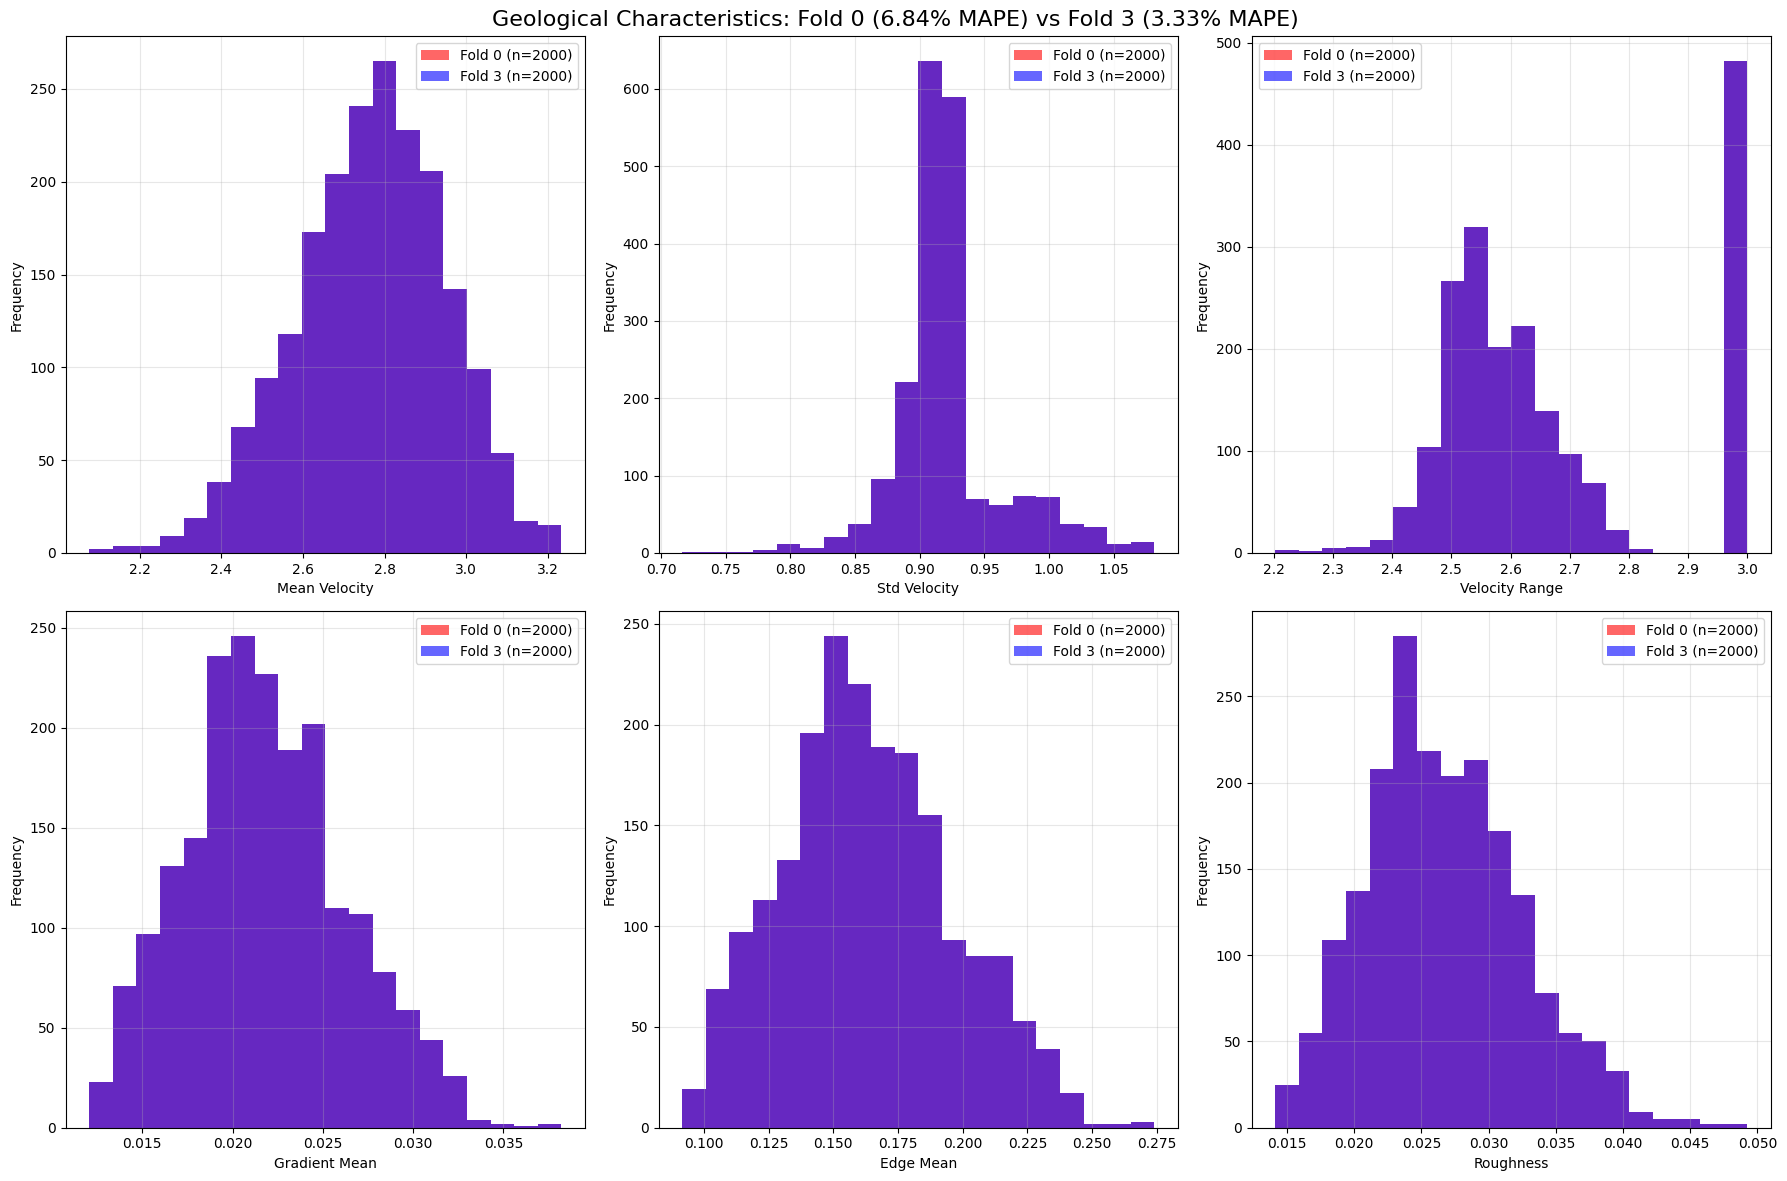


=== Creating Correlation Analysis ===


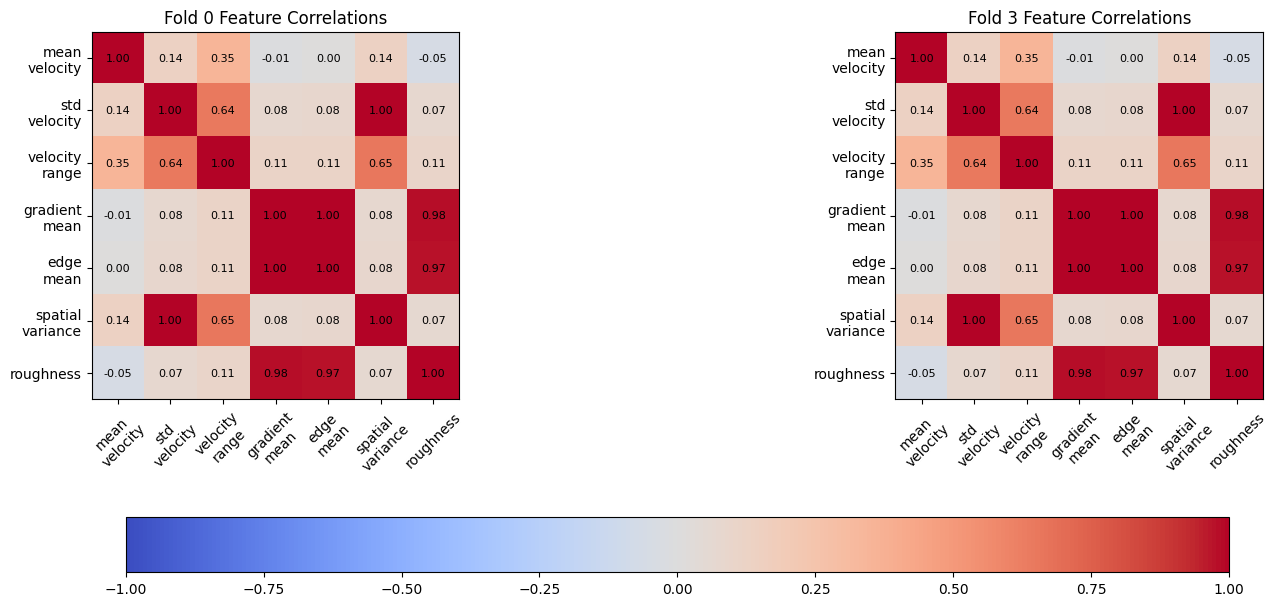


=== Analysis Results Saved ===
Files saved to: /content/drive/MyDrive/ThinkOnward/Result/Phase2b
- fold_basic_statistics.csv
- fold_complexity_metrics.csv
- combined_fold_analysis.csv

=== Key Findings Preview ===
Statistically significant differences found in: 0 metrics
Significant metrics: []


In [ ]:
#Stats Comparison & Visualization

def compare_fold_statistics(basic_df, complexity_df, fold_a=0, fold_b=3):
    """Compare statistical distributions between two folds"""

    print(f"\n=== Statistical Comparison: Fold {fold_a} vs Fold {fold_b} ===")

    # Filter data for each fold
    fold_a_basic = basic_df[basic_df['fold'] == fold_a]
    fold_b_basic = basic_df[basic_df['fold'] == fold_b]
    fold_a_complex = complexity_df[complexity_df['fold'] == fold_a]
    fold_b_complex = complexity_df[complexity_df['fold'] == fold_b]

    print(f"Fold {fold_a} samples: {len(fold_a_basic)}")
    print(f"Fold {fold_b} samples: {len(fold_b_basic)}")

    # Basic statistics comparison
    basic_metrics = ['mean_velocity', 'std_velocity', 'velocity_range', 'median_velocity']
    complexity_metrics = ['gradient_mean', 'edge_mean', 'spatial_variance', 'roughness', 'texture_contrast']

    print(f"\n--- Basic Velocity Statistics ---")
    comparison_results = {}

    for metric in basic_metrics:
        fold_a_vals = fold_a_basic[metric].values
        fold_b_vals = fold_b_basic[metric].values

        # Statistical comparison
        from scipy import stats
        statistic, p_value = stats.mannwhitneyu(fold_a_vals, fold_b_vals, alternative='two-sided')

        # Summary statistics
        fold_a_mean = np.mean(fold_a_vals)
        fold_b_mean = np.mean(fold_b_vals)
        fold_a_std = np.std(fold_a_vals)
        fold_b_std = np.std(fold_b_vals)

        comparison_results[metric] = {
            'fold_a_mean': fold_a_mean,
            'fold_b_mean': fold_b_mean,
            'fold_a_std': fold_a_std,
            'fold_b_std': fold_b_std,
            'p_value': p_value,
            'significant': p_value < 0.05
        }

        print(f"{metric}:")
        print(f"  Fold {fold_a}: {fold_a_mean:.4f} ± {fold_a_std:.4f}")
        print(f"  Fold {fold_b}: {fold_b_mean:.4f} ± {fold_b_std:.4f}")
        print(f"  P-value: {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}")

    print(f"\n--- Geological Complexity Statistics ---")

    for metric in complexity_metrics:
        fold_a_vals = fold_a_complex[metric].values
        fold_b_vals = fold_b_complex[metric].values

        # Statistical comparison
        statistic, p_value = stats.mannwhitneyu(fold_a_vals, fold_b_vals, alternative='two-sided')

        # Summary statistics
        fold_a_mean = np.mean(fold_a_vals)
        fold_b_mean = np.mean(fold_b_vals)
        fold_a_std = np.std(fold_a_vals)
        fold_b_std = np.std(fold_b_vals)

        comparison_results[metric] = {
            'fold_a_mean': fold_a_mean,
            'fold_b_mean': fold_b_mean,
            'fold_a_std': fold_a_std,
            'fold_b_std': fold_b_std,
            'p_value': p_value,
            'significant': p_value < 0.05
        }

        print(f"{metric}:")
        print(f"  Fold {fold_a}: {fold_a_mean:.6f} ± {fold_a_std:.6f}")
        print(f"  Fold {fold_b}: {fold_b_mean:.6f} ± {fold_b_std:.6f}")
        print(f"  P-value: {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}")

    return comparison_results

def create_comparison_visualizations(basic_df, complexity_df, fold_a=0, fold_b=3):
    """Create visualizations comparing the two folds"""
    result_dir = Path('/content/drive/MyDrive/ThinkOnward/Result/Phase2b')

    # Set up the plotting style
    plt.style.use('default')

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Geological Characteristics: Fold {fold_a} (6.84% MAPE) vs Fold {fold_b} (3.33% MAPE)', fontsize=16)

    # Basic statistics plots
    basic_metrics = ['mean_velocity', 'std_velocity', 'velocity_range']

    for i, metric in enumerate(basic_metrics):
        ax = axes[0, i]

        # Data for each fold
        fold_a_data = basic_df[basic_df['fold'] == fold_a][metric]
        fold_b_data = basic_df[basic_df['fold'] == fold_b][metric]

        # Create histogram
        ax.hist(fold_a_data, alpha=0.6, label=f'Fold {fold_a} (n={len(fold_a_data)})', bins=20, color='red')
        ax.hist(fold_b_data, alpha=0.6, label=f'Fold {fold_b} (n={len(fold_b_data)})', bins=20, color='blue')

        ax.set_xlabel(metric.replace('_', ' ').title())
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Complexity metrics plots
    complexity_metrics = ['gradient_mean', 'edge_mean', 'roughness']
    histogram_filename = result_dir / "histogram.png"

    for i, metric in enumerate(complexity_metrics):
        ax = axes[1, i]

        # Data for each fold
        fold_a_data = complexity_df[complexity_df['fold'] == fold_a][metric]
        fold_b_data = complexity_df[complexity_df['fold'] == fold_b][metric]

        # Create histogram
        ax.hist(fold_a_data, alpha=0.6, label=f'Fold {fold_a} (n={len(fold_a_data)})', bins=20, color='red')
        ax.hist(fold_b_data, alpha=0.6, label=f'Fold {fold_b} (n={len(fold_b_data)})', bins=20, color='blue')

        ax.set_xlabel(metric.replace('_', ' ').title())
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(histogram_filename)
    plt.show()

    # Create correlation heatmap
    print(f"\n=== Creating Correlation Analysis ===")
    heatmap_filename = result_dir / "heatmap.png"
    # Combine basic and complexity metrics
    combined_df = basic_df.merge(complexity_df, on=['sample_idx', 'fold'])

    # Select key metrics for correlation
    correlation_metrics = ['mean_velocity', 'std_velocity', 'velocity_range',
                          'gradient_mean', 'edge_mean', 'spatial_variance', 'roughness']

    # Create separate correlation matrices for each fold
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    for i, fold_num in enumerate([fold_a, fold_b]):
        fold_data = combined_df[combined_df['fold'] == fold_num][correlation_metrics]
        correlation_matrix = fold_data.corr()

        # Create heatmap
        im = axes[i].imshow(correlation_matrix.values, cmap='coolwarm', vmin=-1, vmax=1)
        axes[i].set_title(f'Fold {fold_num} Feature Correlations')
        axes[i].set_xticks(range(len(correlation_metrics)))
        axes[i].set_yticks(range(len(correlation_metrics)))
        axes[i].set_xticklabels([m.replace('_', '\n') for m in correlation_metrics], rotation=45)
        axes[i].set_yticklabels([m.replace('_', '\n') for m in correlation_metrics])

        # Add correlation values
        for x in range(len(correlation_metrics)):
            for y in range(len(correlation_metrics)):
                axes[i].text(x, y, f'{correlation_matrix.iloc[y, x]:.2f}',
                           ha='center', va='center', fontsize=8)

    # Add colorbar
    fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, shrink=0.8)
    plt.savefig(heatmap_filename)
    plt.show()


    return combined_df

# Run statistical comparison
comparison_results = compare_fold_statistics(basic_stats_df, complexity_df, fold_a=0, fold_b=3)

# Create visualizations
combined_analysis_df = create_comparison_visualizations(basic_stats_df, complexity_df, fold_a=0, fold_b=3)

# Save analysis results
analysis_results = {
    'basic_statistics': basic_stats_df,
    'complexity_metrics': complexity_df,
    'combined_analysis': combined_analysis_df,
    'statistical_comparison': comparison_results,
    'fold_samples': fold_samples
}

# Save to files for further analysis
basic_stats_df.to_csv(result_dir / 'fold_basic_statistics.csv', index=False)
complexity_df.to_csv(result_dir / 'fold_complexity_metrics.csv', index=False)
combined_analysis_df.to_csv(result_dir / 'combined_fold_analysis.csv', index=False)

print(f"\n=== Analysis Results Saved ===")
print(f"Files saved to: {result_dir}")
print(f"- fold_basic_statistics.csv")
print(f"- fold_complexity_metrics.csv")
print(f"- combined_fold_analysis.csv")

print(f"\n=== Key Findings Preview ===")
significant_differences = [metric for metric, results in comparison_results.items() if results['significant']]
print(f"Statistically significant differences found in: {len(significant_differences)} metrics")
print(f"Significant metrics: {significant_differences}")

In [ ]:
class KFoldCrossValidator:
    def __init__(self, data_dir, result_dir, k_folds=5):
        self.data_dir = Path(data_dir)
        self.result_dir = Path(result_dir)
        self.k_folds = k_folds
        self.fold_results = []
        self.best_models = []

        # Create results directory
        self.result_dir.mkdir(parents=True, exist_ok=True)

    def create_data_splits(self, dataset_size=2000):
        """Create K-fold splits from training data indices"""
        indices = np.arange(1, dataset_size + 1)  # 1 to 2000 for TrainingData_<i>
        kfold = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)

        splits = []
        for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
            # Convert back to sample indices (1-based)
            train_samples = indices[train_idx]
            val_samples = indices[val_idx]

            splits.append({
                'fold': fold,
                'train_indices': train_samples,
                'val_indices': val_samples,
                'train_size': len(train_samples),
                'val_size': len(val_samples)
            })
            print(f"Fold {fold}: Train={len(train_samples)}, Val={len(val_samples)}")

        return splits

    def train_single_fold(self, fold_info, batch_size=8, num_epochs=50, learning_rate=LEARNING_RATE):
        """Train a single fold from scratch using your training function style"""
        fold_num = fold_info['fold']
        print(f"\n=== Training Fold {fold_num} ===")

        # Create fresh model instance
        model = UNet(in_channels=5, out_channels=1, use_adaptive=USE_ADAPTIVE_MODEL)
        model.to(DEVICE)

        # Create dataset and data loaders using your dataset class
        train_dataset = SeismicDataset(self.data_dir, fold_info['train_indices'], use_adaptive=USE_ADAPTIVE_MODEL)
        val_dataset = SeismicDataset(self.data_dir, fold_info['val_indices'], use_adaptive=USE_ADAPTIVE_MODEL)

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        # Setup training (matching your style)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

        # Training tracking
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_model_path = self.result_dir / f'best_model_fold_{fold_num}.pth'

        for epoch in range(num_epochs):
            # Training phase (matching your debug style)
            model.train()
            train_loss = 0.0
            train_progress = tqdm(train_loader, desc=f'Fold {fold_num} Epoch {epoch+1}/{num_epochs} [Train]')

            for batch_idx, (inputs, targets) in enumerate(train_progress):
                try:
                    # Debug for first few batches
                    if DEBUG_ACTIVE and batch_idx < 3:
                        print(f"\n*** DEBUG Fold {fold_num} Batch {batch_idx}: Input shape: {inputs.shape}, Target shape: {targets.shape} ***\n")
                        if torch.cuda.is_available():
                            print(f"*** DEBUG: GPU memory before forward: {torch.cuda.memory_allocated()/1e9:.2f}GB ***\n")

                    if DEBUG_ACTIVE and fold_num != 0:
                      # Check if data loading is the issue
                      print(f"\n*** DEBUG: Batch {batch_idx} - Data loaded successfully ***")

                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                    targets = targets.unsqueeze(1)  # Add channel dimension
                    if DEBUG_ACTIVE and fold_num != 0:
                      print(f"*** DEBUG: Batch {batch_idx} - Data moved to GPU ***")

                    optimizer.zero_grad()
                    if DEBUG_ACTIVE and fold_num != 0 :
                       print(f"*** DEBUG: Batch {batch_idx} - Optimizer zeroed ***")

                    outputs = model(inputs)
                    if DEBUG_ACTIVE and fold_num != 0:
                       print(f"*** DEBUG: Batch {batch_idx} - Forward pass complete ***")

                    loss = mape_loss(outputs, targets)
                    if DEBUG_ACTIVE and fold_num != 0:
                       print(f"*** DEBUG: Batch {batch_idx} - Loss calculated: {loss.item():.4f} ***")

                    loss.backward()
                    if DEBUG_ACTIVE and fold_num != 0:
                       print(f"*** DEBUG: Batch {batch_idx} - Backward pass complete ***")

                    optimizer.step()
                    if DEBUG_ACTIVE and fold_num != 0:
                      print(f"*** DEBUG: Batch {batch_idx} - Optimizer step complete ***")

                    train_loss += loss.item()
                    train_progress.set_postfix({'Loss': f'{loss.item():.4f}'})

                    # Debug progress
                    if batch_idx % 10 == 0:
                      torch.cuda.empty_cache()
                      print(f"*** DEBUG: Batch {batch_idx} COMPLETED - Memory cleared ***")

                except Exception as e:
                    print(f"*** ERROR in Fold {fold_num} batch {batch_idx}: {str(e)} ***")
                    raise e

            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_batch_count = 0

            with torch.no_grad():
                val_progress = tqdm(val_loader, desc=f'Fold {fold_num} Epoch {epoch+1}/{num_epochs} [Val]')

                for batch_idx, (inputs, targets) in enumerate(val_progress):
                    try:
                        if DEBUG_ACTIVE and fold_num != 0:
                          print(f"\n*** DEBUG: Validation batch {batch_idx} starting ***")

                        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                        targets = targets.unsqueeze(1)

                        outputs = model(inputs)
                        loss = mape_loss(outputs, targets)
                        val_loss += loss.item()
                        val_batch_count += 1
                        val_progress.set_postfix({'Loss': f'{loss.item():.4f}'})

                        if DEBUG_ACTIVE and fold_num != 0:
                          print(f"*** DEBUG: Validation batch {batch_idx} completed ***")

                        if batch_idx % 5 == 0:
                          torch.cuda.empty_cache()

                    except Exception as e:
                        print(f"*** ERROR in Fold {fold_num} validation batch {batch_idx}: {str(e)} ***")
                        raise e

            avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')
            val_losses.append(avg_val_loss)

            scheduler.step(avg_val_loss)

            print(f'Fold {fold_num} Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train MAPE: {avg_train_loss:.4f}%')
            print(f'  Val MAPE: {avg_val_loss:.4f}%')
            print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
            print('-' * 50)

            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'val_loss': best_val_loss,
                    'fold': fold_num
                }, best_model_path)
                print(f'Fold {fold_num}: New best model saved with Val MAPE = {best_val_loss:.4f}%')

            # Early stopping
            if optimizer.param_groups[0]['lr'] < 1e-7:
                print(f'Fold {fold_num}: Early stopping due to low learning rate')
                break

        # Clean up GPU memory
        del model, optimizer, scheduler
        torch.cuda.empty_cache()
        gc.collect()

        return {
            'fold': fold_num,
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'model_path': best_model_path
        }

    def run_cross_validation(self, batch_size=8, num_epochs=50, learning_rate=1e-4):
        """Run complete K-fold cross-validation"""
        print(f"Starting {self.k_folds}-Fold Cross-Validation")

        # Create data splits
        splits = self.create_data_splits()

        # Train each fold
        for fold_info in splits:
            fold_result = self.train_single_fold(
                fold_info,
                batch_size=batch_size,
                num_epochs=num_epochs,
                learning_rate=learning_rate
            )
            self.fold_results.append(fold_result)

            print(f"Fold {fold_result['fold']} completed with Val MAPE: {fold_result['best_val_loss']:.4f}%")

        # Analyze results
        self.analyze_cv_results()

        return self.fold_results

    def analyze_cv_results(self):
        """Analyze cross-validation results and identify best models"""
        val_scores = [result['best_val_loss'] for result in self.fold_results]

        mean_score = np.mean(val_scores)
        std_score = np.std(val_scores)
        best_fold = np.argmin(val_scores)

        print(f"\n=== Cross-Validation Results ===")
        print(f"Mean Val MAPE: {mean_score:.4f}% ± {std_score:.4f}%")
        print(f"Best Fold: {best_fold} with Val MAPE: {val_scores[best_fold]:.4f}%")
        print(f"Individual Fold Scores: {[f'{score:.4f}%' for score in val_scores]}")

        # Save results
        results_file = self.result_dir / 'cv_results.txt'
        with open(results_file, 'w') as f:
            f.write(f"K-Fold Cross-Validation Results (k={self.k_folds})\n")
            f.write(f"Mean Val MAPE: {mean_score:.4f}% ± {std_score:.4f}%\n")
            f.write(f"Best Fold: {best_fold} with Val MAPE: {val_scores[best_fold]:.4f}%\n")
            for i, score in enumerate(val_scores):
                f.write(f"Fold {i}: {score:.4f}%\n")

        return {
            'mean_score': mean_score,
            'std_score': std_score,
            'best_fold': best_fold,
            'best_score': val_scores[best_fold]
        }

    def create_ensemble_model(self, top_k=ENSEMBLE_SIZE):
        """Create ensemble from top k performing folds"""
        # Sort folds by validation performance
        sorted_folds = sorted(self.fold_results, key=lambda x: x['best_val_loss'])
        top_folds = sorted_folds[:top_k]

        print(f"\nCreating ensemble from top {top_k} folds:")
        for i, fold in enumerate(top_folds):
            print(f"  {i+1}. Fold {fold['fold']}: {fold['best_val_loss']:.4f}%")

        # Load top models
        ensemble_models = []

        for fold in top_folds:
            model = UNet(in_channels=5, out_channels=1, use_adaptive=True)
            checkpoint = torch.load(fold['model_path'], map_location=DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(DEVICE)
            model.eval()
            ensemble_models.append(model)

        return ensemble_models, [fold['best_val_loss'] for fold in top_folds]

    def create_all_folds_ensemble(self):
        """Create ensemble from ALL folds (for comparison)"""
        print(f"\nCreating ensemble from ALL {len(self.fold_results)} folds:")
        for i, fold in enumerate(self.fold_results):
            print(f"  {i+1}. Fold {fold['fold']}: {fold['best_val_loss']:.4f}%")

        # Load ALL models
        ensemble_models = []

        for fold in self.fold_results:
            model = UNet(in_channels=5, out_channels=1, use_adaptive=True)
            checkpoint = torch.load(fold['model_path'], map_location=DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(DEVICE)
            model.eval()
            ensemble_models.append(model)

        # Equal weights for simple averaging
        equal_weights = [1.0] * len(self.fold_results)

        return ensemble_models, equal_weights

    def create_weighted_all_folds_ensemble(self):
        """Create ensemble from ALL folds with inverse-loss weighting"""
        print(f"\nCreating WEIGHTED ensemble from ALL {len(self.fold_results)} folds:")

        # Load ALL models
        ensemble_models = []
        fold_losses = []

        for fold in self.fold_results:
            model = UNet(in_channels=5, out_channels=1, use_adaptive=True)
            checkpoint = torch.load(fold['model_path'], map_location=DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(DEVICE)
            model.eval()
            ensemble_models.append(model)
            fold_losses.append(fold['best_val_loss'])
            print(f"  Fold {fold['fold']}: {fold['best_val_loss']:.4f}%")

        return ensemble_models, fold_losses

In [ ]:
class TestInferencePipeline:
    def __init__(self, test_dir):
        self.test_dir = Path(test_dir)
        self.device = DEVICE
        self.receiver_files = [
            'receiver_data_src_1.npy',
            'receiver_data_src_75.npy',
            'receiver_data_src_150.npy',
            'receiver_data_src_225.npy',
            'receiver_data_src_300.npy'
        ]

    def load_test_sample(self, sample_id):
        """Load a single test sample (5 receiver files) - matching your preprocessing exactly"""
        sample_dir = self.test_dir / f"TestData_{sample_id}"

        # Load the 5 receiver files
        receiver_data = []
        for file_name in self.receiver_files:
            file_path = sample_dir / file_name
            if not file_path.exists():
                raise FileNotFoundError(f"Missing file: {file_path}")

            data = np.load(file_path).astype(np.float32)  # (10001, 31)
            receiver_data.append(data)

        # Apply EXACT same preprocessing as your SeismicDataset adaptive processing
        processed_inputs = []
        for data in receiver_data:
            # 1D conv + maxpool simulation using numpy
            # Downsample from 10001 to ~313 (factor of ~32)
            downsampled = data[::32, :]  # (313, 31)

            # Zero pad from 31 to 32 channels
            if downsampled.shape[1] == 31:
                padded = np.pad(downsampled, ((0, 0), (0, 1)), mode='constant')  # (313, 32)
            else:
                padded = downsampled

            # Reshape to make it more compact 2D
            # We'll treat this as (313, 32) for now and let the model handle it
            processed_inputs.append(padded.T)  # (32, 313) for easier processing

        # Stack all 5 processed inputs
        input_tensor = np.stack(processed_inputs, axis=0)  # (5, 32, 313)

        return torch.from_numpy(input_tensor)

    def predict_single_model(self, model, input_tensor):
        """Generate prediction using a single model"""
        model.eval()
        with torch.no_grad():
            if len(input_tensor.shape) == 3:
                input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

            input_tensor = input_tensor.to(self.device, non_blocking=True)
            prediction = model(input_tensor)

            # Ensure output is float64 and correct shape
            prediction = prediction.cpu().numpy().astype(np.float64)

            # Remove batch dimension and verify shape
            prediction = prediction.squeeze()
            if prediction.shape != (300, 1259):
                raise ValueError(f"Prediction shape {prediction.shape} doesn't match required (300, 1259)")

            return prediction

    def predict_ensemble(self, models, weights, input_tensor):
        """Generate ensemble prediction with weighted averaging"""
        predictions = []

        for model in models:
            pred = self.predict_single_model(model, input_tensor)
            predictions.append(pred)

        # Handle different weight types
        if all(w == 1.0 for w in weights):
            # Simple averaging (all weights are 1.0)
            ensemble_pred = np.mean(predictions, axis=0)
        else:
            # Weighted average (using inverse loss as weights)
            ensemble_pred = np.zeros_like(predictions[0])
            # Convert MAPE losses to weights (lower loss = higher weight)
            inv_weights = [1.0 / (w + 1e-8) for w in weights]
            total_weight = sum(inv_weights)

            for pred, weight in zip(predictions, inv_weights):
                ensemble_pred += pred * (weight / total_weight)

        return ensemble_pred.astype(np.float64)

    def generate_submission(self, model_or_ensemble, output_path, batch_size=4, weights=None):
        """Generate complete test submission file"""
        print(f"Generating test predictions for TestData_1 to TestData_150...")

        predictions = {}

        # Determine if single model or ensemble
        is_ensemble = isinstance(model_or_ensemble, list)
        if is_ensemble and weights is None:
            weights = [1.0] * len(model_or_ensemble)  # Equal weights if not provided

        # Process samples individually (easier for debugging)
        for sample_id in tqdm(range(1, 151), desc="Processing test samples"):
            try:
                # Load and preprocess single sample
                sample_data = self.load_test_sample(sample_id)

                # Generate prediction
                if is_ensemble:
                    pred = self.predict_ensemble(model_or_ensemble, weights, sample_data)
                else:
                    pred = self.predict_single_model(model_or_ensemble, sample_data)

                # Store with correct naming convention
                predictions[f"TestData_{sample_id}"] = pred

            except Exception as e:
                print(f"Error processing TestData_{sample_id}: {e}")
                continue

        # Save submission file
        output_path = Path(output_path)
        np.savez_compressed(output_path, **predictions)

        print(f"Submission file saved: {output_path}")
        print(f"Generated predictions for {len(predictions)} test samples")

        # Verify submission format
        self.verify_submission(output_path)

        return predictions

    def verify_submission(self, submission_path):
        """Verify submission file format"""
        data = np.load(submission_path)

        print(f"\n=== Submission Verification ===")
        print(f"Total samples: {len(data.files)}")

        # Check a few samples
        for i, key in enumerate(sorted(data.files)[:5]):
            pred = data[key]
            print(f"  {key}: shape={pred.shape}, dtype={pred.dtype}")

            # Verify requirements
            assert pred.shape == (300, 1259), f"Wrong shape for {key}: {pred.shape}"
            assert pred.dtype == np.float64, f"Wrong dtype for {key}: {pred.dtype}"

        print("✓ Submission format verified!")

In [ ]:
# Main execution functions
def run_kfold_cv(data_dir, result_dir, k_folds=K_FOLDS):
    """Run K-fold cross-validation"""
    cv = KFoldCrossValidator(
        data_dir=data_dir,
        result_dir=result_dir,
        k_folds=k_folds
    )

    # Run cross-validation with Phase 1 settings
    fold_results = cv.run_cross_validation(
        batch_size=BATCH_SIZE,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE
    )

    # Create ensemble from top folds
    ensemble_models, ensemble_weights = cv.create_ensemble_model(top_k=ENSEMBLE_SIZE)

    return cv, ensemble_models, ensemble_weights

def generate_test_submission(test_dir, models, weights, output_path):

    """Generate test submission using ensemble"""
    pipeline = TestInferencePipeline(test_dir)

    predictions = pipeline.generate_submission(
        model_or_ensemble=models,
        output_path=output_path,
        weights=weights
    )

    return predictions

In [ ]:
# Main execution ADAPTIVE K-Fold
if __name__ == "__main__":

    # Set data directory
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = Path('/content/drive/MyDrive/ThinkOnward/Data/Train')  # Adjust path as needed
    result_dir= Path('/content/drive/MyDrive/ThinkOnward/Result/Phase2a')
    test_dir = Path('/content/drive/MyDrive/ThinkOnward/Data/Test')

    print("=== Phase 2a: K-Fold CV + Test Inference ===")

    # Step 1: Run K-Fold Cross-Validation
    print("Step 1: Running K-Fold Cross-Validation...")
    cv, ensemble_models, ensemble_weights = run_kfold_cv(
        data_dir=data_dir,
        result_dir=result_dir,
        k_folds=K_FOLDS
    )

     # Step 2: Create and test ALL ensemble approaches
    print("\n" + "="*60)
    print("Step 2: Comparing Different Ensemble Strategies")
    print("="*60)

    # Ensemble 1: Top 3 folds (current approach)
    print("\n🏆 Ensemble 1: Top 3 Folds (Weighted)")
    top3_models, top3_weights = cv.create_ensemble_model(top_k=3)

    # Ensemble 2: All 5 folds (simple averaging)
    print("\n📊 Ensemble 2: All 5 Folds (Simple Average)")
    all5_models, all5_weights = cv.create_all_folds_ensemble()

    # Ensemble 3: All 5 folds (weighted averaging)
    print("\n⚖️ Ensemble 3: All 5 Folds (Weighted Average)")
    all5_weighted_models, all5_weighted_weights = cv.create_weighted_all_folds_ensemble()

    # Step 3: Generate submissions for all approaches
    print("\n" + "="*60)
    print("Step 3: Generating Test Submissions")
    print("="*60)

    # Submission 1: Top 3 weighted
    print("\n🔄 Generating Top 3 Ensemble submission...")
    submission1_path = result_dir / 'submission_top3_weighted.npz'
    predictions1 = generate_test_submission(
        test_dir=test_dir,
        models=top3_models,
        weights=top3_weights,
        output_path=submission1_path
    )

    # Submission 2: All 5 simple average
    print("\n🔄 Generating All 5 Simple Average submission...")
    submission2_path = result_dir / 'submission_all5_simple.npz'
    predictions2 = generate_test_submission(
        test_dir=test_dir,
        models=all5_models,
        weights=all5_weights,  # Equal weights
        output_path=submission2_path
    )

    # Submission 3: All 5 weighted average
    print("\n🔄 Generating All 5 Weighted Average submission...")
    submission3_path = result_dir / 'submission_all5_weighted.npz'
    predictions3 = generate_test_submission(
        test_dir=test_dir,
        models=all5_weighted_models,
        weights=all5_weighted_weights,
        output_path=submission3_path
    )

    # Step 4: Best single model (for comparison)
    print("\n🏅 Generating Best Single Model submission...")
    best_fold_idx = min(range(len(cv.fold_results)), key=lambda i: cv.fold_results[i]['best_val_loss'])
    best_model_path = cv.fold_results[best_fold_idx]['model_path']

    best_model = UNet(in_channels=5, out_channels=1, use_adaptive=True)
    checkpoint = torch.load(best_model_path, map_location=DEVICE)
    best_model.load_state_dict(checkpoint['model_state_dict'])
    best_model.to(DEVICE)
    best_model.eval()

    single_submission_path = result_dir / 'submission_single_best.npz'
    single_predictions = generate_test_submission(
        test_dir=test_dir,
        models=best_model,
        weights=None,
        output_path=single_submission_path
    )

    # Step 5: Summary
    print("\n" + "="*60)
    print("🎯 ENSEMBLE COMPARISON SUMMARY")
    print("="*60)
    print(f"📁 Results saved to: {result_dir}")
    print("\n📊 Cross-Validation Results:")
    cv.analyze_cv_results()
    print(f"\n📋 Generated Submissions:")
    print(f"   1. Top 3 Weighted:      {submission1_path}")
    print(f"   2. All 5 Simple Avg:    {submission2_path}")
    print(f"   3. All 5 Weighted Avg:  {submission3_path}")
    print(f"   4. Best Single Model:   {single_submission_path}")

    print(f"\n🧪 TEST ON LEADERBOARD:")
    print(f"   • Upload all 4 submissions to see which ensemble strategy works best")
    print(f"   • Expected ranking: Single > Top3 > All5_Weighted > All5_Simple")
    print(f"   • If All5 beats Top3, then model diversity > individual quality")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Phase 2a: K-Fold CV + Test Inference ===
Step 1: Running K-Fold Cross-Validation...
Starting 5-Fold Cross-Validation
Fold 0: Train=1600, Val=400
Fold 1: Train=1600, Val=400
Fold 2: Train=1600, Val=400
Fold 3: Train=1600, Val=400
Fold 4: Train=1600, Val=400

=== Training Fold 0 ===


Fold 0 Epoch 1/30 [Train]:   1%|          | 1/100 [00:00<01:12,  1.37it/s, Loss=80.9175]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.53it/s, Loss=66.9912]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.86it/s, Loss=60.0837]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.92it/s, Loss=56.9139]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.77it/s, Loss=54.2247]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.79it/s, Loss=51.7962]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.81it/s, Loss=51.2552]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.95it/s, Loss=48.6143]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.92it/s, Loss=47.3683]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.84it/s, Loss=47.0814]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.66it/s, Loss=55.0031]


Fold 0 Epoch 1/30:
  Train MAPE: 54.9375%
  Val MAPE: 54.0758%
  LR: 0.000100
--------------------------------------------------
Fold 0: New best model saved with Val MAPE = 54.0758%


Fold 0 Epoch 2/30 [Train]:   1%|          | 1/100 [00:01<02:56,  1.78s/it, Loss=46.4250]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.25it/s, Loss=46.0573]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.75it/s, Loss=43.2255]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.75it/s, Loss=43.3576]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=43.3757]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  51%|█████     | 51/100 [00:22<00:18,  2.70it/s, Loss=40.0706]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.44it/s, Loss=40.0700]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.52it/s, Loss=39.3594]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.68it/s, Loss=38.4928]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.92it/s, Loss=36.4929]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s, Loss=32.1335]


Fold 0 Epoch 2/30:
  Train MAPE: 41.2314%
  Val MAPE: 31.3991%
  LR: 0.000100
--------------------------------------------------
Fold 0: New best model saved with Val MAPE = 31.3991%


Fold 0 Epoch 3/30 [Train]:   1%|          | 1/100 [00:01<02:39,  1.61s/it, Loss=36.2895]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  11%|█         | 11/100 [00:04<00:25,  3.43it/s, Loss=34.4447]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.81it/s, Loss=34.5365]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  31%|███       | 31/100 [00:16<01:34,  1.37s/it, Loss=33.3056]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  41%|████      | 41/100 [00:19<00:27,  2.17it/s, Loss=33.6121]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  51%|█████     | 51/100 [00:22<00:15,  3.24it/s, Loss=32.2336]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.67it/s, Loss=31.1342]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.83it/s, Loss=32.0213]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  81%|████████  | 81/100 [00:29<00:04,  3.99it/s, Loss=28.4467]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  4.00it/s, Loss=27.6310]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.87it/s, Loss=43.3100]


Fold 0 Epoch 3/30:
  Train MAPE: 32.1255%
  Val MAPE: 42.3386%
  LR: 0.000100
--------------------------------------------------


Fold 0 Epoch 4/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.57it/s, Loss=25.9705]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.70it/s, Loss=26.5798]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.79it/s, Loss=26.1889]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  4.03it/s, Loss=25.6774]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.99it/s, Loss=23.9107]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.90it/s, Loss=25.9540]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.68it/s, Loss=22.9706]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.80it/s, Loss=23.1662]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.81it/s, Loss=22.4324]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.96it/s, Loss=19.1341]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=43.5152]


Fold 0 Epoch 4/30:
  Train MAPE: 23.8406%
  Val MAPE: 42.5198%
  LR: 0.000100
--------------------------------------------------


Fold 0 Epoch 5/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.44it/s, Loss=20.7760]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.53it/s, Loss=19.6062]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.85it/s, Loss=18.5034]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.88it/s, Loss=17.5720]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.70it/s, Loss=17.6923]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.85it/s, Loss=14.5701]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.84it/s, Loss=13.6398]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.92it/s, Loss=14.3749]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.76it/s, Loss=14.7343]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.84it/s, Loss=13.7925]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.91it/s, Loss=17.2912]


Fold 0 Epoch 5/30:
  Train MAPE: 16.2494%
  Val MAPE: 17.5452%
  LR: 0.000100
--------------------------------------------------
Fold 0: New best model saved with Val MAPE = 17.5452%


Fold 0 Epoch 6/30 [Train]:   1%|          | 1/100 [00:01<02:56,  1.79s/it, Loss=12.2405]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.28it/s, Loss=11.0156]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.85it/s, Loss=11.8595]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.92it/s, Loss=10.0035]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=10.3600]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.74it/s, Loss=10.8687]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.36it/s, Loss=9.1526]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.59it/s, Loss=8.2406]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.68it/s, Loss=7.9915]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.72it/s, Loss=7.0034]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=11.2362]


Fold 0 Epoch 6/30:
  Train MAPE: 9.6876%
  Val MAPE: 11.4443%
  LR: 0.000100
--------------------------------------------------
Fold 0: New best model saved with Val MAPE = 11.4443%


Fold 0 Epoch 7/30 [Train]:   1%|          | 1/100 [00:01<02:57,  1.79s/it, Loss=5.8512]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.41it/s, Loss=6.1701]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.66it/s, Loss=6.9802]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  31%|███       | 31/100 [00:16<01:11,  1.03s/it, Loss=6.4304]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  41%|████      | 41/100 [00:19<00:23,  2.55it/s, Loss=5.7293]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  51%|█████     | 51/100 [00:22<00:13,  3.67it/s, Loss=5.6094]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.90it/s, Loss=5.9075]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.71it/s, Loss=5.3227]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.64it/s, Loss=4.8225]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.75it/s, Loss=6.0279]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s, Loss=13.8581]


Fold 0 Epoch 7/30:
  Train MAPE: 6.0718%
  Val MAPE: 14.7099%
  LR: 0.000100
--------------------------------------------------


Fold 0 Epoch 8/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.49it/s, Loss=5.5956]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.62it/s, Loss=5.2065]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.86it/s, Loss=5.4252]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  31%|███       | 31/100 [00:08<00:16,  4.11it/s, Loss=5.1546]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.04it/s, Loss=4.3874]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.84it/s, Loss=5.6220]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.78it/s, Loss=5.6880]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  4.01it/s, Loss=5.4468]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.81it/s, Loss=5.4210]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.81it/s, Loss=6.1243]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s, Loss=13.6651]


Fold 0 Epoch 8/30:
  Train MAPE: 5.3934%
  Val MAPE: 14.8944%
  LR: 0.000100
--------------------------------------------------


Fold 0 Epoch 9/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.45it/s, Loss=5.9457]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.79it/s, Loss=6.2966]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.81it/s, Loss=5.2059]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.89it/s, Loss=5.1307]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.00it/s, Loss=5.6001]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  4.01it/s, Loss=4.6463]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.84it/s, Loss=5.0374]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.76it/s, Loss=4.9400]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.80it/s, Loss=4.6032]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.96it/s, Loss=5.8917]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=20.7398]


Fold 0 Epoch 9/30:
  Train MAPE: 5.1400%
  Val MAPE: 19.3015%
  LR: 0.000100
--------------------------------------------------


Fold 0 Epoch 10/30 [Train]:   1%|          | 1/100 [00:00<01:01,  1.60it/s, Loss=4.6450]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  11%|█         | 11/100 [00:03<00:22,  3.92it/s, Loss=4.7267]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  21%|██        | 21/100 [00:05<00:19,  4.01it/s, Loss=5.5665]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.85it/s, Loss=4.6204]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:11<00:16,  3.66it/s, Loss=4.6759]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.83it/s, Loss=4.9794]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.89it/s, Loss=6.5163]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.95it/s, Loss=5.1092]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.61it/s, Loss=5.7962]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.75it/s, Loss=5.0869]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=36.5485]


Fold 0 Epoch 10/30:
  Train MAPE: 5.0133%
  Val MAPE: 35.4498%
  LR: 0.000100
--------------------------------------------------


Fold 0 Epoch 11/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.56it/s, Loss=5.0249]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.62it/s, Loss=4.4946]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.82it/s, Loss=4.5614]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.86it/s, Loss=4.6044]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.88it/s, Loss=3.9927]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.74it/s, Loss=4.1655]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.87it/s, Loss=4.7854]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  4.02it/s, Loss=4.9477]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.91it/s, Loss=4.2642]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.88it/s, Loss=4.5377]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s, Loss=23.1071]


Fold 0 Epoch 11/30:
  Train MAPE: 4.6479%
  Val MAPE: 20.7637%
  LR: 0.000100
--------------------------------------------------


Fold 0 Epoch 12/30 [Train]:   1%|          | 1/100 [00:00<01:09,  1.42it/s, Loss=4.6318]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.62it/s, Loss=4.3866]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.81it/s, Loss=4.5686]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.90it/s, Loss=4.4858]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.89it/s, Loss=5.1122]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.97it/s, Loss=4.7587]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.83it/s, Loss=4.8365]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.74it/s, Loss=4.9627]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=4.4939]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.96it/s, Loss=4.4718]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s, Loss=37.1228]


Fold 0 Epoch 12/30:
  Train MAPE: 4.5480%
  Val MAPE: 36.0359%
  LR: 0.000050
--------------------------------------------------


Fold 0 Epoch 13/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.53it/s, Loss=3.8946]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.56it/s, Loss=3.9673]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.88it/s, Loss=4.0688]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.63it/s, Loss=4.0470]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.75it/s, Loss=3.5077]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.87it/s, Loss=3.9450]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.79it/s, Loss=4.0553]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.70it/s, Loss=4.6489]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.60it/s, Loss=3.7309]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.81it/s, Loss=3.6734]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s, Loss=11.5090]


Fold 0 Epoch 13/30:
  Train MAPE: 3.9971%
  Val MAPE: 11.4646%
  LR: 0.000050
--------------------------------------------------


Fold 0 Epoch 14/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=3.8134]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.81it/s, Loss=3.9685]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  21%|██        | 21/100 [00:05<00:19,  3.98it/s, Loss=4.2270]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.95it/s, Loss=4.6456]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.71it/s, Loss=3.4649]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.66it/s, Loss=3.8116]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.93it/s, Loss=3.7801]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.90it/s, Loss=3.1327]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  4.01it/s, Loss=3.8468]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.85it/s, Loss=3.5376]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s, Loss=19.8288]


Fold 0 Epoch 14/30:
  Train MAPE: 3.8954%
  Val MAPE: 19.7311%
  LR: 0.000050
--------------------------------------------------


Fold 0 Epoch 15/30 [Train]:   1%|          | 1/100 [00:00<01:00,  1.62it/s, Loss=3.3972]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.74it/s, Loss=4.1078]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.91it/s, Loss=3.8273]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.89it/s, Loss=3.7772]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.80it/s, Loss=3.5790]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.94it/s, Loss=3.7620]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.62it/s, Loss=3.9929]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  71%|███████   | 71/100 [00:18<00:08,  3.51it/s, Loss=3.4348]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  82%|████████▏ | 82/100 [00:21<00:04,  4.39it/s, Loss=3.8112]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Train]:  92%|█████████▏| 92/100 [00:23<00:01,  4.25it/s, Loss=3.2836]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=16.3105]


Fold 0 Epoch 15/30:
  Train MAPE: 3.8738%
  Val MAPE: 17.8761%
  LR: 0.000050
--------------------------------------------------


Fold 0 Epoch 16/30 [Train]:   1%|          | 1/100 [00:00<01:10,  1.41it/s, Loss=3.8410]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.79it/s, Loss=5.0656]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.88it/s, Loss=3.6414]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  31%|███       | 31/100 [00:08<00:19,  3.61it/s, Loss=3.6918]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.71it/s, Loss=3.8027]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.88it/s, Loss=3.6182]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.85it/s, Loss=3.8205]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.76it/s, Loss=4.1298]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.67it/s, Loss=3.5533]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.80it/s, Loss=3.5629]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.66it/s, Loss=14.0658]


Fold 0 Epoch 16/30:
  Train MAPE: 3.8250%
  Val MAPE: 15.5132%
  LR: 0.000050
--------------------------------------------------


Fold 0 Epoch 17/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.55it/s, Loss=4.1811]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.64it/s, Loss=3.5309]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.93it/s, Loss=3.6652]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  32%|███▏      | 32/100 [00:08<00:15,  4.33it/s, Loss=3.9423]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.75it/s, Loss=4.2171]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.80it/s, Loss=3.7189]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  62%|██████▏   | 62/100 [00:16<00:08,  4.36it/s, Loss=3.2676]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  72%|███████▏  | 72/100 [00:18<00:06,  4.35it/s, Loss=3.5353]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  82%|████████▏ | 82/100 [00:21<00:04,  4.25it/s, Loss=3.3980]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Train]:  92%|█████████▏| 92/100 [00:23<00:02,  3.91it/s, Loss=3.8967]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s, Loss=19.7341]


Fold 0 Epoch 17/30:
  Train MAPE: 3.7889%
  Val MAPE: 19.1047%
  LR: 0.000050
--------------------------------------------------


Fold 0 Epoch 18/30 [Train]:   1%|          | 1/100 [00:00<01:00,  1.64it/s, Loss=3.4950]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.56it/s, Loss=3.6515]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.84it/s, Loss=3.5395]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.86it/s, Loss=3.6888]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.90it/s, Loss=3.5430]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.95it/s, Loss=3.9663]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.69it/s, Loss=3.2256]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.85it/s, Loss=4.2303]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.76it/s, Loss=3.5616]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.92it/s, Loss=3.6644]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.62it/s, Loss=35.3906]


Fold 0 Epoch 18/30:
  Train MAPE: 3.6942%
  Val MAPE: 34.2412%
  LR: 0.000025
--------------------------------------------------


Fold 0 Epoch 19/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.60it/s, Loss=3.5303]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.84it/s, Loss=3.6012]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.92it/s, Loss=3.9415]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.79it/s, Loss=3.3826]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.00it/s, Loss=3.6919]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.88it/s, Loss=4.5414]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  61%|██████    | 61/100 [00:15<00:09,  3.98it/s, Loss=3.8038]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  72%|███████▏  | 72/100 [00:18<00:06,  4.36it/s, Loss=3.6083]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  82%|████████▏ | 82/100 [00:21<00:04,  4.25it/s, Loss=3.5079]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Train]:  92%|█████████▏| 92/100 [00:23<00:01,  4.12it/s, Loss=3.5326]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s, Loss=16.3380]


Fold 0 Epoch 19/30:
  Train MAPE: 3.6536%
  Val MAPE: 16.1200%
  LR: 0.000025
--------------------------------------------------


Fold 0 Epoch 20/30 [Train]:   1%|          | 1/100 [00:00<01:07,  1.48it/s, Loss=3.5745]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.65it/s, Loss=3.9017]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.87it/s, Loss=3.2641]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.79it/s, Loss=3.6972]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.86it/s, Loss=3.2536]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.86it/s, Loss=3.2912]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.73it/s, Loss=3.6050]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.75it/s, Loss=3.6417]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=3.8612]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.77it/s, Loss=3.7273]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=22.5052]


Fold 0 Epoch 20/30:
  Train MAPE: 3.6187%
  Val MAPE: 24.4577%
  LR: 0.000025
--------------------------------------------------


Fold 0 Epoch 21/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=4.1035]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.56it/s, Loss=3.4469]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.85it/s, Loss=3.6147]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.79it/s, Loss=3.5453]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.84it/s, Loss=3.4640]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.84it/s, Loss=3.4449]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.83it/s, Loss=3.7726]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.88it/s, Loss=4.5424]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.96it/s, Loss=3.2917]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.94it/s, Loss=3.4587]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s, Loss=21.8014]


Fold 0 Epoch 21/30:
  Train MAPE: 3.6229%
  Val MAPE: 23.7449%
  LR: 0.000025
--------------------------------------------------


Fold 0 Epoch 22/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.58it/s, Loss=3.4512]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.69it/s, Loss=3.4694]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.81it/s, Loss=3.3562]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.99it/s, Loss=3.5098]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.93it/s, Loss=4.4059]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.91it/s, Loss=3.6391]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  62%|██████▏   | 62/100 [00:15<00:08,  4.49it/s, Loss=3.4588]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.83it/s, Loss=3.2947]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.79it/s, Loss=4.6917]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.83it/s, Loss=3.2324]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s, Loss=31.0903]


Fold 0 Epoch 22/30:
  Train MAPE: 3.5785%
  Val MAPE: 30.0019%
  LR: 0.000025
--------------------------------------------------


Fold 0 Epoch 23/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.57it/s, Loss=4.8088]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.81it/s, Loss=3.6170]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.91it/s, Loss=3.7290]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.88it/s, Loss=3.2477]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.76it/s, Loss=3.6308]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.78it/s, Loss=3.1219]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.71it/s, Loss=3.1116]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.83it/s, Loss=3.1077]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=3.0551]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.72it/s, Loss=3.6084]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Loss=34.4525]


Fold 0 Epoch 23/30:
  Train MAPE: 3.5386%
  Val MAPE: 33.4176%
  LR: 0.000025
--------------------------------------------------


Fold 0 Epoch 24/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.52it/s, Loss=3.3716]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.65it/s, Loss=3.6666]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  21%|██        | 21/100 [00:05<00:19,  4.05it/s, Loss=3.9058]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.88it/s, Loss=3.5335]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.88it/s, Loss=3.1295]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.81it/s, Loss=3.2347]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.90it/s, Loss=3.1634]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  72%|███████▏  | 72/100 [00:18<00:06,  4.49it/s, Loss=3.3403]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.87it/s, Loss=3.5712]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.78it/s, Loss=4.7980]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Loss=20.0658]


Fold 0 Epoch 24/30:
  Train MAPE: 3.5655%
  Val MAPE: 21.9118%
  LR: 0.000013
--------------------------------------------------


Fold 0 Epoch 25/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.45it/s, Loss=4.1832]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.51it/s, Loss=3.1035]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.78it/s, Loss=3.2279]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.82it/s, Loss=3.3905]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.77it/s, Loss=3.3199]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.73it/s, Loss=3.1805]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.69it/s, Loss=3.6819]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.73it/s, Loss=3.6166]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.64it/s, Loss=3.3572]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=2.9687]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=6.5876]


Fold 0 Epoch 25/30:
  Train MAPE: 3.4914%
  Val MAPE: 6.8394%
  LR: 0.000013
--------------------------------------------------
Fold 0: New best model saved with Val MAPE = 6.8394%


Fold 0 Epoch 26/30 [Train]:   1%|          | 1/100 [00:01<02:54,  1.76s/it, Loss=3.3054]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.29it/s, Loss=3.9858]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.71it/s, Loss=3.1864]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.66it/s, Loss=3.1115]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.56it/s, Loss=3.3848]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  2.99it/s, Loss=3.0341]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.67it/s, Loss=3.2392]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.78it/s, Loss=3.0454]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.67it/s, Loss=3.5732]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.74it/s, Loss=3.3663]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=33.4887]


Fold 0 Epoch 26/30:
  Train MAPE: 3.3834%
  Val MAPE: 32.1976%
  LR: 0.000013
--------------------------------------------------


Fold 0 Epoch 27/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.52it/s, Loss=3.3161]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.62it/s, Loss=3.0591]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.83it/s, Loss=3.5998]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.80it/s, Loss=3.3104]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.88it/s, Loss=3.2307]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.78it/s, Loss=3.4166]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.68it/s, Loss=3.2605]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  71%|███████   | 71/100 [00:19<00:08,  3.59it/s, Loss=3.5195]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.87it/s, Loss=3.0704]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.91it/s, Loss=4.1039]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s, Loss=10.2456]


Fold 0 Epoch 27/30:
  Train MAPE: 3.4122%
  Val MAPE: 10.2068%
  LR: 0.000013
--------------------------------------------------


Fold 0 Epoch 28/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=3.2593]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.73it/s, Loss=3.4629]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.94it/s, Loss=3.2888]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.77it/s, Loss=3.4256]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.87it/s, Loss=4.2774]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.89it/s, Loss=3.4063]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.92it/s, Loss=3.4101]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.81it/s, Loss=3.1350]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.74it/s, Loss=3.3104]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.79it/s, Loss=2.9004]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=20.7066]


Fold 0 Epoch 28/30:
  Train MAPE: 3.4198%
  Val MAPE: 22.6250%
  LR: 0.000013
--------------------------------------------------


Fold 0 Epoch 29/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.56it/s, Loss=3.4184]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.65it/s, Loss=3.5848]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.80it/s, Loss=3.0991]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.80it/s, Loss=3.2891]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.87it/s, Loss=3.1145]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.91it/s, Loss=2.8702]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.85it/s, Loss=3.2468]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.92it/s, Loss=4.0912]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.96it/s, Loss=3.0889]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.90it/s, Loss=3.3703]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s, Loss=22.8166]


Fold 0 Epoch 29/30:
  Train MAPE: 3.4722%
  Val MAPE: 24.7858%
  LR: 0.000013
--------------------------------------------------


Fold 0 Epoch 30/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.59it/s, Loss=3.1115]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.56it/s, Loss=3.4770]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.84it/s, Loss=3.8098]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.84it/s, Loss=3.1676]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.93it/s, Loss=3.3262]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.84it/s, Loss=3.2762]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.71it/s, Loss=3.4088]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.81it/s, Loss=3.1041]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=3.2008]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.84it/s, Loss=3.4974]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 0 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=15.5102]


Fold 0 Epoch 30/30:
  Train MAPE: 3.3904%
  Val MAPE: 13.9607%
  LR: 0.000013
--------------------------------------------------
Fold 0 completed with Val MAPE: 6.8394%

=== Training Fold 1 ===


Fold 1 Epoch 1/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=93.3305]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.82it/s, Loss=78.3518]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.73it/s, Loss=70.7586]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.78it/s, Loss=65.3618]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  41%|████      | 41/100 [00:11<00:14,  3.95it/s, Loss=61.2335]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.90it/s, Loss=57.2949]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.92it/s, Loss=54.2718]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.84it/s, Loss=52.4251]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.82it/s, Loss=52.4481]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.98it/s, Loss=50.8587]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s, Loss=57.6945]


Fold 1 Epoch 1/30:
  Train MAPE: 61.7634%
  Val MAPE: 57.8576%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 57.8576%


Fold 1 Epoch 2/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.74s/it, Loss=48.7237]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  11%|█         | 11/100 [00:04<00:25,  3.44it/s, Loss=47.8747]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.70it/s, Loss=46.0561]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  31%|███       | 31/100 [00:16<00:55,  1.25it/s, Loss=48.4620]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  41%|████      | 41/100 [00:19<00:21,  2.79it/s, Loss=45.1428]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  51%|█████     | 51/100 [00:22<00:14,  3.48it/s, Loss=45.9177]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.77it/s, Loss=44.5649]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.82it/s, Loss=44.1890]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.78it/s, Loss=43.3754]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.76it/s, Loss=43.3424]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=41.3083]


Fold 1 Epoch 2/30:
  Train MAPE: 45.4572%
  Val MAPE: 41.3863%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 41.3863%


Fold 1 Epoch 3/30 [Train]:   1%|          | 1/100 [00:01<02:54,  1.76s/it, Loss=42.0367]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.19it/s, Loss=41.4593]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.76it/s, Loss=41.1629]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.74it/s, Loss=40.0808]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.57it/s, Loss=39.6643]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.02it/s, Loss=38.3943]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.57it/s, Loss=37.4523]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.55it/s, Loss=37.7840]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.65it/s, Loss=37.6569]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.80it/s, Loss=36.2699]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s, Loss=34.5835]


Fold 1 Epoch 3/30:
  Train MAPE: 39.1286%
  Val MAPE: 34.8530%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 34.8530%


Fold 1 Epoch 4/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.75s/it, Loss=34.9626]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.35it/s, Loss=33.5304]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.77it/s, Loss=36.9177]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.88it/s, Loss=33.5766]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  41%|████      | 41/100 [00:19<00:46,  1.26it/s, Loss=33.9225]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.77it/s, Loss=31.4029]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.49it/s, Loss=33.1837]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.77it/s, Loss=33.0626]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.70it/s, Loss=32.3542]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.54it/s, Loss=31.4356]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s, Loss=38.2226]


Fold 1 Epoch 4/30:
  Train MAPE: 33.1497%
  Val MAPE: 38.3322%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 5/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=28.8765]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.70it/s, Loss=29.7069]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.69it/s, Loss=28.2417]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.85it/s, Loss=29.7732]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.77it/s, Loss=28.6718]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.86it/s, Loss=28.6681]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.79it/s, Loss=29.1199]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.90it/s, Loss=26.6251]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.85it/s, Loss=25.6537]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.91it/s, Loss=25.5434]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=38.6865]


Fold 1 Epoch 5/30:
  Train MAPE: 27.9904%
  Val MAPE: 38.8681%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 6/30 [Train]:   1%|          | 1/100 [00:00<01:01,  1.62it/s, Loss=24.0173]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.67it/s, Loss=25.2372]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.84it/s, Loss=24.8214]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  31%|███       | 31/100 [00:08<00:19,  3.59it/s, Loss=24.4437]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.80it/s, Loss=24.7599]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.90it/s, Loss=23.1769]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.80it/s, Loss=22.4900]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.73it/s, Loss=21.0481]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.71it/s, Loss=21.7563]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.93it/s, Loss=20.8728]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s, Loss=24.5780]


Fold 1 Epoch 6/30:
  Train MAPE: 23.0555%
  Val MAPE: 24.6749%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 24.6749%


Fold 1 Epoch 7/30 [Train]:   1%|          | 1/100 [00:01<02:54,  1.76s/it, Loss=20.5025]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.33it/s, Loss=19.2923]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.68it/s, Loss=19.6466]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.86it/s, Loss=18.3297]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  41%|████      | 41/100 [00:19<01:00,  1.02s/it, Loss=18.0904]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  51%|█████     | 51/100 [00:22<00:18,  2.59it/s, Loss=18.1404]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  62%|██████▏   | 62/100 [00:24<00:09,  4.05it/s, Loss=17.1524]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.69it/s, Loss=17.9292]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  81%|████████  | 81/100 [00:29<00:04,  3.84it/s, Loss=16.4775]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.91it/s, Loss=15.6529]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s, Loss=23.5332]


Fold 1 Epoch 7/30:
  Train MAPE: 18.1865%
  Val MAPE: 23.5343%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 23.5343%


Fold 1 Epoch 8/30 [Train]:   1%|          | 1/100 [00:01<02:55,  1.77s/it, Loss=15.4666]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.25it/s, Loss=14.0927]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.73it/s, Loss=14.9131]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.76it/s, Loss=13.9491]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  41%|████      | 41/100 [00:19<00:48,  1.23it/s, Loss=14.0123]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.74it/s, Loss=13.1207]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  61%|██████    | 61/100 [00:25<00:10,  3.55it/s, Loss=14.3094]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.69it/s, Loss=11.9439]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.71it/s, Loss=13.7742]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.80it/s, Loss=12.0677]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s, Loss=21.2143]


Fold 1 Epoch 8/30:
  Train MAPE: 13.8963%
  Val MAPE: 21.2390%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 21.2390%


Fold 1 Epoch 9/30 [Train]:   1%|          | 1/100 [00:01<02:53,  1.75s/it, Loss=10.9257]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.30it/s, Loss=11.4386]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.79it/s, Loss=9.1180]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.78it/s, Loss=10.0348]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.56it/s, Loss=12.5072]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.01it/s, Loss=8.3023]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.55it/s, Loss=12.3535]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.59it/s, Loss=9.4728] 

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.73it/s, Loss=8.2554] 

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.93it/s, Loss=7.5191]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.91it/s, Loss=10.3920]


Fold 1 Epoch 9/30:
  Train MAPE: 10.1047%
  Val MAPE: 10.7891%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 10.7891%


Fold 1 Epoch 10/30 [Train]:   1%|          | 1/100 [00:01<02:51,  1.74s/it, Loss=7.0558]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.23it/s, Loss=7.1027]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.66it/s, Loss=5.4598]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.85it/s, Loss=7.0290]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:19<00:46,  1.26it/s, Loss=5.9904]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  2.88it/s, Loss=6.8616]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.51it/s, Loss=5.2533]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.79it/s, Loss=6.1611]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  82%|████████▏ | 82/100 [00:30<00:04,  4.17it/s, Loss=7.1820]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.68it/s, Loss=5.4432]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=26.8635]


Fold 1 Epoch 10/30:
  Train MAPE: 6.7139%
  Val MAPE: 27.9340%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 11/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.50it/s, Loss=5.6381]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  12%|█▏        | 12/100 [00:03<00:20,  4.21it/s, Loss=5.2256]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  21%|██        | 21/100 [00:05<00:19,  3.98it/s, Loss=5.6746]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.86it/s, Loss=4.6515]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.95it/s, Loss=5.0748]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.73it/s, Loss=5.0066]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.70it/s, Loss=4.6357]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.75it/s, Loss=4.8954]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.76it/s, Loss=4.9683]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.61it/s, Loss=5.4689]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=21.9804]


Fold 1 Epoch 11/30:
  Train MAPE: 5.1974%
  Val MAPE: 22.8699%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 12/30 [Train]:   1%|          | 1/100 [00:00<01:07,  1.47it/s, Loss=4.9502]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.74it/s, Loss=4.9746]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.82it/s, Loss=4.3459]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  4.00it/s, Loss=4.4516]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.00it/s, Loss=5.4528]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.89it/s, Loss=4.0608]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.79it/s, Loss=4.6372]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.97it/s, Loss=4.7313]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.85it/s, Loss=4.2034]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.80it/s, Loss=4.1761]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=6.3478]


Fold 1 Epoch 12/30:
  Train MAPE: 4.6727%
  Val MAPE: 6.8378%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 6.8378%


Fold 1 Epoch 13/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.75s/it, Loss=4.7695]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.36it/s, Loss=3.9535]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.63it/s, Loss=4.1065]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.79it/s, Loss=5.0579]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.24it/s, Loss=4.1397]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.81it/s, Loss=4.6261]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.49it/s, Loss=4.1793]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.73it/s, Loss=4.0120]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.72it/s, Loss=4.4151]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.64it/s, Loss=4.5869]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.66it/s, Loss=34.2925]


Fold 1 Epoch 13/30:
  Train MAPE: 4.3509%
  Val MAPE: 34.3504%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 14/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.44it/s, Loss=3.6668]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.65it/s, Loss=4.6615]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.90it/s, Loss=4.1417]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  4.02it/s, Loss=4.8000]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.92it/s, Loss=3.7457]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.72it/s, Loss=4.5640]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.71it/s, Loss=4.6452]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.75it/s, Loss=4.1225]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.83it/s, Loss=4.0812]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.82it/s, Loss=3.9459]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.64it/s, Loss=14.4396]


Fold 1 Epoch 14/30:
  Train MAPE: 4.0794%
  Val MAPE: 14.4480%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 15/30 [Train]:   1%|          | 1/100 [00:00<01:00,  1.63it/s, Loss=3.9522]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.76it/s, Loss=3.9684]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.69it/s, Loss=4.7769]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.78it/s, Loss=4.0569]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.82it/s, Loss=4.0614]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.84it/s, Loss=3.9877]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.82it/s, Loss=4.6414]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.77it/s, Loss=3.9424]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.66it/s, Loss=4.0060]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.86it/s, Loss=4.0370]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=32.8440]


Fold 1 Epoch 15/30:
  Train MAPE: 4.0379%
  Val MAPE: 33.1877%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 16/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=4.7122]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.82it/s, Loss=3.8605]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.85it/s, Loss=3.6108]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.83it/s, Loss=3.5450]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.76it/s, Loss=3.7029]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.85it/s, Loss=4.0327]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.85it/s, Loss=4.2766]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.79it/s, Loss=3.5163]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.65it/s, Loss=3.9659]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.79it/s, Loss=4.1402]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Loss=13.8659]


Fold 1 Epoch 16/30:
  Train MAPE: 4.0186%
  Val MAPE: 13.9731%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 17/30 [Train]:   1%|          | 1/100 [00:00<01:12,  1.37it/s, Loss=4.8064]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.71it/s, Loss=4.2756]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.85it/s, Loss=4.0938]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.85it/s, Loss=4.1587]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.88it/s, Loss=3.3966]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.74it/s, Loss=3.7578]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.82it/s, Loss=3.5136]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.72it/s, Loss=4.0004]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.88it/s, Loss=3.6372]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=3.8098]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=21.0586]


Fold 1 Epoch 17/30:
  Train MAPE: 3.9242%
  Val MAPE: 21.8800%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 18/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=3.4022]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.74it/s, Loss=3.6025]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.87it/s, Loss=3.9691]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.92it/s, Loss=3.1932]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.75it/s, Loss=4.0297]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.94it/s, Loss=3.9607]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.73it/s, Loss=3.6142]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.82it/s, Loss=3.4108]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.83it/s, Loss=3.2909]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.89it/s, Loss=3.4382]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=3.6992]


Fold 1 Epoch 18/30:
  Train MAPE: 3.8132%
  Val MAPE: 3.8973%
  LR: 0.000100
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 3.8973%


Fold 1 Epoch 19/30 [Train]:   1%|          | 1/100 [00:01<02:59,  1.81s/it, Loss=3.5632]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.23it/s, Loss=3.7629]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.64it/s, Loss=3.4887]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.88it/s, Loss=3.6249]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  41%|████      | 41/100 [00:19<00:38,  1.55it/s, Loss=3.5334]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  2.91it/s, Loss=3.3377]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  61%|██████    | 61/100 [00:25<00:10,  3.63it/s, Loss=3.6276]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.69it/s, Loss=4.1634]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.68it/s, Loss=3.6630]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.81it/s, Loss=4.1482]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s, Loss=35.3432]


Fold 1 Epoch 19/30:
  Train MAPE: 3.7488%
  Val MAPE: 35.4590%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 20/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.44it/s, Loss=3.9481]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.69it/s, Loss=3.2934]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.83it/s, Loss=4.1411]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.78it/s, Loss=3.4539]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.77it/s, Loss=3.5650]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.76it/s, Loss=3.5991]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.88it/s, Loss=3.5693]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.76it/s, Loss=3.5412]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=3.6953]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.84it/s, Loss=3.3335]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s, Loss=19.4078]


Fold 1 Epoch 20/30:
  Train MAPE: 3.7846%
  Val MAPE: 19.3831%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 21/30 [Train]:   1%|          | 1/100 [00:00<01:09,  1.43it/s, Loss=4.0358]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.77it/s, Loss=4.1012]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.79it/s, Loss=4.0304]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.89it/s, Loss=3.3320]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.92it/s, Loss=4.2635]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.92it/s, Loss=3.4691]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.79it/s, Loss=3.3653]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.78it/s, Loss=3.1897]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.98it/s, Loss=3.6679]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.90it/s, Loss=3.3719]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.64it/s, Loss=16.0830]


Fold 1 Epoch 21/30:
  Train MAPE: 3.7812%
  Val MAPE: 16.2673%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 22/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.57it/s, Loss=3.7547]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.63it/s, Loss=4.3251]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.93it/s, Loss=4.3056]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.82it/s, Loss=4.0648]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.86it/s, Loss=4.0401]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.77it/s, Loss=3.9716]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.79it/s, Loss=3.9506]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.84it/s, Loss=3.8943]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.82it/s, Loss=4.1258]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.85it/s, Loss=3.7670]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s, Loss=8.9659]


Fold 1 Epoch 22/30:
  Train MAPE: 3.8343%
  Val MAPE: 8.9593%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 23/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.45it/s, Loss=3.3018]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.70it/s, Loss=3.1500]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.80it/s, Loss=4.1586]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.76it/s, Loss=3.2074]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.72it/s, Loss=3.5510]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.73it/s, Loss=3.3743]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.93it/s, Loss=3.9142]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.92it/s, Loss=3.5097]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.91it/s, Loss=4.4234]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.71it/s, Loss=3.8718]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s, Loss=13.7341]


Fold 1 Epoch 23/30:
  Train MAPE: 3.6726%
  Val MAPE: 13.9161%
  LR: 0.000100
--------------------------------------------------


Fold 1 Epoch 24/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.57it/s, Loss=3.8627]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.72it/s, Loss=3.6425]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.84it/s, Loss=3.5867]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.89it/s, Loss=3.6125]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.79it/s, Loss=3.4796]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.81it/s, Loss=3.3603]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.86it/s, Loss=3.9270]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.83it/s, Loss=3.6568]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=3.5760]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.86it/s, Loss=4.1471]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=3.8889]


Fold 1 Epoch 24/30:
  Train MAPE: 3.6964%
  Val MAPE: 3.9509%
  LR: 0.000050
--------------------------------------------------


Fold 1 Epoch 25/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=4.4246]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.80it/s, Loss=3.5007]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.85it/s, Loss=3.2130]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.68it/s, Loss=3.3921]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.92it/s, Loss=3.1462]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.87it/s, Loss=3.4343]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.76it/s, Loss=3.4742]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.83it/s, Loss=3.2228]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.76it/s, Loss=2.7888]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.85it/s, Loss=3.0804]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s, Loss=4.3138]


Fold 1 Epoch 25/30:
  Train MAPE: 3.4636%
  Val MAPE: 4.4851%
  LR: 0.000050
--------------------------------------------------


Fold 1 Epoch 26/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.57it/s, Loss=3.4993]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.74it/s, Loss=3.5387]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.81it/s, Loss=3.5882]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.94it/s, Loss=3.3427]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.79it/s, Loss=3.2529]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.77it/s, Loss=4.0159]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.86it/s, Loss=3.4883]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.84it/s, Loss=3.3871]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.78it/s, Loss=3.3082]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.76it/s, Loss=3.6283]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=10.0654]


Fold 1 Epoch 26/30:
  Train MAPE: 3.4485%
  Val MAPE: 10.9532%
  LR: 0.000050
--------------------------------------------------


Fold 1 Epoch 27/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.50it/s, Loss=3.6948]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.62it/s, Loss=3.5204]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.76it/s, Loss=4.0541]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.77it/s, Loss=3.2718]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.86it/s, Loss=3.8532]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.86it/s, Loss=3.5011]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.60it/s, Loss=3.4093]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.71it/s, Loss=3.3734]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.70it/s, Loss=3.3590]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.84it/s, Loss=3.5711]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=6.2103]


Fold 1 Epoch 27/30:
  Train MAPE: 3.3872%
  Val MAPE: 6.1500%
  LR: 0.000050
--------------------------------------------------


Fold 1 Epoch 28/30 [Train]:   1%|          | 1/100 [00:00<01:07,  1.46it/s, Loss=3.0373]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.76it/s, Loss=3.3092]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.74it/s, Loss=3.2515]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.84it/s, Loss=3.2243]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.73it/s, Loss=3.7560]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.78it/s, Loss=3.3383]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.78it/s, Loss=3.1084]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  71%|███████   | 71/100 [00:19<00:08,  3.62it/s, Loss=3.6060]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.87it/s, Loss=3.3315]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=3.6340]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=4.1532]


Fold 1 Epoch 28/30:
  Train MAPE: 3.3508%
  Val MAPE: 4.2688%
  LR: 0.000050
--------------------------------------------------


Fold 1 Epoch 29/30 [Train]:   1%|          | 1/100 [00:00<01:01,  1.62it/s, Loss=3.4398]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.85it/s, Loss=3.4476]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.76it/s, Loss=3.1856]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.89it/s, Loss=3.1934]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.71it/s, Loss=3.1773]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.77it/s, Loss=3.4406]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.79it/s, Loss=3.2771]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.91it/s, Loss=3.2750]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.66it/s, Loss=3.2262]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.78it/s, Loss=3.6397]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.63it/s, Loss=6.3947]


Fold 1 Epoch 29/30:
  Train MAPE: 3.3859%
  Val MAPE: 6.9988%
  LR: 0.000050
--------------------------------------------------


Fold 1 Epoch 30/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.49it/s, Loss=3.0915]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.66it/s, Loss=3.5055]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.82it/s, Loss=3.2253]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.88it/s, Loss=3.8223]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.86it/s, Loss=3.5860]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.71it/s, Loss=3.7018]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.72it/s, Loss=3.4394]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.92it/s, Loss=2.9741]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.94it/s, Loss=3.0710]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.97it/s, Loss=3.1983]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 1 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s, Loss=3.4537]


Fold 1 Epoch 30/30:
  Train MAPE: 3.3651%
  Val MAPE: 3.5438%
  LR: 0.000050
--------------------------------------------------
Fold 1: New best model saved with Val MAPE = 3.5438%
Fold 1 completed with Val MAPE: 3.5438%

=== Training Fold 2 ===


Fold 2 Epoch 1/30 [Train]:   1%|          | 1/100 [00:01<02:29,  1.51s/it, Loss=103.1286]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.19it/s, Loss=87.7599]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.78it/s, Loss=79.4936]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.90it/s, Loss=72.4533]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.58it/s, Loss=68.5025]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  51%|█████     | 51/100 [00:21<00:16,  3.03it/s, Loss=66.5776]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.58it/s, Loss=64.9098]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.62it/s, Loss=62.5302]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.67it/s, Loss=60.4243]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.85it/s, Loss=59.0824]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s, Loss=44.9845]


Fold 2 Epoch 1/30:
  Train MAPE: 70.7301%
  Val MAPE: 42.8896%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 42.8896%


Fold 2 Epoch 2/30 [Train]:   1%|          | 1/100 [00:01<02:59,  1.81s/it, Loss=58.5129]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.34it/s, Loss=56.0514]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  21%|██        | 21/100 [00:07<00:20,  3.77it/s, Loss=54.9100]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.70it/s, Loss=55.3329]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.57it/s, Loss=55.5161]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.01it/s, Loss=53.5326]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.62it/s, Loss=52.5808]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.78it/s, Loss=51.1851]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  81%|████████  | 81/100 [00:30<00:04,  3.90it/s, Loss=50.6215]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.81it/s, Loss=49.9892]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s, Loss=50.6053]


Fold 2 Epoch 2/30:
  Train MAPE: 53.6314%
  Val MAPE: 50.0591%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 3/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.55it/s, Loss=49.5937]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.59it/s, Loss=48.5271]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  21%|██        | 21/100 [00:06<00:22,  3.59it/s, Loss=46.2155]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.91it/s, Loss=47.4964]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.91it/s, Loss=47.1400]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.88it/s, Loss=46.4028]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.72it/s, Loss=45.2649]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.86it/s, Loss=43.7549]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.81it/s, Loss=43.9581]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.89it/s, Loss=42.2492]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s, Loss=38.6691]


Fold 2 Epoch 3/30:
  Train MAPE: 45.9624%
  Val MAPE: 36.7417%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 36.7417%


Fold 2 Epoch 4/30 [Train]:   1%|          | 1/100 [00:01<02:56,  1.78s/it, Loss=43.0653]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.22it/s, Loss=43.1124]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.64it/s, Loss=40.6228]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.75it/s, Loss=40.4283]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.57it/s, Loss=39.0849]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  2.99it/s, Loss=39.1514]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.52it/s, Loss=38.8603]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  71%|███████   | 71/100 [00:28<00:08,  3.48it/s, Loss=38.5767]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.70it/s, Loss=38.3425]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.58it/s, Loss=36.8709]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s, Loss=36.7502]


Fold 2 Epoch 4/30:
  Train MAPE: 39.6268%
  Val MAPE: 34.9887%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 34.9887%


Fold 2 Epoch 5/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.75s/it, Loss=38.2537]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.31it/s, Loss=37.5764]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.85it/s, Loss=37.5541]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.88it/s, Loss=33.9600]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=34.8754]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.82it/s, Loss=33.5655]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.57it/s, Loss=33.6841]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.67it/s, Loss=32.5150]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.73it/s, Loss=30.8237]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.89it/s, Loss=31.0322]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s, Loss=38.3483]


Fold 2 Epoch 5/30:
  Train MAPE: 33.7564%
  Val MAPE: 37.5290%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 6/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=30.6605]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.69it/s, Loss=30.3082]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  21%|██        | 21/100 [00:05<00:19,  4.01it/s, Loss=30.4417]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.78it/s, Loss=29.1643]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.78it/s, Loss=28.4489]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.92it/s, Loss=27.9565]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.98it/s, Loss=27.0045]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.89it/s, Loss=27.4307]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.76it/s, Loss=28.0440]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.71it/s, Loss=26.5612]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s, Loss=36.2563]


Fold 2 Epoch 6/30:
  Train MAPE: 28.2529%
  Val MAPE: 34.3042%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 34.3042%


Fold 2 Epoch 7/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.75s/it, Loss=25.1536]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.30it/s, Loss=24.9344]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.66it/s, Loss=23.9801]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.83it/s, Loss=23.8662]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.58it/s, Loss=22.5560]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.03it/s, Loss=22.6518]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.49it/s, Loss=23.0308]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.82it/s, Loss=22.4055]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  81%|████████  | 81/100 [00:30<00:04,  3.83it/s, Loss=19.4297]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.94it/s, Loss=21.1072]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.66it/s, Loss=24.7561]


Fold 2 Epoch 7/30:
  Train MAPE: 22.9495%
  Val MAPE: 26.5470%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 26.5470%


Fold 2 Epoch 8/30 [Train]:   1%|          | 1/100 [00:01<02:56,  1.79s/it, Loss=19.9833]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.27it/s, Loss=19.4509]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  21%|██        | 21/100 [00:07<00:22,  3.57it/s, Loss=21.0173]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.91it/s, Loss=18.0729]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.56it/s, Loss=19.1454]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.03it/s, Loss=17.1052]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.69it/s, Loss=18.6221]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.81it/s, Loss=17.1839]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.75it/s, Loss=14.8632]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.67it/s, Loss=15.8916]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=19.6711]


Fold 2 Epoch 8/30:
  Train MAPE: 17.8898%
  Val MAPE: 19.8509%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 19.8509%


Fold 2 Epoch 9/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.74s/it, Loss=14.1438]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.37it/s, Loss=13.6622]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.71it/s, Loss=13.7358]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.82it/s, Loss=14.3080]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=14.0205]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.77it/s, Loss=11.8658]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.41it/s, Loss=11.8093]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.73it/s, Loss=10.9396]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.74it/s, Loss=10.4671]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.77it/s, Loss=10.6755]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=35.9205]


Fold 2 Epoch 9/30:
  Train MAPE: 12.6477%
  Val MAPE: 33.7368%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 10/30 [Train]:   1%|          | 1/100 [00:00<01:00,  1.65it/s, Loss=9.6592]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  11%|█         | 11/100 [00:03<00:22,  3.88it/s, Loss=9.1176]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.91it/s, Loss=9.9316]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.80it/s, Loss=8.3983]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.97it/s, Loss=7.3112]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.89it/s, Loss=8.3937]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  61%|██████    | 61/100 [00:15<00:10,  3.87it/s, Loss=6.0674]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.76it/s, Loss=6.4572]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.77it/s, Loss=6.3115]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.91it/s, Loss=5.8751]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s, Loss=15.6655]


Fold 2 Epoch 10/30:
  Train MAPE: 7.7582%
  Val MAPE: 18.0679%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 18.0679%


Fold 2 Epoch 11/30 [Train]:   1%|          | 1/100 [00:01<02:51,  1.73s/it, Loss=5.5467]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.23it/s, Loss=5.2853]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  21%|██        | 21/100 [00:07<00:22,  3.59it/s, Loss=6.6192]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.82it/s, Loss=5.1497]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  41%|████      | 41/100 [00:19<00:46,  1.26it/s, Loss=5.1046]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.83it/s, Loss=5.1219]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.41it/s, Loss=4.5623]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.66it/s, Loss=4.5140]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.62it/s, Loss=4.4007]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.78it/s, Loss=3.9303]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s, Loss=16.6912]


Fold 2 Epoch 11/30:
  Train MAPE: 4.7495%
  Val MAPE: 18.8403%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 12/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.49it/s, Loss=4.7302]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.53it/s, Loss=4.5901]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.71it/s, Loss=4.6655]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.77it/s, Loss=4.3766]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  41%|████      | 41/100 [00:11<00:16,  3.68it/s, Loss=4.0934]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  51%|█████     | 51/100 [00:14<00:12,  3.78it/s, Loss=4.1250]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.74it/s, Loss=3.9539]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.79it/s, Loss=3.6229]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.85it/s, Loss=4.1613]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.79it/s, Loss=4.1155]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.66it/s, Loss=15.4829]


Fold 2 Epoch 12/30:
  Train MAPE: 4.2950%
  Val MAPE: 17.6115%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 17.6115%


Fold 2 Epoch 13/30 [Train]:   1%|          | 1/100 [00:01<02:47,  1.70s/it, Loss=4.1529]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.26it/s, Loss=4.0649]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.62it/s, Loss=4.0293]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.81it/s, Loss=4.5684]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.55it/s, Loss=4.0028]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.01it/s, Loss=3.3440]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.64it/s, Loss=3.9212]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.73it/s, Loss=4.3900]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  81%|████████  | 81/100 [00:30<00:04,  3.90it/s, Loss=4.2255]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.76it/s, Loss=3.6806]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s, Loss=14.9710]


Fold 2 Epoch 13/30:
  Train MAPE: 3.9690%
  Val MAPE: 18.3251%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 14/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.53it/s, Loss=3.7839]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.48it/s, Loss=3.6420]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.78it/s, Loss=3.8195]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.86it/s, Loss=4.2495]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.78it/s, Loss=4.1565]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.77it/s, Loss=3.9404]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.82it/s, Loss=3.9387]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.83it/s, Loss=3.2912]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.81it/s, Loss=3.9461]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.82it/s, Loss=4.2508]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s, Loss=14.0981]


Fold 2 Epoch 14/30:
  Train MAPE: 3.8319%
  Val MAPE: 16.3556%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 16.3556%


Fold 2 Epoch 15/30 [Train]:   1%|          | 1/100 [00:01<03:00,  1.82s/it, Loss=3.6747]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  11%|█         | 11/100 [00:04<00:28,  3.13it/s, Loss=3.7343]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.69it/s, Loss=3.3819]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.80it/s, Loss=3.8211]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.57it/s, Loss=3.9976]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  51%|█████     | 51/100 [00:22<00:15,  3.07it/s, Loss=4.4729]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.62it/s, Loss=3.7283]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.75it/s, Loss=3.7898]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.60it/s, Loss=3.5731]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.74it/s, Loss=3.4331]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=23.0192]


Fold 2 Epoch 15/30:
  Train MAPE: 3.7715%
  Val MAPE: 25.3303%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 16/30 [Train]:   1%|          | 1/100 [00:00<01:11,  1.38it/s, Loss=3.7786]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.80it/s, Loss=3.9684]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.87it/s, Loss=4.0045]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.93it/s, Loss=3.9976]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.85it/s, Loss=3.5127]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.83it/s, Loss=3.5776]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.85it/s, Loss=3.8278]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.90it/s, Loss=3.9602]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.77it/s, Loss=3.4731]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=3.4802]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=4.6310]


Fold 2 Epoch 16/30:
  Train MAPE: 3.6532%
  Val MAPE: 5.3361%
  LR: 0.000100
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 5.3361%


Fold 2 Epoch 17/30 [Train]:   1%|          | 1/100 [00:01<03:00,  1.82s/it, Loss=3.2073]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.32it/s, Loss=4.1587]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.84it/s, Loss=3.9338]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.79it/s, Loss=3.9900]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=3.3637]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.79it/s, Loss=3.7225]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.40it/s, Loss=3.6865]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.59it/s, Loss=3.9351]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.75it/s, Loss=3.7604]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.75it/s, Loss=3.2947]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s, Loss=32.2076]


Fold 2 Epoch 17/30:
  Train MAPE: 3.5979%
  Val MAPE: 30.1938%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 18/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.58it/s, Loss=3.4061]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.72it/s, Loss=3.3401]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.90it/s, Loss=3.2051]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.85it/s, Loss=3.7046]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.71it/s, Loss=3.6887]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.96it/s, Loss=3.3786]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.91it/s, Loss=3.2765]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.84it/s, Loss=3.4654]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.73it/s, Loss=3.9720]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.83it/s, Loss=3.3000]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=29.3400]


Fold 2 Epoch 18/30:
  Train MAPE: 3.4844%
  Val MAPE: 26.9897%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 19/30 [Train]:   1%|          | 1/100 [00:00<01:12,  1.37it/s, Loss=3.7308]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.70it/s, Loss=3.2779]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  21%|██        | 21/100 [00:05<00:19,  3.99it/s, Loss=3.4792]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.94it/s, Loss=3.6666]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.92it/s, Loss=3.3168]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.67it/s, Loss=3.3015]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.86it/s, Loss=3.3977]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.81it/s, Loss=3.0729]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.76it/s, Loss=3.2607]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.79it/s, Loss=3.5253]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=15.8736]


Fold 2 Epoch 19/30:
  Train MAPE: 3.5607%
  Val MAPE: 16.2522%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 20/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=3.3917]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.84it/s, Loss=3.8305]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.60it/s, Loss=3.2769]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.86it/s, Loss=3.6724]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.80it/s, Loss=3.6375]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.89it/s, Loss=3.4788]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.65it/s, Loss=3.7483]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.83it/s, Loss=3.4495]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.88it/s, Loss=3.7956]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.85it/s, Loss=3.5467]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s, Loss=16.7893]


Fold 2 Epoch 20/30:
  Train MAPE: 3.5072%
  Val MAPE: 17.8216%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 21/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.45it/s, Loss=3.0493]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.71it/s, Loss=3.3089]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.68it/s, Loss=3.2842]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  31%|███       | 31/100 [00:08<00:19,  3.62it/s, Loss=3.5557]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.71it/s, Loss=3.4551]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.76it/s, Loss=3.5473]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.64it/s, Loss=3.7049]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.83it/s, Loss=3.4273]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.73it/s, Loss=3.6227]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.89it/s, Loss=3.3839]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=14.5984]


Fold 2 Epoch 21/30:
  Train MAPE: 3.4264%
  Val MAPE: 17.8332%
  LR: 0.000100
--------------------------------------------------


Fold 2 Epoch 22/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.55it/s, Loss=3.4741]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.80it/s, Loss=3.5220]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  21%|██        | 21/100 [00:05<00:19,  3.98it/s, Loss=3.6265]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.93it/s, Loss=3.2551]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.82it/s, Loss=3.1480]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.91it/s, Loss=3.2521]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  61%|██████    | 61/100 [00:15<00:10,  3.90it/s, Loss=3.3367]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.95it/s, Loss=3.1640]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.95it/s, Loss=3.3652]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.74it/s, Loss=3.1024]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=7.8338]


Fold 2 Epoch 22/30:
  Train MAPE: 3.4220%
  Val MAPE: 9.1432%
  LR: 0.000050
--------------------------------------------------


Fold 2 Epoch 23/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.60it/s, Loss=3.6011]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.55it/s, Loss=3.2611]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.80it/s, Loss=3.1241]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.85it/s, Loss=3.1282]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.82it/s, Loss=3.1191]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.86it/s, Loss=3.2481]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.67it/s, Loss=3.3145]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.95it/s, Loss=3.0839]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.73it/s, Loss=3.7146]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.91it/s, Loss=2.6515]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=7.9537]


Fold 2 Epoch 23/30:
  Train MAPE: 3.2283%
  Val MAPE: 8.7541%
  LR: 0.000050
--------------------------------------------------


Fold 2 Epoch 24/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.44it/s, Loss=3.0238]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.77it/s, Loss=3.2590]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.75it/s, Loss=3.3486]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.80it/s, Loss=3.2801]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.81it/s, Loss=3.4537]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.71it/s, Loss=2.9166]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.84it/s, Loss=3.3174]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.69it/s, Loss=2.9132]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.79it/s, Loss=2.9085]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.79it/s, Loss=3.5457]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=11.5619]


Fold 2 Epoch 24/30:
  Train MAPE: 3.2075%
  Val MAPE: 14.7154%
  LR: 0.000050
--------------------------------------------------


Fold 2 Epoch 25/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.55it/s, Loss=2.8353]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.73it/s, Loss=3.2827]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  21%|██        | 21/100 [00:05<00:22,  3.55it/s, Loss=3.0901]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.80it/s, Loss=2.9967]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.81it/s, Loss=3.2886]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.85it/s, Loss=3.3522]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.97it/s, Loss=3.2773]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.95it/s, Loss=3.0593]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.83it/s, Loss=2.8796]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.59it/s, Loss=3.3347]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s, Loss=8.2382]


Fold 2 Epoch 25/30:
  Train MAPE: 3.1416%
  Val MAPE: 9.3093%
  LR: 0.000050
--------------------------------------------------


Fold 2 Epoch 26/30 [Train]:   1%|          | 1/100 [00:00<01:09,  1.42it/s, Loss=2.9942]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.48it/s, Loss=2.8234]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.88it/s, Loss=3.0264]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.86it/s, Loss=3.8581]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.83it/s, Loss=3.2449]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.78it/s, Loss=3.1546]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.87it/s, Loss=3.0367]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.80it/s, Loss=3.2117]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=3.4279]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.86it/s, Loss=3.3619]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s, Loss=11.8823]


Fold 2 Epoch 26/30:
  Train MAPE: 3.1400%
  Val MAPE: 14.5762%
  LR: 0.000050
--------------------------------------------------


Fold 2 Epoch 27/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.49it/s, Loss=3.2894]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.77it/s, Loss=3.1636]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.63it/s, Loss=3.0948]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.95it/s, Loss=3.2055]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.89it/s, Loss=3.4936]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.82it/s, Loss=3.3266]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.91it/s, Loss=2.8940]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.76it/s, Loss=2.9916]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=2.8261]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.92it/s, Loss=3.1214]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s, Loss=12.8379]


Fold 2 Epoch 27/30:
  Train MAPE: 3.1048%
  Val MAPE: 14.3020%
  LR: 0.000050
--------------------------------------------------


Fold 2 Epoch 28/30 [Train]:   1%|          | 1/100 [00:00<01:07,  1.46it/s, Loss=2.9511]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.71it/s, Loss=2.9576]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.95it/s, Loss=3.6971]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.93it/s, Loss=3.1554]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.72it/s, Loss=3.2423]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.84it/s, Loss=3.4609]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.96it/s, Loss=3.0878]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.83it/s, Loss=3.1691]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.83it/s, Loss=2.9860]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=2.9218]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s, Loss=3.4626]


Fold 2 Epoch 28/30:
  Train MAPE: 3.1347%
  Val MAPE: 3.6392%
  LR: 0.000050
--------------------------------------------------
Fold 2: New best model saved with Val MAPE = 3.6392%


Fold 2 Epoch 29/30 [Train]:   1%|          | 1/100 [00:01<02:59,  1.81s/it, Loss=3.5537]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.32it/s, Loss=2.9233]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.68it/s, Loss=3.0641]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.78it/s, Loss=3.1115]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.57it/s, Loss=2.7744]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.05it/s, Loss=3.1783]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.50it/s, Loss=3.2339]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.62it/s, Loss=2.8094]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.71it/s, Loss=2.9587]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.90it/s, Loss=3.0139]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.62it/s, Loss=6.2217]


Fold 2 Epoch 29/30:
  Train MAPE: 3.0761%
  Val MAPE: 6.1542%
  LR: 0.000050
--------------------------------------------------


Fold 2 Epoch 30/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=3.0664]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.84it/s, Loss=3.2107]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.94it/s, Loss=2.8387]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.87it/s, Loss=3.0776]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.78it/s, Loss=3.0559]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.80it/s, Loss=3.4108]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.98it/s, Loss=3.3411]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.89it/s, Loss=2.9478]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.87it/s, Loss=3.2866]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.86it/s, Loss=2.6406]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 2 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s, Loss=7.0045]


Fold 2 Epoch 30/30:
  Train MAPE: 3.0910%
  Val MAPE: 6.7093%
  LR: 0.000050
--------------------------------------------------
Fold 2 completed with Val MAPE: 3.6392%

=== Training Fold 3 ===


Fold 3 Epoch 1/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.55it/s, Loss=79.5697]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.59it/s, Loss=66.7766]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.89it/s, Loss=60.5893]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.89it/s, Loss=57.2828]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.72it/s, Loss=54.9925]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.83it/s, Loss=52.6201]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.84it/s, Loss=51.5273]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.89it/s, Loss=48.5556]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.90it/s, Loss=47.2864]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=46.5368]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=46.5624]


Fold 3 Epoch 1/30:
  Train MAPE: 55.3182%
  Val MAPE: 48.1178%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 48.1178%


Fold 3 Epoch 2/30 [Train]:   1%|          | 1/100 [00:01<03:01,  1.83s/it, Loss=47.0130]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.28it/s, Loss=43.6544]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  21%|██        | 21/100 [00:07<00:20,  3.78it/s, Loss=44.6776]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.90it/s, Loss=45.0738]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  41%|████      | 41/100 [00:19<01:00,  1.02s/it, Loss=44.0415]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  51%|█████     | 51/100 [00:22<00:19,  2.55it/s, Loss=42.3831]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.45it/s, Loss=41.2989]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.72it/s, Loss=39.7893]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.64it/s, Loss=39.8685]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.73it/s, Loss=39.0853]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=26.5590]


Fold 3 Epoch 2/30:
  Train MAPE: 41.7930%
  Val MAPE: 26.8628%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 26.8628%


Fold 3 Epoch 3/30 [Train]:   1%|          | 1/100 [00:01<02:57,  1.79s/it, Loss=37.5321]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.35it/s, Loss=36.1453]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.71it/s, Loss=36.1944]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.74it/s, Loss=35.0354]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  41%|████      | 41/100 [00:19<00:38,  1.54it/s, Loss=33.0262]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  2.90it/s, Loss=33.4176]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.48it/s, Loss=33.9031]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.68it/s, Loss=31.8227]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  81%|████████  | 81/100 [00:30<00:04,  3.80it/s, Loss=32.3894]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.69it/s, Loss=28.2951]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s, Loss=20.9178]


Fold 3 Epoch 3/30:
  Train MAPE: 33.8543%
  Val MAPE: 20.1499%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 20.1499%


Fold 3 Epoch 4/30 [Train]:   1%|          | 1/100 [00:01<02:54,  1.77s/it, Loss=29.7143]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.32it/s, Loss=30.3227]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.83it/s, Loss=30.0340]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.82it/s, Loss=25.3922]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=27.2624]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.80it/s, Loss=26.3347]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.53it/s, Loss=25.4854]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.51it/s, Loss=24.3674]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.67it/s, Loss=24.1402]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.79it/s, Loss=24.6622]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Loss=20.6730]


Fold 3 Epoch 4/30:
  Train MAPE: 26.2812%
  Val MAPE: 19.5874%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 19.5874%


Fold 3 Epoch 5/30 [Train]:   1%|          | 1/100 [00:01<02:58,  1.81s/it, Loss=23.4333]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.23it/s, Loss=22.1279]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.69it/s, Loss=20.3206]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.66it/s, Loss=20.3610]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:19<00:38,  1.54it/s, Loss=17.4147]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.01it/s, Loss=18.0201]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  61%|██████    | 61/100 [00:25<00:10,  3.66it/s, Loss=16.3119]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.79it/s, Loss=16.2850]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  81%|████████  | 81/100 [00:30<00:04,  3.86it/s, Loss=15.0476]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.62it/s, Loss=14.6622]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s, Loss=35.1074]


Fold 3 Epoch 5/30:
  Train MAPE: 18.2748%
  Val MAPE: 36.5767%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 6/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=13.4752]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.46it/s, Loss=14.2060]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.77it/s, Loss=13.5915]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.77it/s, Loss=13.5597]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.86it/s, Loss=11.6138]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.85it/s, Loss=10.7738]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.77it/s, Loss=11.7729]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.90it/s, Loss=10.0392]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.82it/s, Loss=9.9019]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.91it/s, Loss=9.6276]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=35.5329]


Fold 3 Epoch 6/30:
  Train MAPE: 11.5073%
  Val MAPE: 37.1375%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 7/30 [Train]:   1%|          | 1/100 [00:00<01:07,  1.47it/s, Loss=9.4382]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.59it/s, Loss=8.8161]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.75it/s, Loss=8.3436]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.85it/s, Loss=6.1252]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.81it/s, Loss=7.7803]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.75it/s, Loss=5.5860]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.84it/s, Loss=6.1196]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.80it/s, Loss=5.3502]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.83it/s, Loss=6.0293]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.83it/s, Loss=5.8099]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=36.7886]


Fold 3 Epoch 7/30:
  Train MAPE: 6.6210%
  Val MAPE: 38.2638%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 8/30 [Train]:   1%|          | 1/100 [00:00<01:10,  1.41it/s, Loss=6.0919]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.82it/s, Loss=6.0232]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.91it/s, Loss=5.0691]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.92it/s, Loss=5.3298]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.69it/s, Loss=6.8101]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.81it/s, Loss=5.6762]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.70it/s, Loss=5.4976]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.79it/s, Loss=4.3895]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.82it/s, Loss=5.7614]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.79it/s, Loss=5.5967]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s, Loss=16.8619]


Fold 3 Epoch 8/30:
  Train MAPE: 5.3021%
  Val MAPE: 14.5641%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 14.5641%


Fold 3 Epoch 9/30 [Train]:   1%|          | 1/100 [00:01<03:03,  1.86s/it, Loss=4.5707]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.19it/s, Loss=5.1502]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.74it/s, Loss=5.1760]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.81it/s, Loss=4.9489]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=4.8003]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.75it/s, Loss=5.2793]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.36it/s, Loss=5.5738]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.64it/s, Loss=4.3062]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.76it/s, Loss=4.8387]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.78it/s, Loss=5.2600]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=35.8197]


Fold 3 Epoch 9/30:
  Train MAPE: 5.1343%
  Val MAPE: 37.2840%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 10/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.55it/s, Loss=4.9521]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.82it/s, Loss=4.3039]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.89it/s, Loss=4.8003]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.70it/s, Loss=4.0030]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.71it/s, Loss=4.6683]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.75it/s, Loss=5.0305]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.83it/s, Loss=3.9211]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.89it/s, Loss=4.1092]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.72it/s, Loss=4.8066]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.79it/s, Loss=4.0204]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s, Loss=19.3352]


Fold 3 Epoch 10/30:
  Train MAPE: 4.5480%
  Val MAPE: 16.6524%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 11/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=3.9879]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.68it/s, Loss=4.0753]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.76it/s, Loss=4.1988]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.80it/s, Loss=4.0082]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.74it/s, Loss=5.2605]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.74it/s, Loss=4.6441]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.90it/s, Loss=4.0325]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.91it/s, Loss=3.8613]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.79it/s, Loss=4.8283]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.71it/s, Loss=3.7488]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Loss=25.0902]


Fold 3 Epoch 11/30:
  Train MAPE: 4.3771%
  Val MAPE: 22.1016%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 12/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.53it/s, Loss=3.6238]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.50it/s, Loss=4.7365]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.75it/s, Loss=4.1305]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.81it/s, Loss=3.8131]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  41%|████      | 41/100 [00:11<00:16,  3.56it/s, Loss=3.8916]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  51%|█████     | 51/100 [00:14<00:12,  3.81it/s, Loss=4.2420]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.60it/s, Loss=5.0417]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.81it/s, Loss=4.0363]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.92it/s, Loss=5.2113]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.95it/s, Loss=4.1742]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s, Loss=16.7674]


Fold 3 Epoch 12/30:
  Train MAPE: 4.1890%
  Val MAPE: 14.0984%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 14.0984%


Fold 3 Epoch 13/30 [Train]:   1%|          | 1/100 [00:01<02:50,  1.72s/it, Loss=3.5584]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.21it/s, Loss=4.3292]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.65it/s, Loss=4.1623]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.70it/s, Loss=4.2452]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.55it/s, Loss=4.1661]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.03it/s, Loss=3.5392]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  61%|██████    | 61/100 [00:25<00:10,  3.66it/s, Loss=3.5111]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.62it/s, Loss=3.7919]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.59it/s, Loss=4.1269]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.70it/s, Loss=3.6890]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Loss=25.8490]


Fold 3 Epoch 13/30:
  Train MAPE: 3.9744%
  Val MAPE: 22.2544%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 14/30 [Train]:   1%|          | 1/100 [00:00<01:08,  1.43it/s, Loss=3.7023]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.68it/s, Loss=4.5734]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.92it/s, Loss=4.0429]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.94it/s, Loss=3.6307]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.75it/s, Loss=4.0715]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.76it/s, Loss=3.5851]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.86it/s, Loss=3.4751]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.83it/s, Loss=3.5584]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.79it/s, Loss=4.0676]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.70it/s, Loss=3.7617]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s, Loss=22.2554]


Fold 3 Epoch 14/30:
  Train MAPE: 3.9237%
  Val MAPE: 19.5148%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 15/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.55it/s, Loss=3.7233]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.62it/s, Loss=3.5463]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.67it/s, Loss=3.7710]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.81it/s, Loss=4.2531]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.89it/s, Loss=3.7829]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.89it/s, Loss=3.6095]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.78it/s, Loss=3.6659]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.76it/s, Loss=4.2850]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.82it/s, Loss=3.6607]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.87it/s, Loss=3.8538]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=16.3959]


Fold 3 Epoch 15/30:
  Train MAPE: 3.7898%
  Val MAPE: 13.7098%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 13.7098%


Fold 3 Epoch 16/30 [Train]:   1%|          | 1/100 [00:01<03:08,  1.90s/it, Loss=3.8058]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  11%|█         | 11/100 [00:04<00:28,  3.18it/s, Loss=3.8196]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.61it/s, Loss=4.0087]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.75it/s, Loss=3.3520]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  41%|████      | 41/100 [00:19<00:38,  1.54it/s, Loss=3.6063]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.01it/s, Loss=4.0266]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  61%|██████    | 61/100 [00:25<00:10,  3.58it/s, Loss=3.8757]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.67it/s, Loss=3.9661]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.58it/s, Loss=3.2704]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.75it/s, Loss=3.4307]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=16.5104]


Fold 3 Epoch 16/30:
  Train MAPE: 3.7604%
  Val MAPE: 13.8224%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 17/30 [Train]:   1%|          | 1/100 [00:00<01:02,  1.58it/s, Loss=3.7505]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.80it/s, Loss=3.6589]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.89it/s, Loss=3.5531]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.96it/s, Loss=3.4480]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.91it/s, Loss=3.5726]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.64it/s, Loss=4.0254]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.78it/s, Loss=3.4034]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.90it/s, Loss=3.7726]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.85it/s, Loss=3.5338]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.85it/s, Loss=4.2139]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=10.9994]


Fold 3 Epoch 17/30:
  Train MAPE: 3.7353%
  Val MAPE: 9.2426%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 9.2426%


Fold 3 Epoch 18/30 [Train]:   1%|          | 1/100 [00:01<02:50,  1.72s/it, Loss=4.0636]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.28it/s, Loss=3.9734]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.76it/s, Loss=3.8821]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.89it/s, Loss=3.4337]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:19<00:46,  1.26it/s, Loss=3.5022]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  51%|█████     | 51/100 [00:21<00:17,  2.82it/s, Loss=3.4983]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.58it/s, Loss=3.7300]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.56it/s, Loss=3.7595]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.65it/s, Loss=3.6258]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.83it/s, Loss=3.4512]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s, Loss=33.4733]


Fold 3 Epoch 18/30:
  Train MAPE: 3.6674%
  Val MAPE: 34.8134%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 19/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.50it/s, Loss=4.0754]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.87it/s, Loss=3.6130]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.84it/s, Loss=3.4676]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.96it/s, Loss=4.1445]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.91it/s, Loss=3.3315]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.90it/s, Loss=3.7305]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  61%|██████    | 61/100 [00:15<00:09,  3.94it/s, Loss=3.4867]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.99it/s, Loss=3.6492]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.95it/s, Loss=3.6651]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.78it/s, Loss=3.7484]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=8.0854]


Fold 3 Epoch 19/30:
  Train MAPE: 3.7126%
  Val MAPE: 7.2917%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 7.2917%


Fold 3 Epoch 20/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.74s/it, Loss=3.8545]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.33it/s, Loss=3.3417]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.79it/s, Loss=3.3490]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.84it/s, Loss=3.4419]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=3.1861]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.82it/s, Loss=3.4852]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.51it/s, Loss=5.3217]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.55it/s, Loss=3.8032]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.72it/s, Loss=4.0990]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.72it/s, Loss=3.5677]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s, Loss=6.3994]


Fold 3 Epoch 20/30:
  Train MAPE: 3.6026%
  Val MAPE: 6.3305%
  LR: 0.000100
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 6.3305%


Fold 3 Epoch 21/30 [Train]:   1%|          | 1/100 [00:01<02:55,  1.77s/it, Loss=3.5750]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.26it/s, Loss=3.6643]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  22%|██▏       | 22/100 [00:07<00:18,  4.22it/s, Loss=3.4285]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  32%|███▏      | 32/100 [00:09<00:16,  4.25it/s, Loss=3.4874]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  42%|████▏     | 42/100 [00:19<00:24,  2.36it/s, Loss=3.1365]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  52%|█████▏    | 52/100 [00:22<00:11,  4.16it/s, Loss=4.3065]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.70it/s, Loss=3.5816]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  72%|███████▏  | 72/100 [00:27<00:07,  3.87it/s, Loss=3.2927]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  82%|████████▏ | 82/100 [00:30<00:04,  4.04it/s, Loss=3.7840]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Train]:  92%|█████████▏| 92/100 [00:32<00:02,  3.86it/s, Loss=3.5680]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s, Loss=28.8923]


Fold 3 Epoch 21/30:
  Train MAPE: 3.5813%
  Val MAPE: 29.8859%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 22/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.48it/s, Loss=3.2986]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  12%|█▏        | 12/100 [00:03<00:20,  4.20it/s, Loss=3.7539]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.90it/s, Loss=3.5647]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.77it/s, Loss=3.4556]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.89it/s, Loss=3.1553]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.88it/s, Loss=3.8327]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.67it/s, Loss=3.5165]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.72it/s, Loss=3.2313]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.75it/s, Loss=3.4071]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.78it/s, Loss=3.2699]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.62it/s, Loss=27.3394]


Fold 3 Epoch 22/30:
  Train MAPE: 3.5780%
  Val MAPE: 27.9759%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 23/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.49it/s, Loss=3.5803]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.83it/s, Loss=3.3857]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.75it/s, Loss=2.9342]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.82it/s, Loss=3.4944]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:11<00:14,  3.95it/s, Loss=3.2164]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.93it/s, Loss=3.3708]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  62%|██████▏   | 62/100 [00:16<00:08,  4.34it/s, Loss=3.3685]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  72%|███████▏  | 72/100 [00:18<00:06,  4.26it/s, Loss=3.5577]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  82%|████████▏ | 82/100 [00:21<00:04,  4.34it/s, Loss=3.0961]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Train]:  92%|█████████▏| 92/100 [00:23<00:01,  4.24it/s, Loss=3.3658]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=10.4993]


Fold 3 Epoch 23/30:
  Train MAPE: 3.5101%
  Val MAPE: 10.0730%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 24/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.55it/s, Loss=3.3247]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.67it/s, Loss=3.4946]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.87it/s, Loss=3.3907]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.73it/s, Loss=3.0380]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:11<00:16,  3.63it/s, Loss=3.5144]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.80it/s, Loss=3.4801]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.77it/s, Loss=3.2110]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.76it/s, Loss=3.2261]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.86it/s, Loss=3.4578]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.90it/s, Loss=3.9211]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=15.9929]


Fold 3 Epoch 24/30:
  Train MAPE: 3.5069%
  Val MAPE: 13.8463%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 25/30 [Train]:   1%|          | 1/100 [00:00<01:07,  1.46it/s, Loss=3.1489]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.46it/s, Loss=3.5547]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.86it/s, Loss=3.8134]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.87it/s, Loss=3.2755]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.80it/s, Loss=3.2722]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.78it/s, Loss=3.1516]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.76it/s, Loss=3.3851]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.79it/s, Loss=3.3161]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.78it/s, Loss=3.2872]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.82it/s, Loss=3.2294]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=12.9384]


Fold 3 Epoch 25/30:
  Train MAPE: 3.4892%
  Val MAPE: 10.9427%
  LR: 0.000100
--------------------------------------------------


Fold 3 Epoch 26/30 [Train]:   1%|          | 1/100 [00:00<01:10,  1.40it/s, Loss=3.6536]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.72it/s, Loss=4.5117]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.67it/s, Loss=3.3576]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.92it/s, Loss=3.3142]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.87it/s, Loss=4.0552]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.91it/s, Loss=3.5427]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.72it/s, Loss=3.1064]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.82it/s, Loss=3.7559]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.82it/s, Loss=3.2602]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.88it/s, Loss=3.6064]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s, Loss=24.6622]


Fold 3 Epoch 26/30:
  Train MAPE: 3.5020%
  Val MAPE: 25.1983%
  LR: 0.000050
--------------------------------------------------


Fold 3 Epoch 27/30 [Train]:   1%|          | 1/100 [00:00<01:10,  1.40it/s, Loss=3.4793]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.80it/s, Loss=3.6212]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.91it/s, Loss=3.5083]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.69it/s, Loss=3.2074]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.78it/s, Loss=3.0657]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.73it/s, Loss=3.2991]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.85it/s, Loss=3.1058]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.77it/s, Loss=4.1373]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.61it/s, Loss=3.2813]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.72it/s, Loss=3.1069]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.66it/s, Loss=13.9936]


Fold 3 Epoch 27/30:
  Train MAPE: 3.3323%
  Val MAPE: 12.3394%
  LR: 0.000050
--------------------------------------------------


Fold 3 Epoch 28/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=3.0721]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.57it/s, Loss=3.3163]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.75it/s, Loss=2.8936]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.87it/s, Loss=3.0520]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:11<00:16,  3.68it/s, Loss=3.1300]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  51%|█████     | 51/100 [00:14<00:13,  3.64it/s, Loss=3.3247]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.88it/s, Loss=3.4452]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.81it/s, Loss=3.1213]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.80it/s, Loss=3.0386]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.82it/s, Loss=3.0147]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s, Loss=8.0030]


Fold 3 Epoch 28/30:
  Train MAPE: 3.2280%
  Val MAPE: 6.2854%
  LR: 0.000050
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 6.2854%


Fold 3 Epoch 29/30 [Train]:   1%|          | 1/100 [00:01<02:57,  1.79s/it, Loss=3.4509]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  11%|█         | 11/100 [00:04<00:28,  3.14it/s, Loss=3.5673]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.74it/s, Loss=3.0750]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.81it/s, Loss=3.3927]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.55it/s, Loss=2.9537]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.04it/s, Loss=3.0300]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  61%|██████    | 61/100 [00:25<00:10,  3.55it/s, Loss=2.9372]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.54it/s, Loss=3.2520]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.69it/s, Loss=3.1122]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.80it/s, Loss=2.7612]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=30.7346]


Fold 3 Epoch 29/30:
  Train MAPE: 3.2495%
  Val MAPE: 32.0440%
  LR: 0.000050
--------------------------------------------------


Fold 3 Epoch 30/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=3.5757]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.84it/s, Loss=2.9763]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  21%|██        | 21/100 [00:05<00:19,  3.97it/s, Loss=3.4190]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.78it/s, Loss=4.6697]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.85it/s, Loss=2.9318]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.89it/s, Loss=3.2609]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.91it/s, Loss=3.7319]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.91it/s, Loss=2.6859]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.74it/s, Loss=3.9513]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.84it/s, Loss=3.4643]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 3 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=3.3025]


Fold 3 Epoch 30/30:
  Train MAPE: 3.2503%
  Val MAPE: 3.3345%
  LR: 0.000050
--------------------------------------------------
Fold 3: New best model saved with Val MAPE = 3.3345%
Fold 3 completed with Val MAPE: 3.3345%

=== Training Fold 4 ===


Fold 4 Epoch 1/30 [Train]:   1%|          | 1/100 [00:01<02:43,  1.65s/it, Loss=82.2787]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.35it/s, Loss=69.1636]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  21%|██        | 21/100 [00:06<00:20,  3.84it/s, Loss=63.6092]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.82it/s, Loss=60.1003]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  41%|████      | 41/100 [00:19<00:38,  1.55it/s, Loss=58.1232]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  3.05it/s, Loss=54.5820]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.47it/s, Loss=51.3261]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.72it/s, Loss=52.2769]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.80it/s, Loss=48.3602]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.85it/s, Loss=47.2054]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.64it/s, Loss=58.1012]


Fold 4 Epoch 1/30:
  Train MAPE: 57.1962%
  Val MAPE: 58.3273%
  LR: 0.000100
--------------------------------------------------
Fold 4: New best model saved with Val MAPE = 58.3273%


Fold 4 Epoch 2/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.74s/it, Loss=46.0773]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.21it/s, Loss=45.4117]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.70it/s, Loss=42.7560]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.80it/s, Loss=43.8808]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  41%|████      | 41/100 [00:19<01:20,  1.36s/it, Loss=42.3461]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  51%|█████     | 51/100 [00:22<00:22,  2.21it/s, Loss=41.6943]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.35it/s, Loss=38.6194]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.64it/s, Loss=38.9421]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.59it/s, Loss=39.0708]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.74it/s, Loss=37.4819]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=39.8131]


Fold 4 Epoch 2/30:
  Train MAPE: 41.2225%
  Val MAPE: 40.1353%
  LR: 0.000100
--------------------------------------------------
Fold 4: New best model saved with Val MAPE = 40.1353%


Fold 4 Epoch 3/30 [Train]:   1%|          | 1/100 [00:01<02:54,  1.76s/it, Loss=37.6447]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.35it/s, Loss=34.8656]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.74it/s, Loss=37.0738]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.84it/s, Loss=33.4435]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.24it/s, Loss=37.3848]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.77it/s, Loss=34.4005]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.43it/s, Loss=32.6376]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.66it/s, Loss=31.7606]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.74it/s, Loss=29.1255]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.74it/s, Loss=29.9214]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s, Loss=32.5976]


Fold 4 Epoch 3/30:
  Train MAPE: 33.6059%
  Val MAPE: 32.3070%
  LR: 0.000100
--------------------------------------------------
Fold 4: New best model saved with Val MAPE = 32.3070%


Fold 4 Epoch 4/30 [Train]:   1%|          | 1/100 [00:01<02:51,  1.74s/it, Loss=30.4773]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  11%|█         | 11/100 [00:04<00:27,  3.19it/s, Loss=29.8108]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.74it/s, Loss=28.5061]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.76it/s, Loss=27.3903]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  41%|████      | 41/100 [00:19<00:38,  1.54it/s, Loss=27.5087]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  2.94it/s, Loss=25.8332]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  61%|██████    | 61/100 [00:25<00:10,  3.60it/s, Loss=26.8889]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.69it/s, Loss=25.5383]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.53it/s, Loss=24.1624]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.74it/s, Loss=24.3314]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=41.9964]


Fold 4 Epoch 4/30:
  Train MAPE: 26.9547%
  Val MAPE: 42.3986%
  LR: 0.000100
--------------------------------------------------


Fold 4 Epoch 5/30 [Train]:   1%|          | 1/100 [00:00<01:01,  1.61it/s, Loss=23.9976]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.85it/s, Loss=23.4769]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.75it/s, Loss=23.4924]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.78it/s, Loss=20.5504]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.76it/s, Loss=20.5452]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.82it/s, Loss=21.1771]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.71it/s, Loss=20.8266]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.92it/s, Loss=17.8935]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.90it/s, Loss=17.2604]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.79it/s, Loss=17.2506]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Loss=46.9740]


Fold 4 Epoch 5/30:
  Train MAPE: 20.6811%
  Val MAPE: 47.2068%
  LR: 0.000100
--------------------------------------------------


Fold 4 Epoch 6/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.50it/s, Loss=16.9079]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.62it/s, Loss=18.3037]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.88it/s, Loss=15.9619]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.93it/s, Loss=18.2185]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.89it/s, Loss=13.9568]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.87it/s, Loss=13.3599]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.75it/s, Loss=14.1939]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.78it/s, Loss=13.6217]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.92it/s, Loss=13.2432]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.87it/s, Loss=12.5515]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.63it/s, Loss=46.6767]


Fold 4 Epoch 6/30:
  Train MAPE: 14.7029%
  Val MAPE: 46.8922%
  LR: 0.000100
--------------------------------------------------


Fold 4 Epoch 7/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.50it/s, Loss=10.9028]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.59it/s, Loss=10.5419]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.66it/s, Loss=8.9160] 

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.66it/s, Loss=10.5759]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.92it/s, Loss=7.9881]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.80it/s, Loss=8.3305]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.97it/s, Loss=8.7570]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.89it/s, Loss=8.6559]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.89it/s, Loss=8.1102]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=7.5410]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s, Loss=14.7131]


Fold 4 Epoch 7/30:
  Train MAPE: 9.1607%
  Val MAPE: 12.9028%
  LR: 0.000100
--------------------------------------------------
Fold 4: New best model saved with Val MAPE = 12.9028%


Fold 4 Epoch 8/30 [Train]:   1%|          | 1/100 [00:01<02:52,  1.74s/it, Loss=6.1118]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.32it/s, Loss=5.3698]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.73it/s, Loss=5.4452]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  31%|███       | 31/100 [00:09<00:18,  3.64it/s, Loss=5.4454]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  41%|████      | 41/100 [00:19<00:37,  1.58it/s, Loss=6.3735]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  51%|█████     | 51/100 [00:22<00:16,  2.97it/s, Loss=4.8751]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  61%|██████    | 61/100 [00:24<00:10,  3.64it/s, Loss=4.9545]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  71%|███████   | 71/100 [00:27<00:07,  3.71it/s, Loss=5.1909]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.75it/s, Loss=4.9390]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Train]:  91%|█████████ | 91/100 [00:32<00:02,  3.79it/s, Loss=4.3835]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=35.3792]


Fold 4 Epoch 8/30:
  Train MAPE: 5.6097%
  Val MAPE: 35.8320%
  LR: 0.000100
--------------------------------------------------


Fold 4 Epoch 9/30 [Train]:   1%|          | 1/100 [00:00<01:09,  1.42it/s, Loss=5.8838]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.53it/s, Loss=4.7425]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.86it/s, Loss=4.9909]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.94it/s, Loss=4.9212]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.84it/s, Loss=4.2285]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.98it/s, Loss=4.6105]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.89it/s, Loss=4.3302]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.76it/s, Loss=4.6885]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.88it/s, Loss=4.2052]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.85it/s, Loss=4.1157]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s, Loss=40.0393]


Fold 4 Epoch 9/30:
  Train MAPE: 4.8133%
  Val MAPE: 40.2950%
  LR: 0.000100
--------------------------------------------------


Fold 4 Epoch 10/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.50it/s, Loss=4.3317]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.67it/s, Loss=4.3286]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.76it/s, Loss=4.1322]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.68it/s, Loss=4.3894]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.81it/s, Loss=5.4151]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.78it/s, Loss=4.9475]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.75it/s, Loss=4.0369]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.80it/s, Loss=4.8257]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.74it/s, Loss=3.9379]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=4.1634]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s, Loss=21.8603]


Fold 4 Epoch 10/30:
  Train MAPE: 4.5121%
  Val MAPE: 20.2137%
  LR: 0.000100
--------------------------------------------------


Fold 4 Epoch 11/30 [Train]:   1%|          | 1/100 [00:00<01:09,  1.43it/s, Loss=3.4892]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.65it/s, Loss=4.1300]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.79it/s, Loss=3.9776]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.84it/s, Loss=4.0009]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.88it/s, Loss=3.9109]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.76it/s, Loss=4.3469]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.87it/s, Loss=3.5498]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.84it/s, Loss=4.4428]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.74it/s, Loss=3.8174]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.77it/s, Loss=4.5300]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.89it/s, Loss=39.2355]


Fold 4 Epoch 11/30:
  Train MAPE: 4.0876%
  Val MAPE: 39.5812%
  LR: 0.000100
--------------------------------------------------


Fold 4 Epoch 12/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.57it/s, Loss=4.8727]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.66it/s, Loss=4.2513]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.77it/s, Loss=4.0607]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.90it/s, Loss=4.1616]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  4.00it/s, Loss=3.9125]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.99it/s, Loss=3.6446]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.59it/s, Loss=3.7273]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.78it/s, Loss=4.0851]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.78it/s, Loss=3.4187]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=5.0026]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=24.3970]


Fold 4 Epoch 12/30:
  Train MAPE: 3.9430%
  Val MAPE: 22.7765%
  LR: 0.000100
--------------------------------------------------


Fold 4 Epoch 13/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.57it/s, Loss=4.0065]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.82it/s, Loss=3.7049]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.92it/s, Loss=5.2381]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.72it/s, Loss=4.0238]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.95it/s, Loss=3.9311]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.88it/s, Loss=3.5703]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.85it/s, Loss=3.4690]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.87it/s, Loss=3.6537]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.74it/s, Loss=3.9041]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.90it/s, Loss=3.5596]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Loss=37.1142]


Fold 4 Epoch 13/30:
  Train MAPE: 3.8548%
  Val MAPE: 37.5124%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 14/30 [Train]:   1%|          | 1/100 [00:00<01:09,  1.43it/s, Loss=3.5876]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.81it/s, Loss=3.5344]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.90it/s, Loss=3.4989]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.83it/s, Loss=3.6344]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.87it/s, Loss=3.5444]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.76it/s, Loss=4.0580]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.73it/s, Loss=3.9057]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.86it/s, Loss=3.3806]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.83it/s, Loss=3.6304]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.73it/s, Loss=3.6115]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s, Loss=20.7830]


Fold 4 Epoch 14/30:
  Train MAPE: 3.5848%
  Val MAPE: 19.1661%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 15/30 [Train]:   1%|          | 1/100 [00:00<01:01,  1.60it/s, Loss=3.7198]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.70it/s, Loss=3.0864]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.70it/s, Loss=3.6992]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.79it/s, Loss=3.6660]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.85it/s, Loss=3.2962]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.89it/s, Loss=3.5660]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.72it/s, Loss=3.6593]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.73it/s, Loss=3.4245]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.89it/s, Loss=3.4571]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.91it/s, Loss=3.3530]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, Loss=18.2434]


Fold 4 Epoch 15/30:
  Train MAPE: 3.5509%
  Val MAPE: 16.8209%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 16/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.49it/s, Loss=4.2786]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.72it/s, Loss=3.3183]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.95it/s, Loss=3.2368]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.75it/s, Loss=3.5749]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.86it/s, Loss=3.6078]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.86it/s, Loss=3.8201]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.84it/s, Loss=3.5341]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.78it/s, Loss=3.4057]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.70it/s, Loss=3.3009]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.85it/s, Loss=3.6047]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s, Loss=23.4317]


Fold 4 Epoch 16/30:
  Train MAPE: 3.5141%
  Val MAPE: 21.7453%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 17/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=4.3095]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.79it/s, Loss=3.5088]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.77it/s, Loss=3.3990]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.79it/s, Loss=3.4432]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.85it/s, Loss=3.2479]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.73it/s, Loss=3.4810]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.88it/s, Loss=3.5661]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.81it/s, Loss=3.3870]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.87it/s, Loss=3.3718]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.71it/s, Loss=3.4521]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s, Loss=8.0296]


Fold 4 Epoch 17/30:
  Train MAPE: 3.5408%
  Val MAPE: 7.7988%
  LR: 0.000050
--------------------------------------------------
Fold 4: New best model saved with Val MAPE = 7.7988%


Fold 4 Epoch 18/30 [Train]:   1%|          | 1/100 [00:01<02:53,  1.75s/it, Loss=3.1518]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.35it/s, Loss=3.2863]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.74it/s, Loss=3.1836]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.85it/s, Loss=3.6577]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  41%|████      | 41/100 [00:19<00:46,  1.26it/s, Loss=3.5155]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.75it/s, Loss=3.4395]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  61%|██████    | 61/100 [00:24<00:11,  3.52it/s, Loss=3.4972]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.56it/s, Loss=3.3934]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.65it/s, Loss=3.3502]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.85it/s, Loss=3.2929]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s, Loss=36.6793]


Fold 4 Epoch 18/30:
  Train MAPE: 3.5249%
  Val MAPE: 37.0810%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 19/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.56it/s, Loss=3.5819]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.71it/s, Loss=3.4788]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.84it/s, Loss=3.2275]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.70it/s, Loss=3.1991]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  41%|████      | 41/100 [00:11<00:16,  3.69it/s, Loss=3.2932]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.64it/s, Loss=3.5003]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.78it/s, Loss=3.6260]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.82it/s, Loss=3.6940]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.61it/s, Loss=3.2761]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.83it/s, Loss=3.4390]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s, Loss=8.2600]


Fold 4 Epoch 19/30:
  Train MAPE: 3.4668%
  Val MAPE: 7.6283%
  LR: 0.000050
--------------------------------------------------
Fold 4: New best model saved with Val MAPE = 7.6283%


Fold 4 Epoch 20/30 [Train]:   1%|          | 1/100 [00:01<02:50,  1.73s/it, Loss=3.5766]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  11%|█         | 11/100 [00:04<00:26,  3.36it/s, Loss=3.7720]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.76it/s, Loss=3.5148]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  31%|███       | 31/100 [00:09<00:17,  3.86it/s, Loss=3.6687]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  41%|████      | 41/100 [00:19<00:47,  1.25it/s, Loss=2.8901]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  51%|█████     | 51/100 [00:22<00:17,  2.73it/s, Loss=3.3355]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  61%|██████    | 61/100 [00:25<00:11,  3.35it/s, Loss=3.3571]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.56it/s, Loss=3.3385]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.70it/s, Loss=3.5271]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.83it/s, Loss=3.2261]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=24.1858]


Fold 4 Epoch 20/30:
  Train MAPE: 3.4486%
  Val MAPE: 23.5401%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 21/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.53it/s, Loss=3.5799]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.69it/s, Loss=3.1139]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.77it/s, Loss=3.4322]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.83it/s, Loss=3.3430]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.83it/s, Loss=3.3487]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.74it/s, Loss=3.3638]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.87it/s, Loss=3.3861]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.79it/s, Loss=3.1106]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.89it/s, Loss=3.1139]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.89it/s, Loss=3.1279]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.61it/s, Loss=14.9890]


Fold 4 Epoch 21/30:
  Train MAPE: 3.4009%
  Val MAPE: 13.8089%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 22/30 [Train]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, Loss=3.1977]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.86it/s, Loss=3.7011]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.84it/s, Loss=3.2234]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.88it/s, Loss=3.6364]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.75it/s, Loss=3.3705]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.83it/s, Loss=3.1078]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.97it/s, Loss=3.4819]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.89it/s, Loss=3.4434]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.80it/s, Loss=3.2247]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.74it/s, Loss=3.1516]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s, Loss=19.7003]


Fold 4 Epoch 22/30:
  Train MAPE: 3.3422%
  Val MAPE: 18.2118%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 23/30 [Train]:   1%|          | 1/100 [00:00<01:10,  1.41it/s, Loss=3.4759]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.72it/s, Loss=3.5185]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.91it/s, Loss=3.2084]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.78it/s, Loss=3.4069]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  41%|████      | 41/100 [00:11<00:14,  3.95it/s, Loss=3.4485]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.80it/s, Loss=3.1419]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.72it/s, Loss=3.2410]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.93it/s, Loss=3.4304]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.83it/s, Loss=3.4658]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.90it/s, Loss=3.5574]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=4.3946]


Fold 4 Epoch 23/30:
  Train MAPE: 3.2963%
  Val MAPE: 3.8842%
  LR: 0.000050
--------------------------------------------------
Fold 4: New best model saved with Val MAPE = 3.8842%


Fold 4 Epoch 24/30 [Train]:   1%|          | 1/100 [00:01<02:58,  1.80s/it, Loss=3.1834]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  11%|█         | 11/100 [00:04<00:28,  3.16it/s, Loss=3.2154]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  21%|██        | 21/100 [00:07<00:21,  3.73it/s, Loss=3.6740]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  31%|███       | 31/100 [00:17<00:44,  1.54it/s, Loss=3.3666]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  41%|████      | 41/100 [00:19<00:19,  3.02it/s, Loss=3.1128]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  51%|█████     | 51/100 [00:22<00:13,  3.65it/s, Loss=3.2345]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  61%|██████    | 61/100 [00:25<00:10,  3.71it/s, Loss=2.9134]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  71%|███████   | 71/100 [00:27<00:08,  3.55it/s, Loss=3.0003]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  81%|████████  | 81/100 [00:30<00:05,  3.60it/s, Loss=3.2930]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Train]:  91%|█████████ | 91/100 [00:33<00:02,  3.77it/s, Loss=3.2702]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Loss=22.2146]


Fold 4 Epoch 24/30:
  Train MAPE: 3.2977%
  Val MAPE: 20.4827%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 25/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.54it/s, Loss=3.3181]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.70it/s, Loss=2.9115]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.82it/s, Loss=3.3174]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  31%|███       | 31/100 [00:08<00:17,  3.86it/s, Loss=2.9503]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.75it/s, Loss=3.3472]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.87it/s, Loss=3.2340]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  61%|██████    | 61/100 [00:16<00:09,  3.92it/s, Loss=2.9251]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.80it/s, Loss=3.4267]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.82it/s, Loss=3.6868]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.76it/s, Loss=3.3985]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s, Loss=21.9906]


Fold 4 Epoch 25/30:
  Train MAPE: 3.2604%
  Val MAPE: 20.1053%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 26/30 [Train]:   1%|          | 1/100 [00:00<01:03,  1.56it/s, Loss=2.8926]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.55it/s, Loss=2.9402]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.84it/s, Loss=3.2613]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.77it/s, Loss=3.3249]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.91it/s, Loss=3.3072]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  51%|█████     | 51/100 [00:13<00:13,  3.77it/s, Loss=3.2025]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.80it/s, Loss=3.2354]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.93it/s, Loss=3.2865]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.92it/s, Loss=3.1352]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.83it/s, Loss=2.9872]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s, Loss=17.4771]


Fold 4 Epoch 26/30:
  Train MAPE: 3.2059%
  Val MAPE: 15.2955%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 27/30 [Train]:   1%|          | 1/100 [00:00<01:07,  1.47it/s, Loss=3.0350]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  11%|█         | 11/100 [00:03<00:24,  3.68it/s, Loss=3.1084]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  21%|██        | 21/100 [00:06<00:21,  3.66it/s, Loss=3.3281]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.75it/s, Loss=2.7216]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.75it/s, Loss=2.7646]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.87it/s, Loss=3.4408]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.85it/s, Loss=3.3646]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.73it/s, Loss=3.2558]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.74it/s, Loss=3.2118]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.74it/s, Loss=3.1232]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s, Loss=24.4442]


Fold 4 Epoch 27/30:
  Train MAPE: 3.2399%
  Val MAPE: 23.1085%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 28/30 [Train]:   1%|          | 1/100 [00:00<01:06,  1.50it/s, Loss=3.5276]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  11%|█         | 11/100 [00:03<00:25,  3.55it/s, Loss=3.2326]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  21%|██        | 21/100 [00:05<00:20,  3.81it/s, Loss=3.1656]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.81it/s, Loss=3.3353]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.81it/s, Loss=3.1929]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.79it/s, Loss=3.6836]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.78it/s, Loss=3.2063]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.80it/s, Loss=3.1293]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.73it/s, Loss=3.6114]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.87it/s, Loss=3.1056]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=21.0985]


Fold 4 Epoch 28/30:
  Train MAPE: 3.1936%
  Val MAPE: 19.5539%
  LR: 0.000050
--------------------------------------------------


Fold 4 Epoch 29/30 [Train]:   1%|          | 1/100 [00:00<01:07,  1.47it/s, Loss=3.2132]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.79it/s, Loss=3.0730]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  22%|██▏       | 22/100 [00:05<00:18,  4.33it/s, Loss=2.9870]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  32%|███▏      | 32/100 [00:08<00:15,  4.48it/s, Loss=3.1498]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  41%|████      | 41/100 [00:10<00:14,  3.94it/s, Loss=3.1199]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.81it/s, Loss=2.9766]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.73it/s, Loss=3.1694]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  71%|███████   | 71/100 [00:18<00:07,  3.85it/s, Loss=3.4957]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.95it/s, Loss=3.1131]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Train]:  91%|█████████ | 91/100 [00:23<00:02,  3.96it/s, Loss=3.3016]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, Loss=19.2769]


Fold 4 Epoch 29/30:
  Train MAPE: 3.1741%
  Val MAPE: 18.9531%
  LR: 0.000025
--------------------------------------------------


Fold 4 Epoch 30/30 [Train]:   1%|          | 1/100 [00:00<01:04,  1.55it/s, Loss=3.0518]

*** DEBUG: Batch 0 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  11%|█         | 11/100 [00:03<00:23,  3.74it/s, Loss=2.8892]

*** DEBUG: Batch 10 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  21%|██        | 21/100 [00:05<00:21,  3.61it/s, Loss=3.4771]

*** DEBUG: Batch 20 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  31%|███       | 31/100 [00:08<00:18,  3.79it/s, Loss=2.9479]

*** DEBUG: Batch 30 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.80it/s, Loss=2.8947]

*** DEBUG: Batch 40 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  51%|█████     | 51/100 [00:13<00:12,  3.90it/s, Loss=3.0083]

*** DEBUG: Batch 50 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  61%|██████    | 61/100 [00:16<00:10,  3.76it/s, Loss=3.0842]

*** DEBUG: Batch 60 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  71%|███████   | 71/100 [00:19<00:07,  3.74it/s, Loss=3.3354]

*** DEBUG: Batch 70 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  81%|████████  | 81/100 [00:21<00:04,  3.81it/s, Loss=2.9028]

*** DEBUG: Batch 80 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Train]:  91%|█████████ | 91/100 [00:24<00:02,  3.70it/s, Loss=3.1500]

*** DEBUG: Batch 90 COMPLETED - Memory cleared ***


Fold 4 Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.66it/s, Loss=10.0861]


Fold 4 Epoch 30/30:
  Train MAPE: 3.0885%
  Val MAPE: 9.1095%
  LR: 0.000025
--------------------------------------------------
Fold 4 completed with Val MAPE: 3.8842%

=== Cross-Validation Results ===
Mean Val MAPE: 4.2482% ± 1.3076%
Best Fold: 3 with Val MAPE: 3.3345%
Individual Fold Scores: ['6.8394%', '3.5438%', '3.6392%', '3.3345%', '3.8842%']

Creating ensemble from top 3 folds:
  1. Fold 3: 3.3345%
  2. Fold 1: 3.5438%
  3. Fold 2: 3.6392%

Step 2: Comparing Different Ensemble Strategies

🏆 Ensemble 1: Top 3 Folds (Weighted)

Creating ensemble from top 3 folds:
  1. Fold 3: 3.3345%
  2. Fold 1: 3.5438%
  3. Fold 2: 3.6392%

📊 Ensemble 2: All 5 Folds (Simple Average)

Creating ensemble from ALL 5 folds:
  1. Fold 0: 6.8394%
  2. Fold 1: 3.5438%
  3. Fold 2: 3.6392%
  4. Fold 3: 3.3345%
  5. Fold 4: 3.8842%

⚖️ Ensemble 3: All 5 Folds (Weighted Average)

Creating WEIGHTED ensemble from ALL 5 folds:
  Fold 0: 6.8394%
  Fold 1: 3.5438%
  Fold 2: 3.6392%
  Fold 3: 3.3345%
  Fold 4: 3

Processing test samples: 100%|██████████| 150/150 [00:05<00:00, 25.91it/s]


Submission file saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2a/submission_top3_weighted.npz
Generated predictions for 150 test samples

=== Submission Verification ===
Total samples: 150
  TestData_1: shape=(300, 1259), dtype=float64
  TestData_10: shape=(300, 1259), dtype=float64
  TestData_100: shape=(300, 1259), dtype=float64
  TestData_101: shape=(300, 1259), dtype=float64
  TestData_102: shape=(300, 1259), dtype=float64
✓ Submission format verified!

🔄 Generating All 5 Simple Average submission...
Generating test predictions for TestData_1 to TestData_150...


Processing test samples: 100%|██████████| 150/150 [00:09<00:00, 16.18it/s]


Submission file saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2a/submission_all5_simple.npz
Generated predictions for 150 test samples

=== Submission Verification ===
Total samples: 150
  TestData_1: shape=(300, 1259), dtype=float64
  TestData_10: shape=(300, 1259), dtype=float64
  TestData_100: shape=(300, 1259), dtype=float64
  TestData_101: shape=(300, 1259), dtype=float64
  TestData_102: shape=(300, 1259), dtype=float64
✓ Submission format verified!

🔄 Generating All 5 Weighted Average submission...
Generating test predictions for TestData_1 to TestData_150...


Processing test samples: 100%|██████████| 150/150 [00:08<00:00, 17.64it/s]


Submission file saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2a/submission_all5_weighted.npz
Generated predictions for 150 test samples

=== Submission Verification ===
Total samples: 150
  TestData_1: shape=(300, 1259), dtype=float64
  TestData_10: shape=(300, 1259), dtype=float64
  TestData_100: shape=(300, 1259), dtype=float64
  TestData_101: shape=(300, 1259), dtype=float64
  TestData_102: shape=(300, 1259), dtype=float64
✓ Submission format verified!

🏅 Generating Best Single Model submission...
Generating test predictions for TestData_1 to TestData_150...


Processing test samples: 100%|██████████| 150/150 [00:03<00:00, 42.30it/s]


Submission file saved: /content/drive/MyDrive/ThinkOnward/Result/Phase2a/submission_single_best.npz
Generated predictions for 150 test samples

=== Submission Verification ===
Total samples: 150
  TestData_1: shape=(300, 1259), dtype=float64
  TestData_10: shape=(300, 1259), dtype=float64
  TestData_100: shape=(300, 1259), dtype=float64
  TestData_101: shape=(300, 1259), dtype=float64
  TestData_102: shape=(300, 1259), dtype=float64
✓ Submission format verified!

🎯 ENSEMBLE COMPARISON SUMMARY
📁 Results saved to: /content/drive/MyDrive/ThinkOnward/Result/Phase2a

📊 Cross-Validation Results:

=== Cross-Validation Results ===
Mean Val MAPE: 4.2482% ± 1.3076%
Best Fold: 3 with Val MAPE: 3.3345%
Individual Fold Scores: ['6.8394%', '3.5438%', '3.6392%', '3.3345%', '3.8842%']

📋 Generated Submissions:
   1. Top 3 Weighted:      /content/drive/MyDrive/ThinkOnward/Result/Phase2a/submission_top3_weighted.npz
   2. All 5 Simple Avg:    /content/drive/MyDrive/ThinkOnward/Result/Phase2a/submission_